## Reinforcement Learning

Reinforcement Learning (RL) is a branch of machine learning in which the goal is for an agent (robot) to take a sequence of actions in an environment in such a way as to maximize a cumulative reward over repeated actions:

![](images/action_observation_reward.png)

The relation between actions and the environment is defined by a Policy. A policy is a rule that prescribes how the agent should act given that the environment is observed to be in a certain state. The policy may be stochastic, in which case it gives the probability of taking a certain action given a certain state. 






## Atari pong

Let's consider an example of RL. In the game of Pong, you (the agent) compete against a game simulator (the environment) by moving a paddle up and down (the actions). One can set up an environment to simulate Pong by issuing the commands

```
brew install cmake boost boost-python sdl2 swig wget
conda create -n openai python=2 ipython-notebook --yes 
source activate openai
pip install 'gym[all]' 
```




[2017-09-06 18:11:02,556] Making new env: Pong-v0



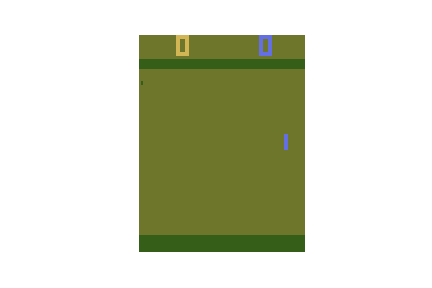
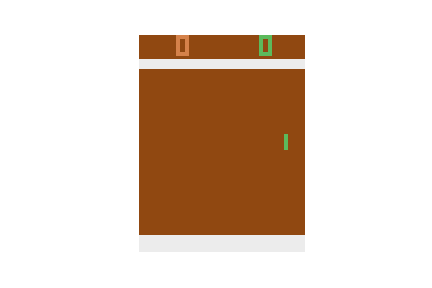
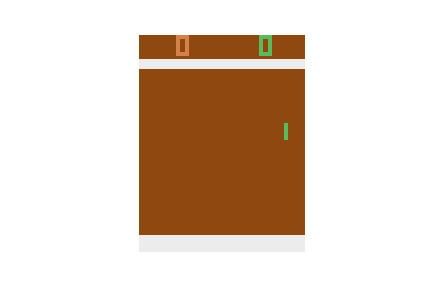
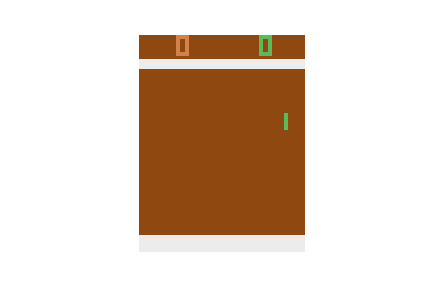
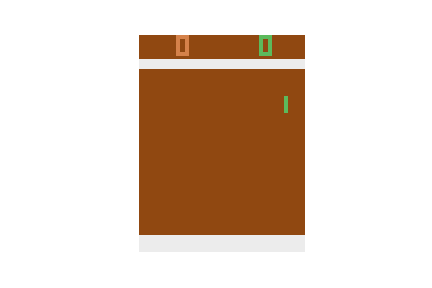
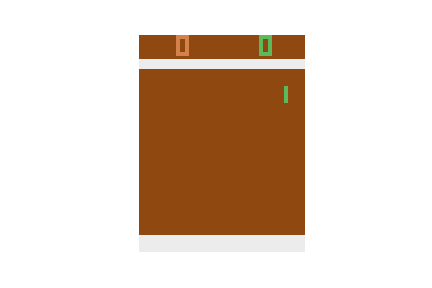
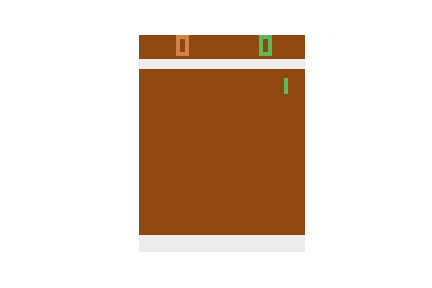
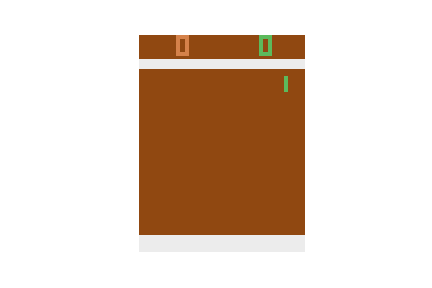
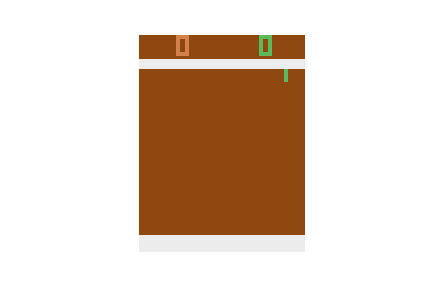
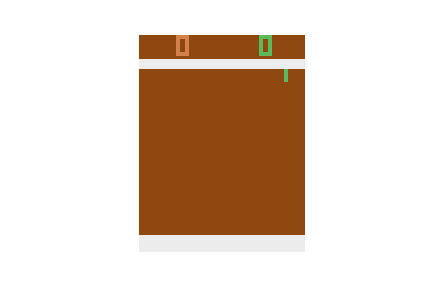
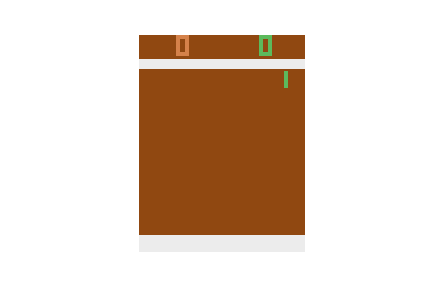
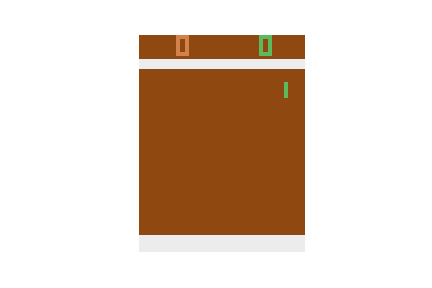
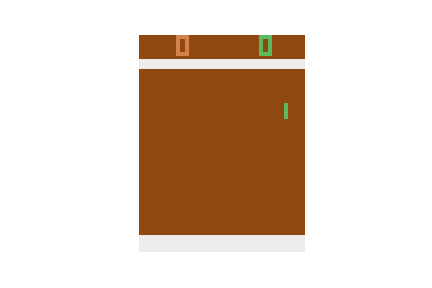
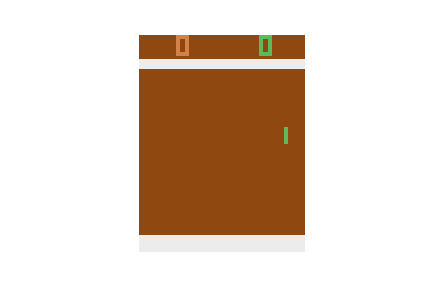
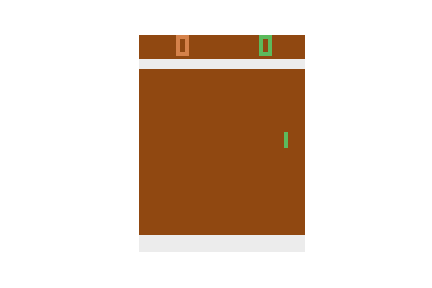
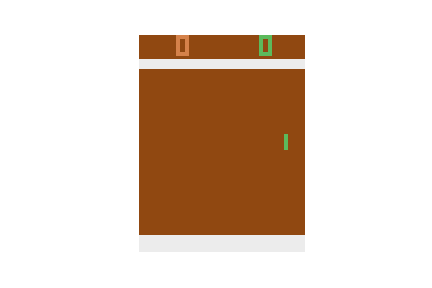
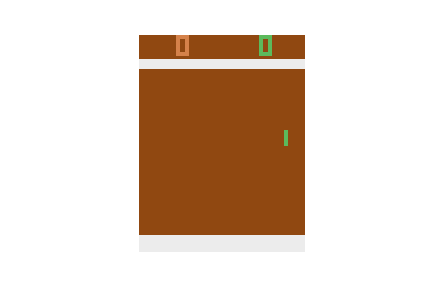
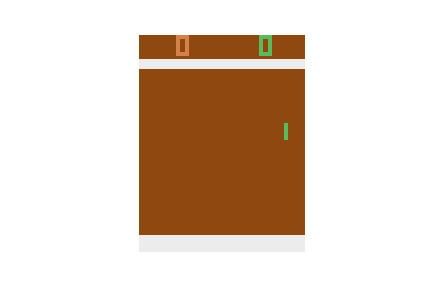
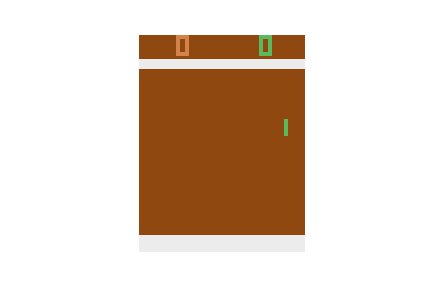
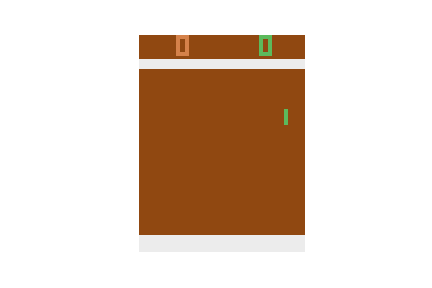
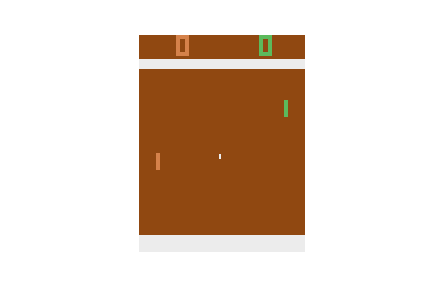
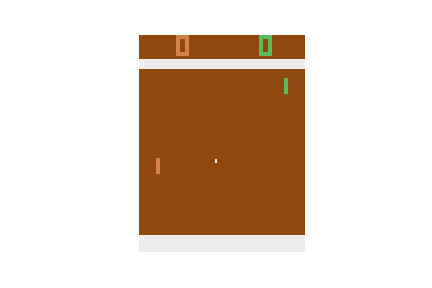
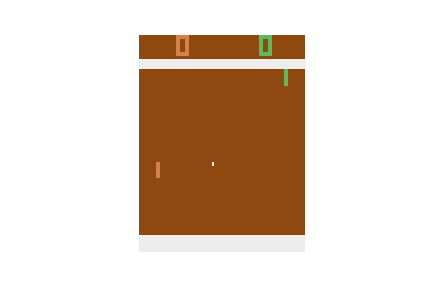
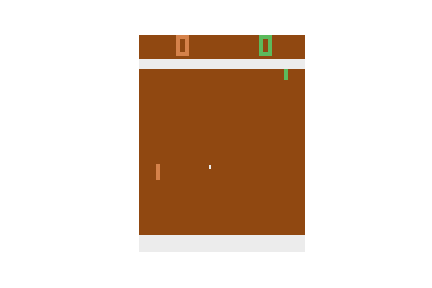
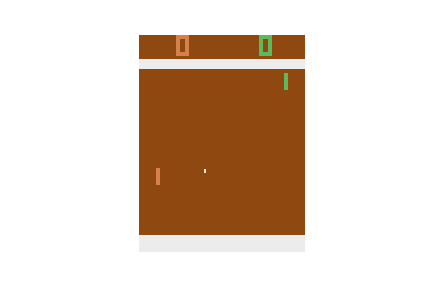
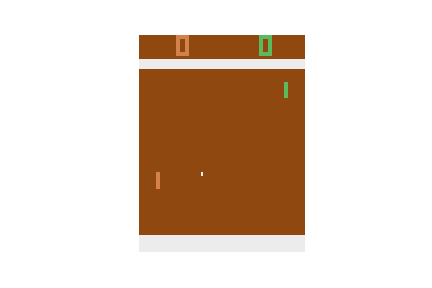
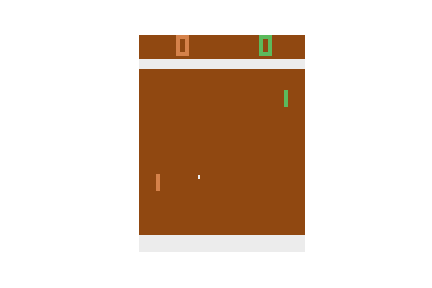
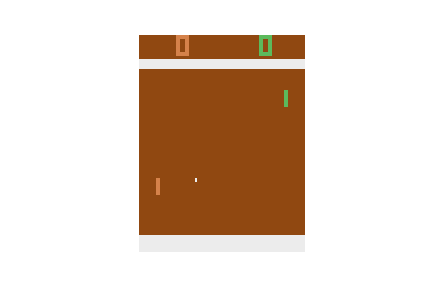
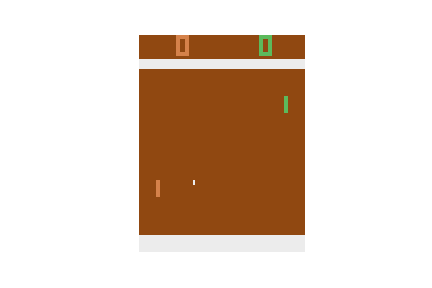
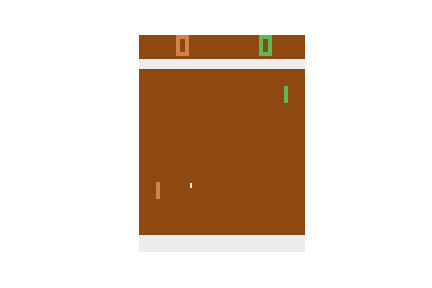
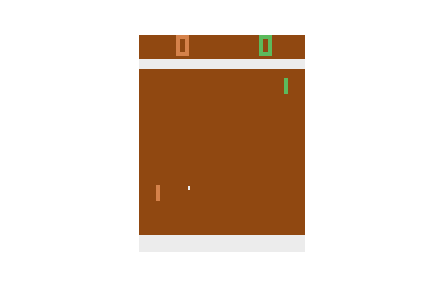
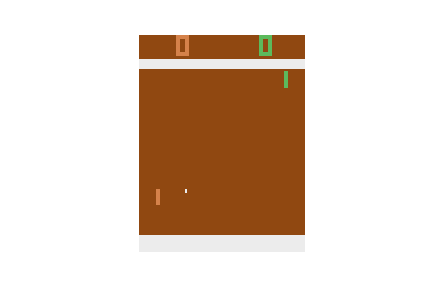
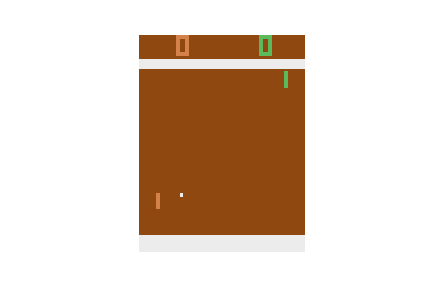
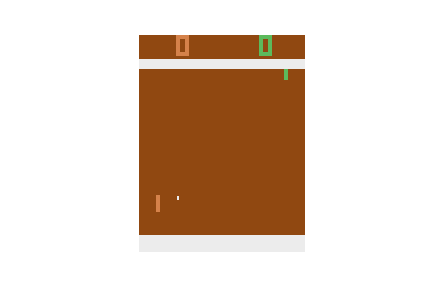
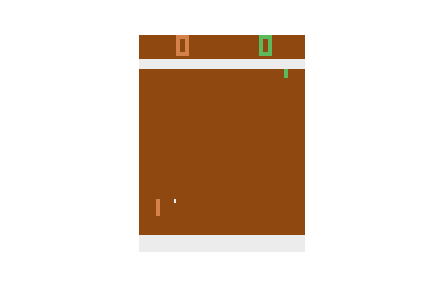
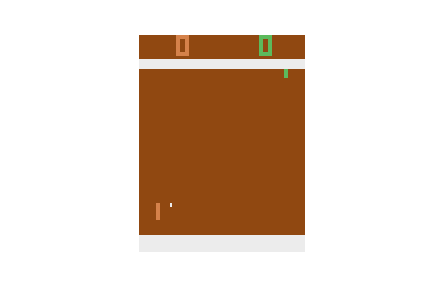
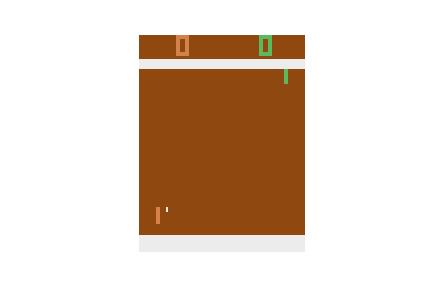
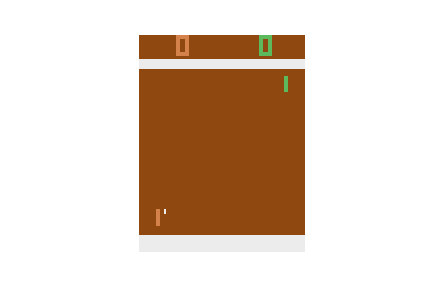
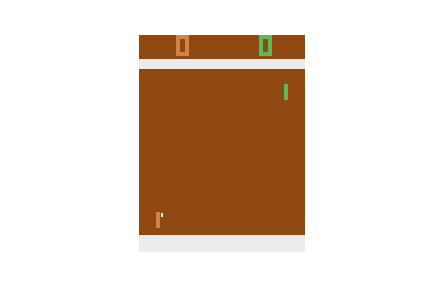
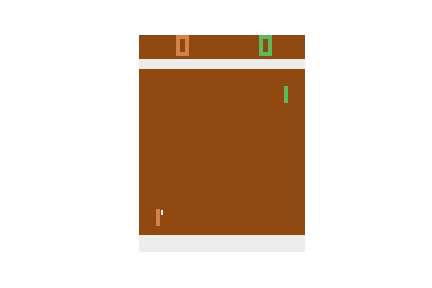
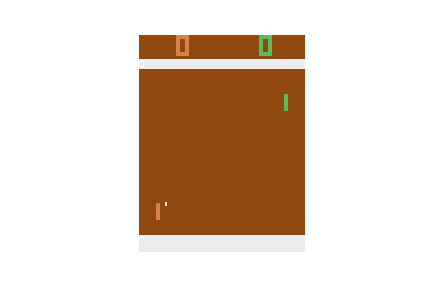
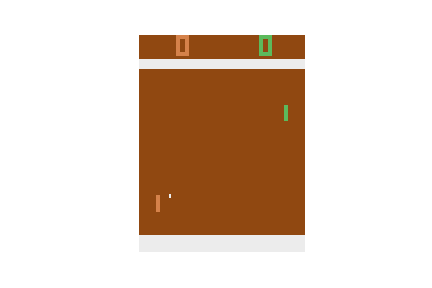
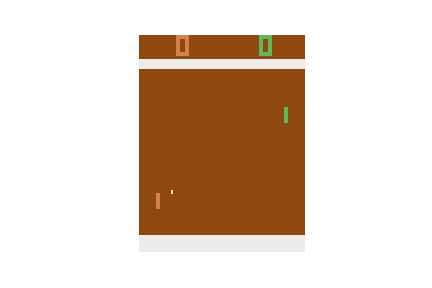
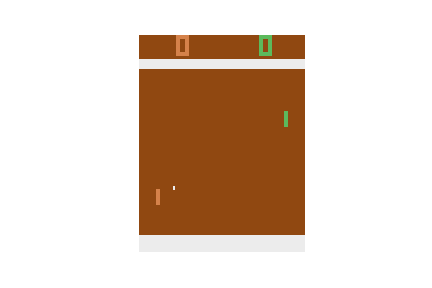
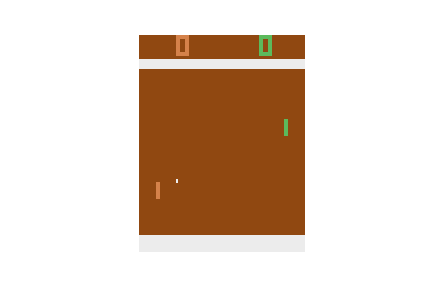
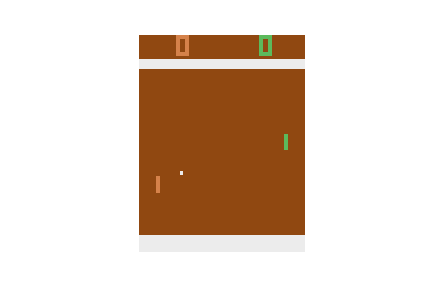
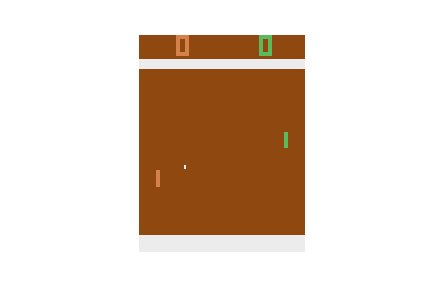
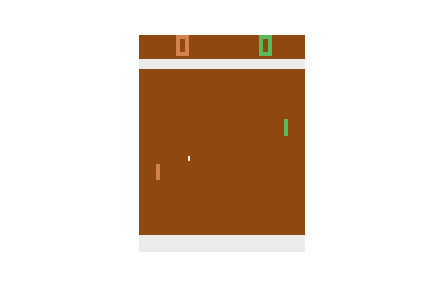
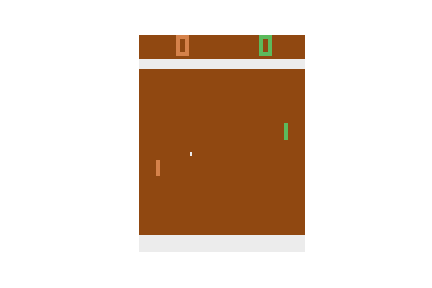
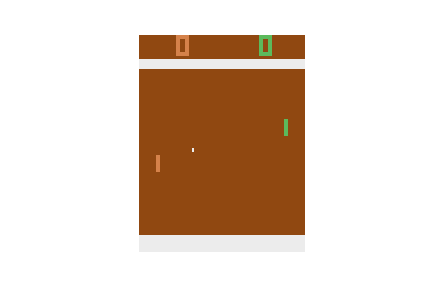
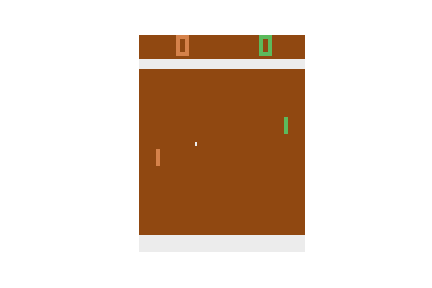
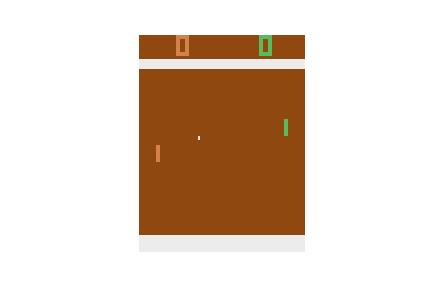
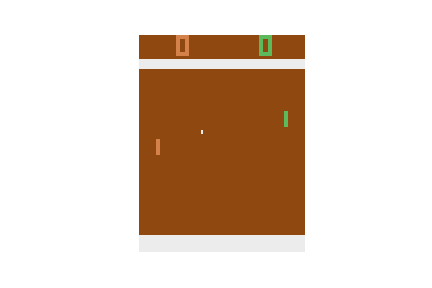
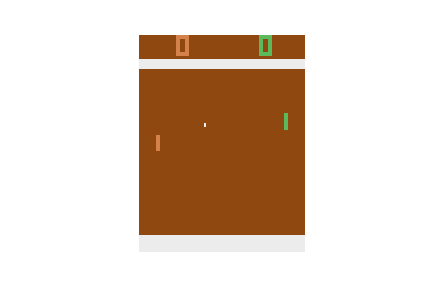
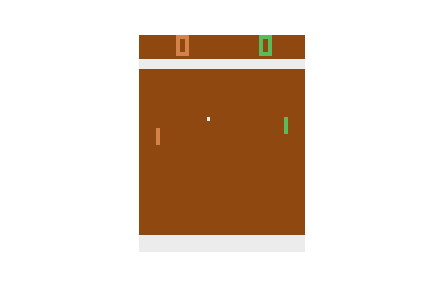
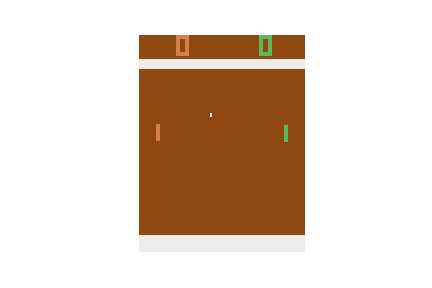
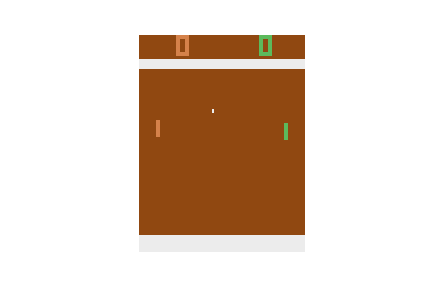
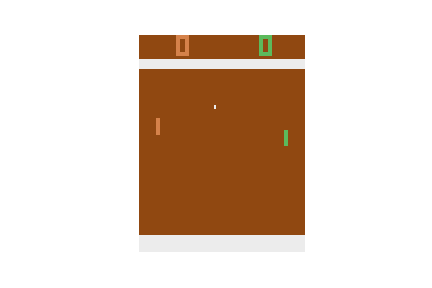
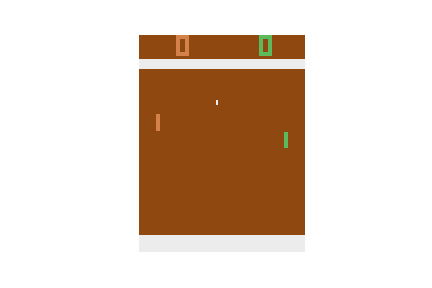
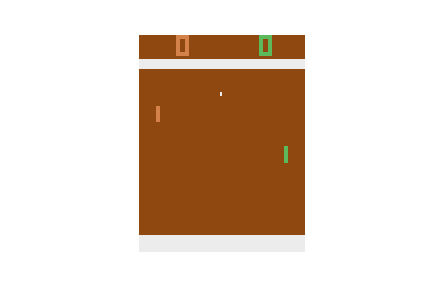
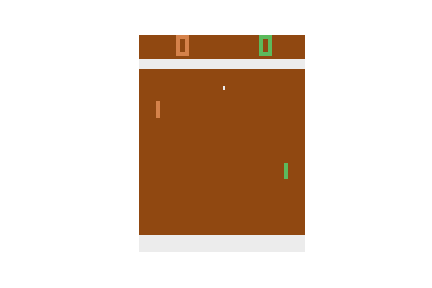
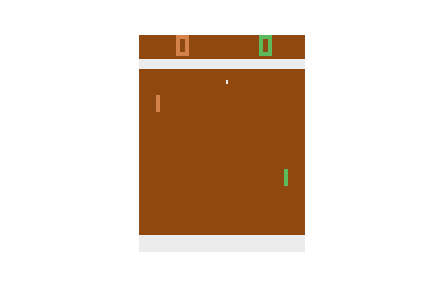
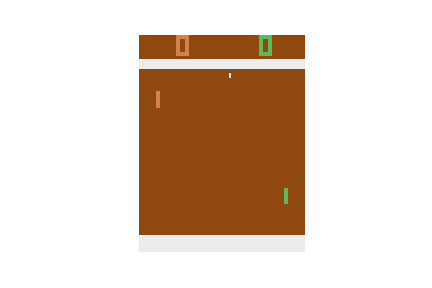
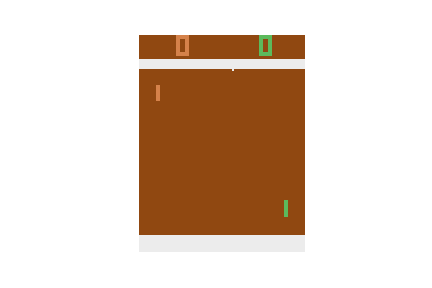
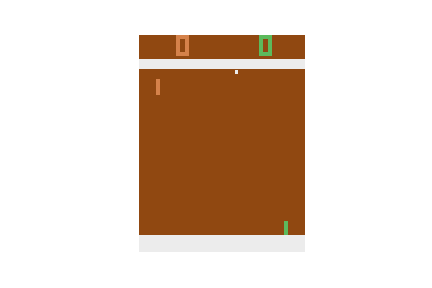
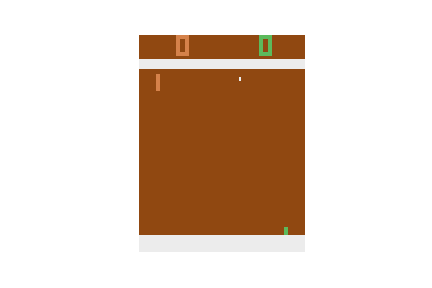
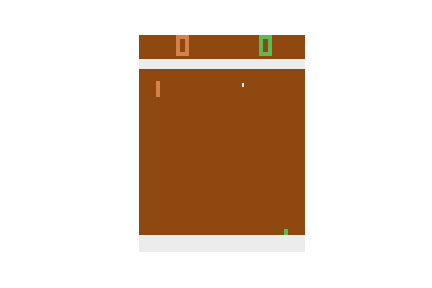
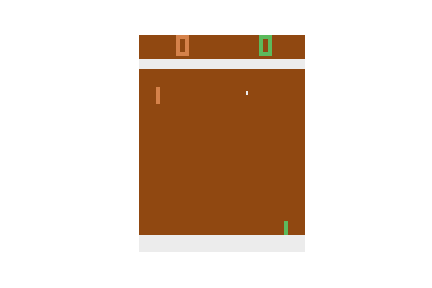
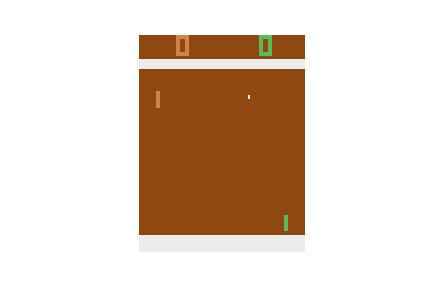
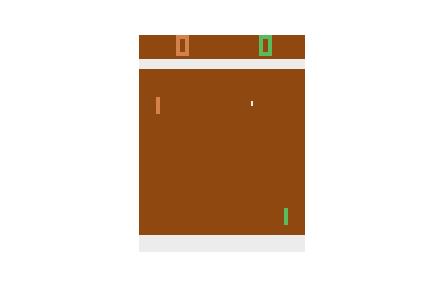
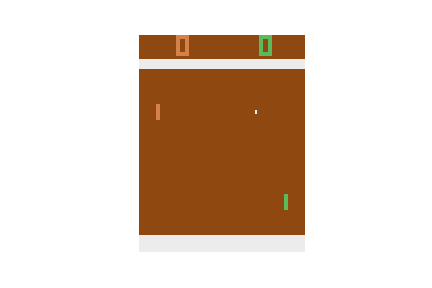
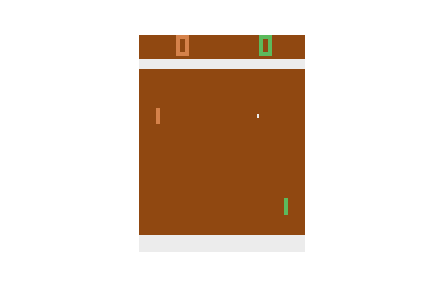
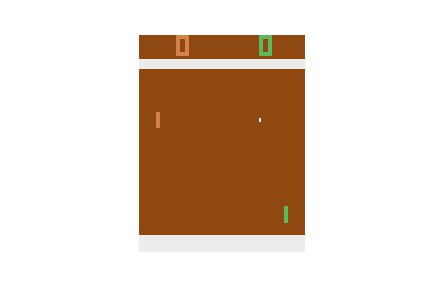
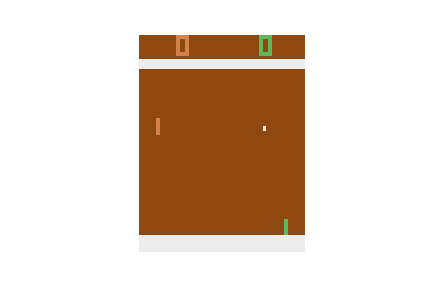
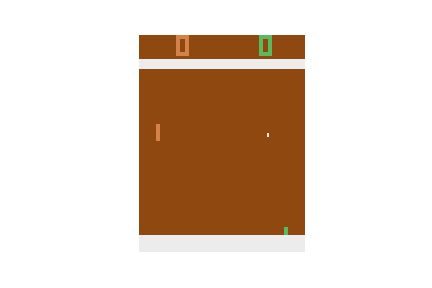
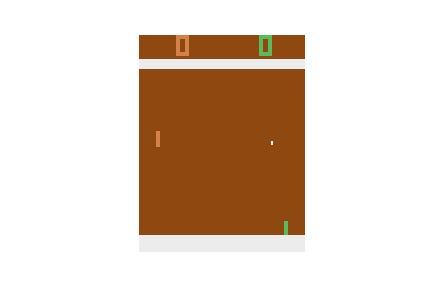
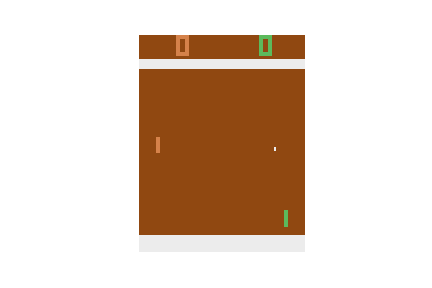
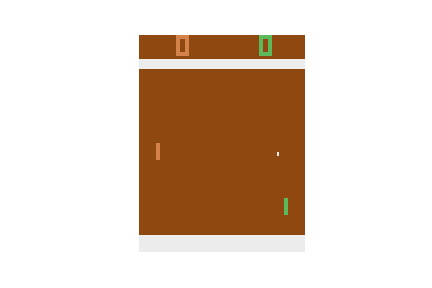
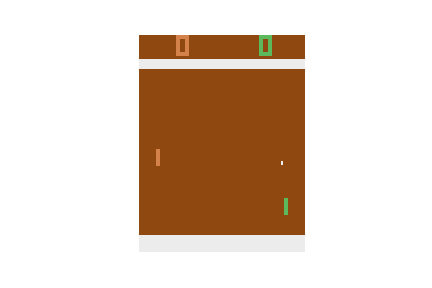
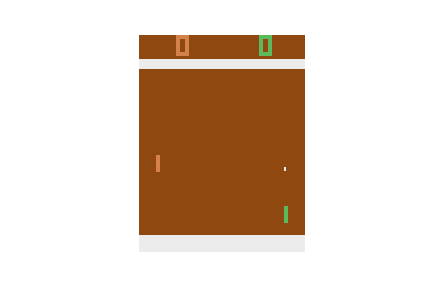
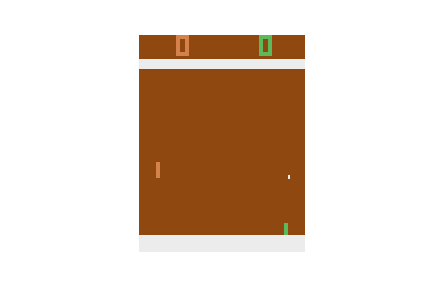
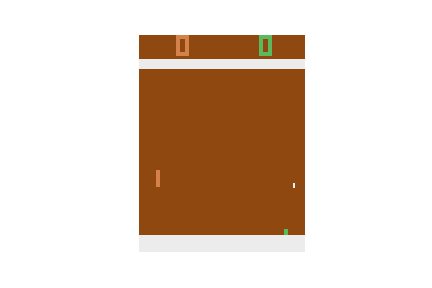
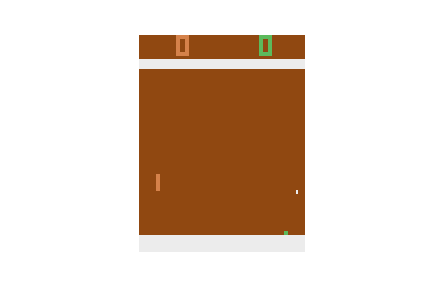
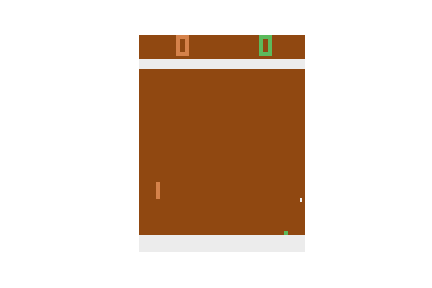
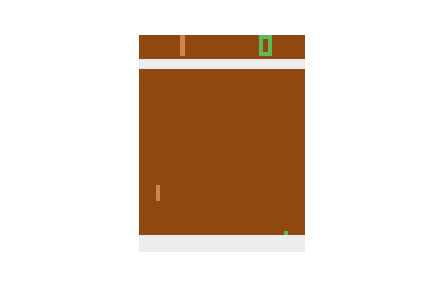
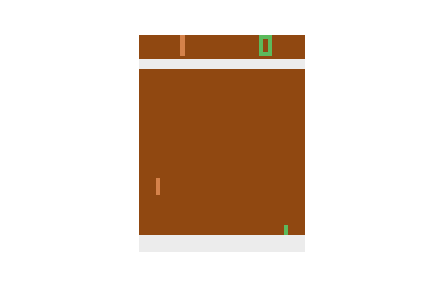
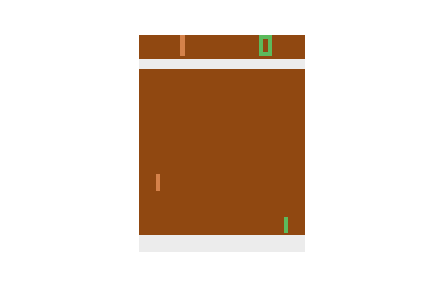
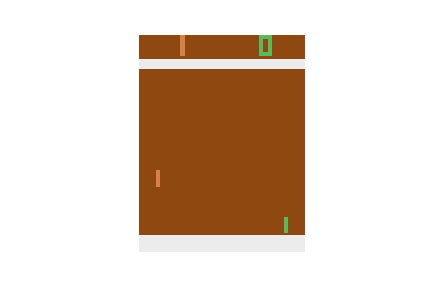
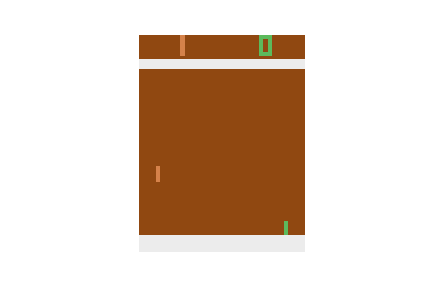
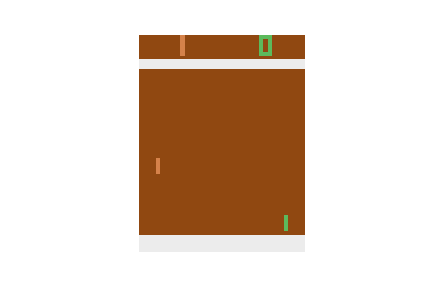
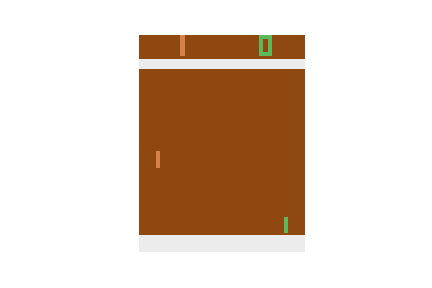
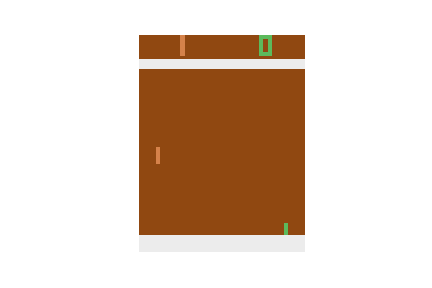
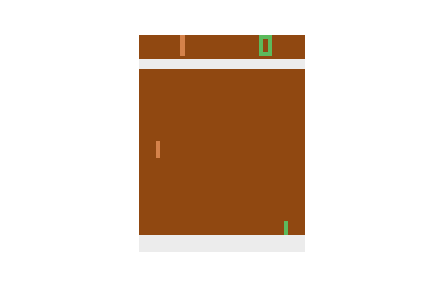
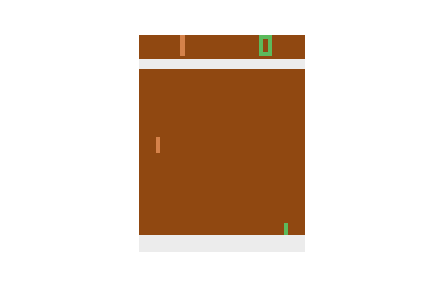
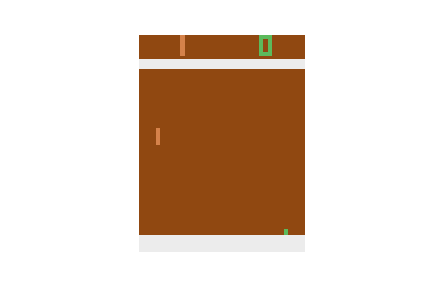
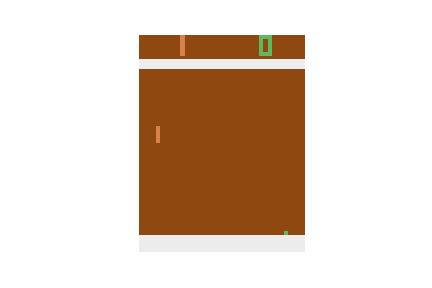
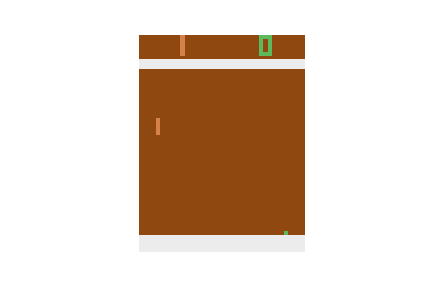
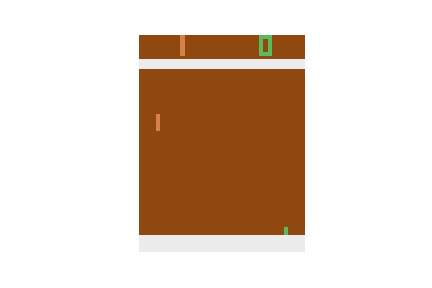
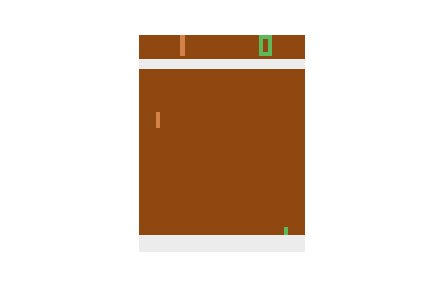
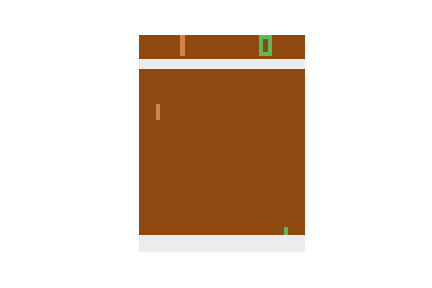
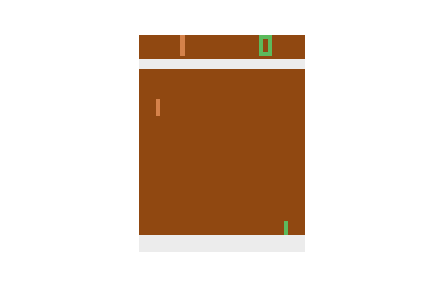
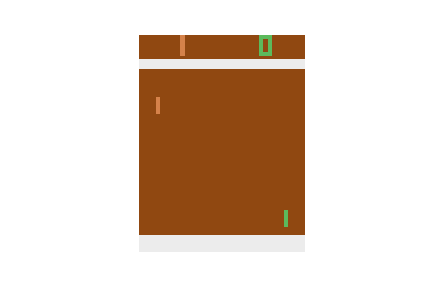
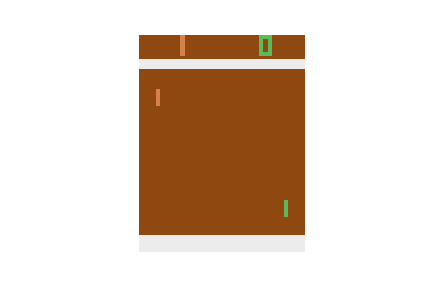
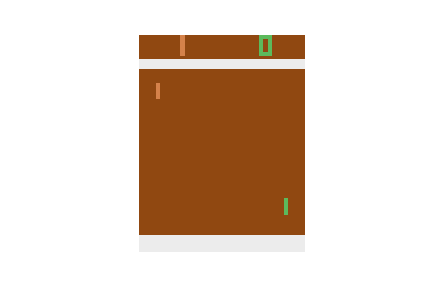
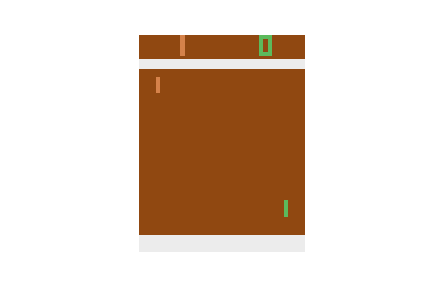
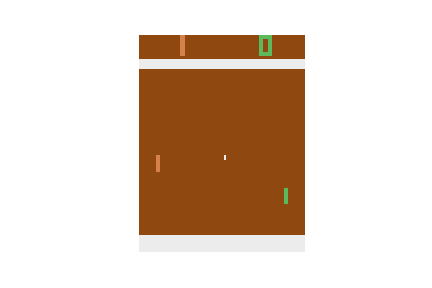
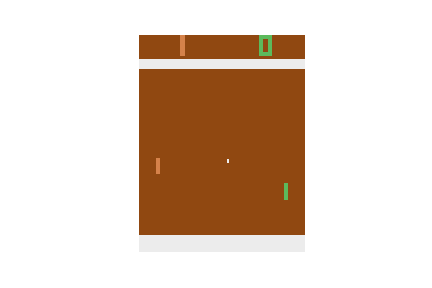
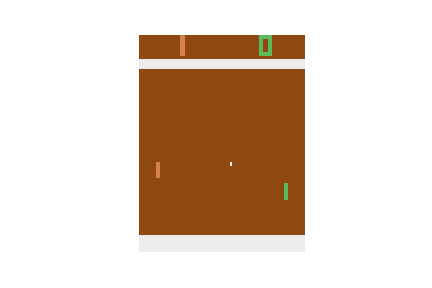
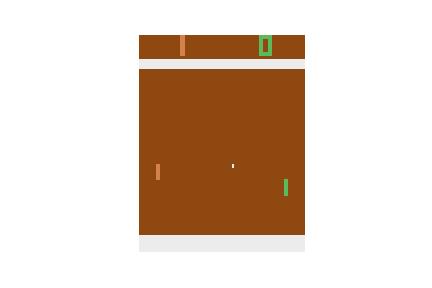
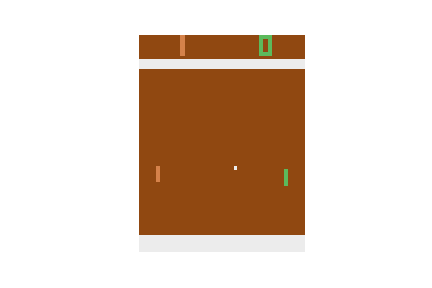
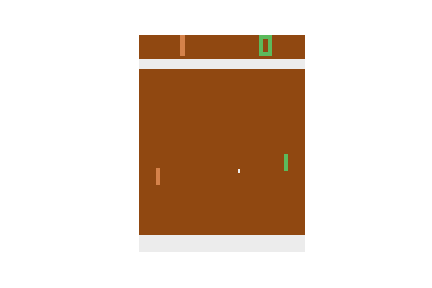
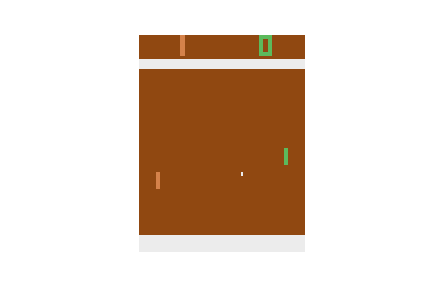
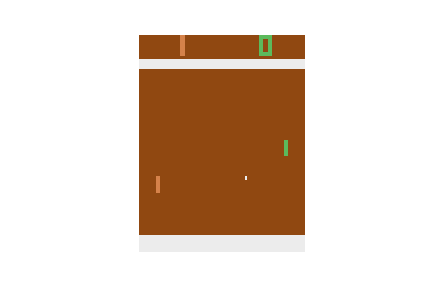
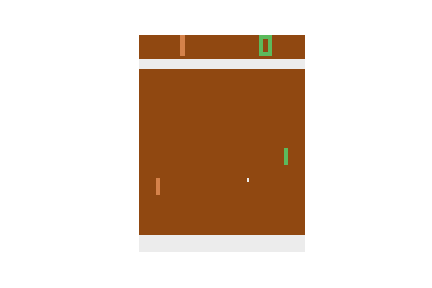
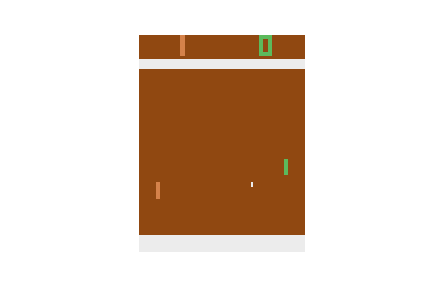
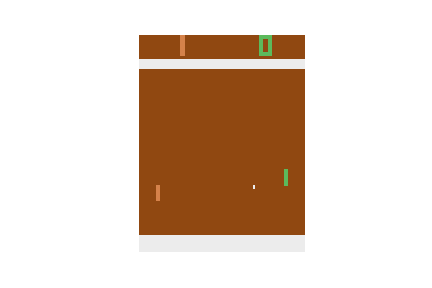
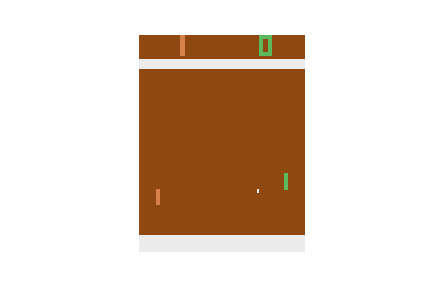
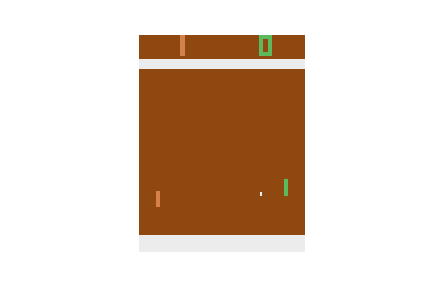
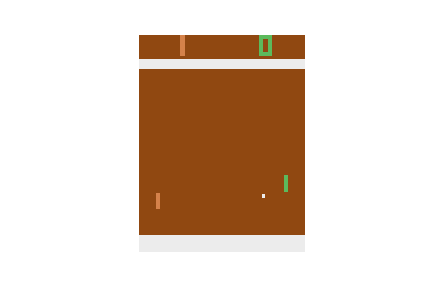
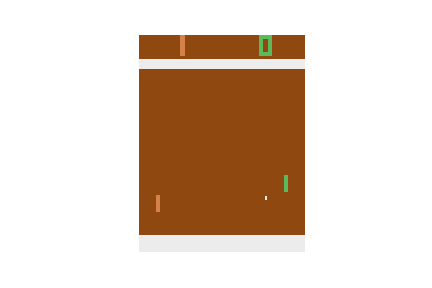
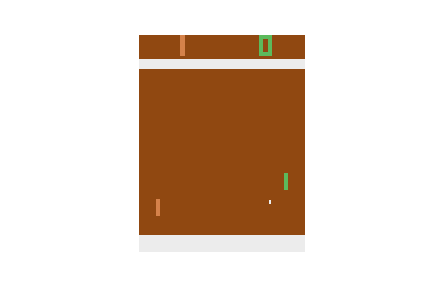
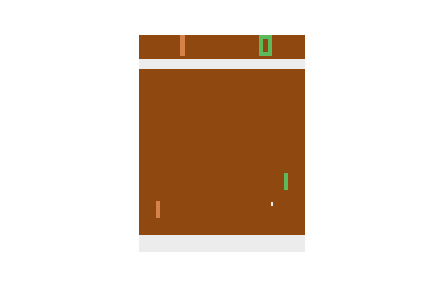
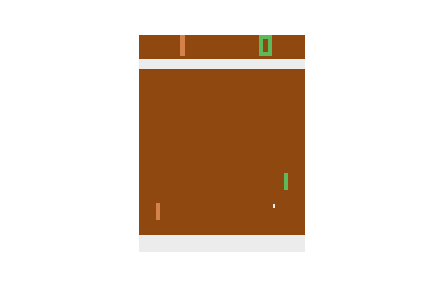
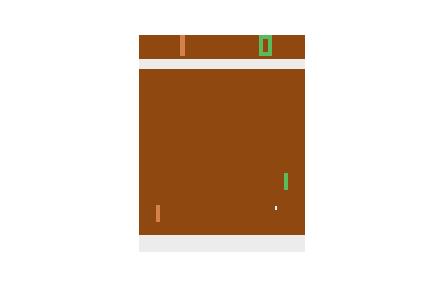
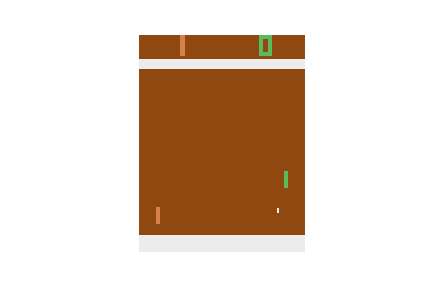
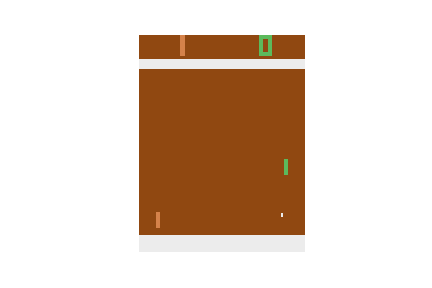
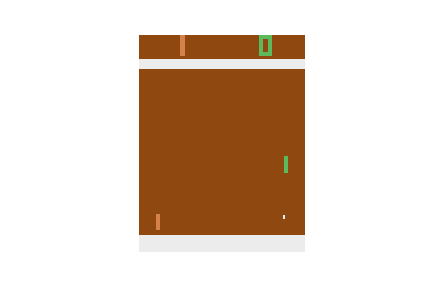
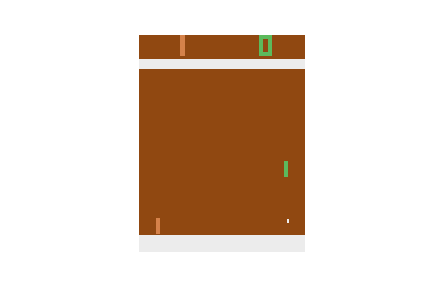
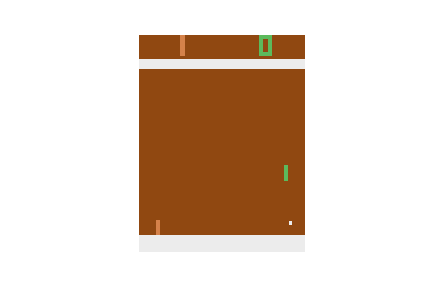
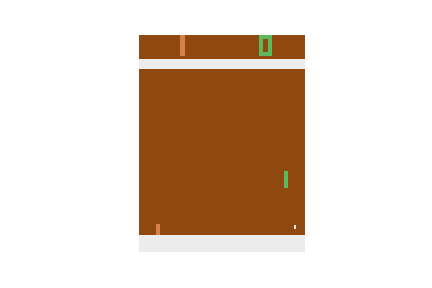
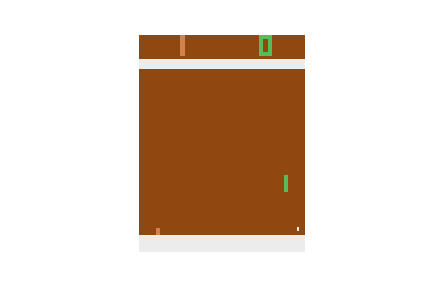
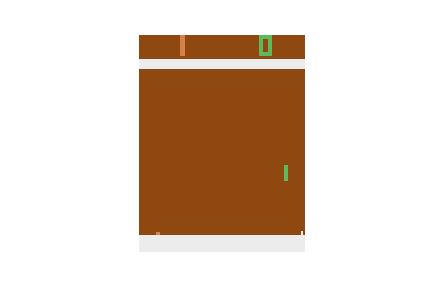
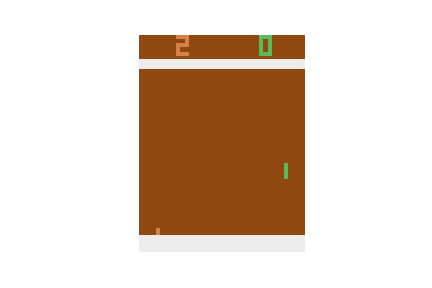
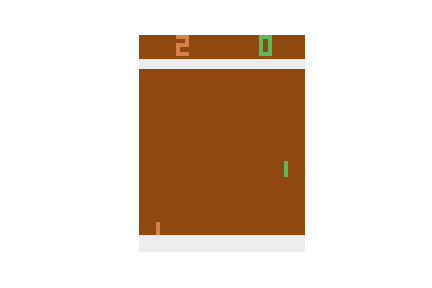
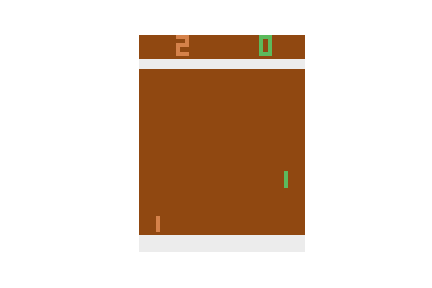
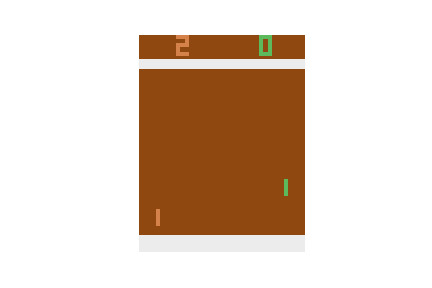
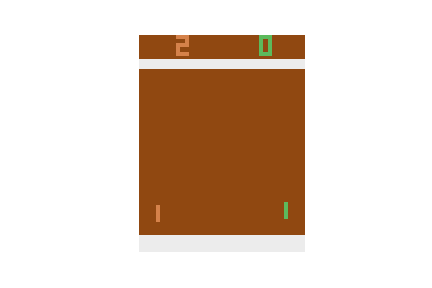
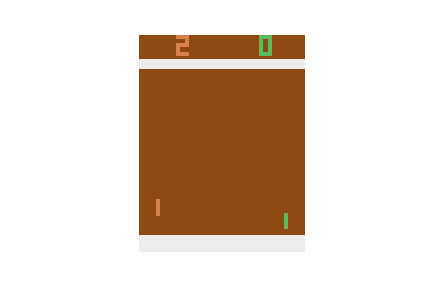
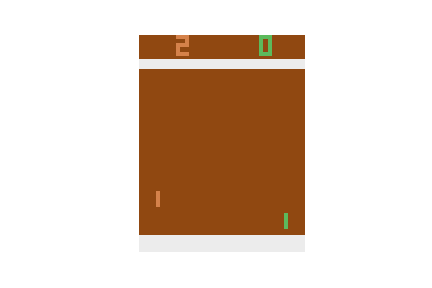
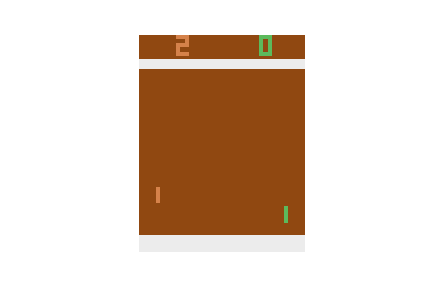
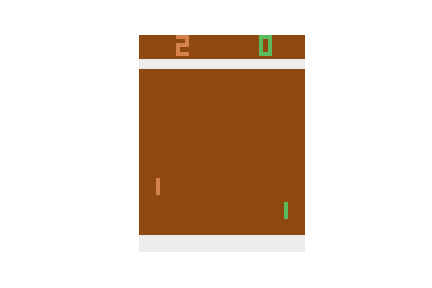
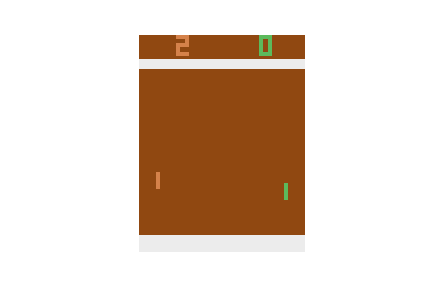
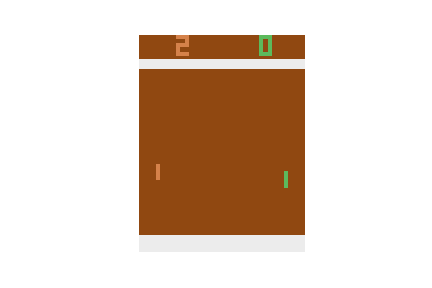
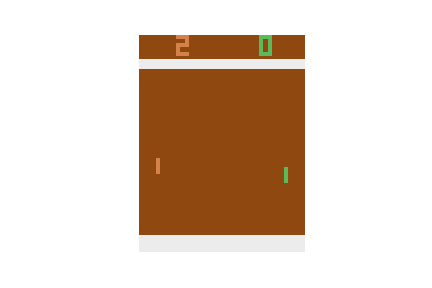
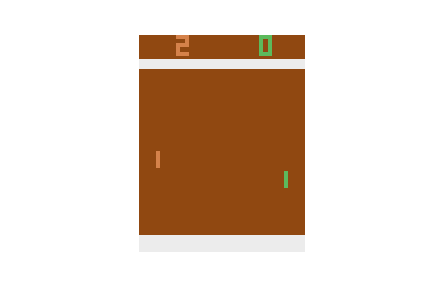
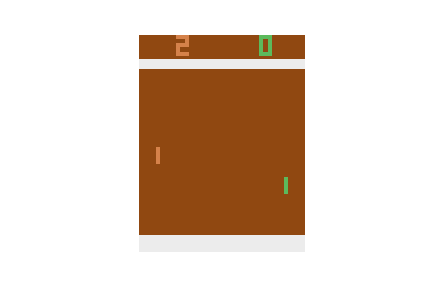
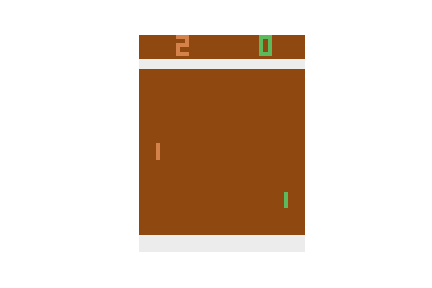
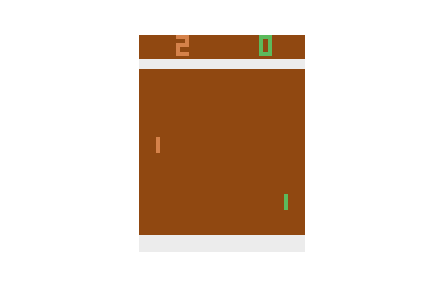
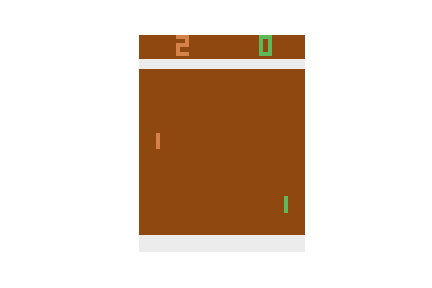
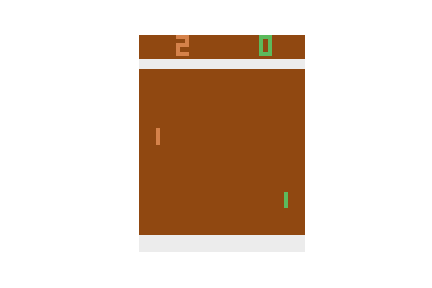
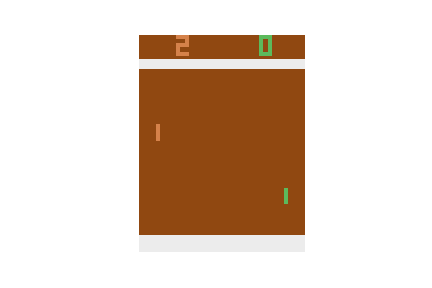
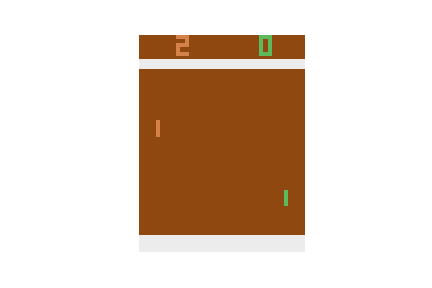
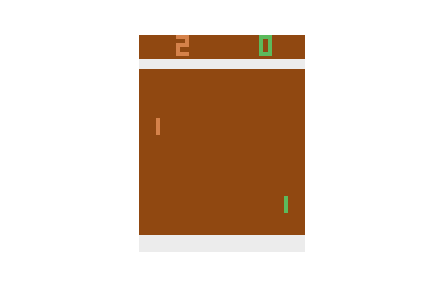
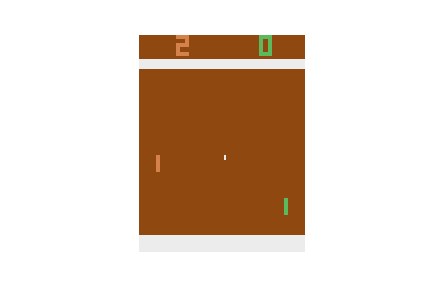
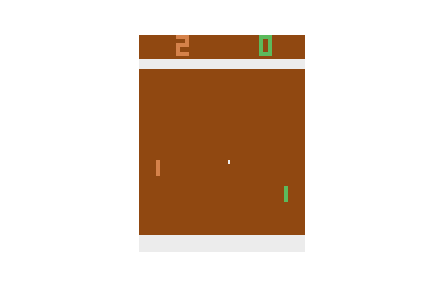
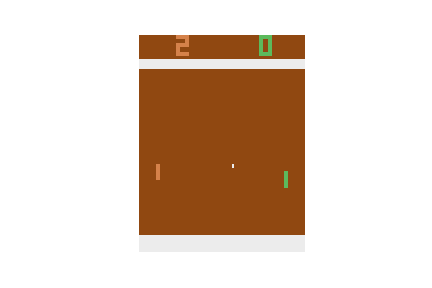
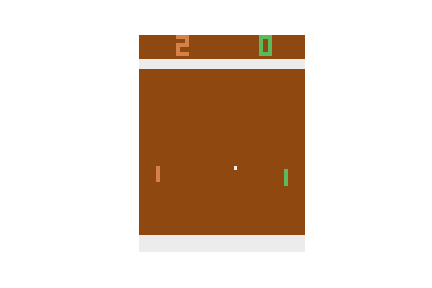
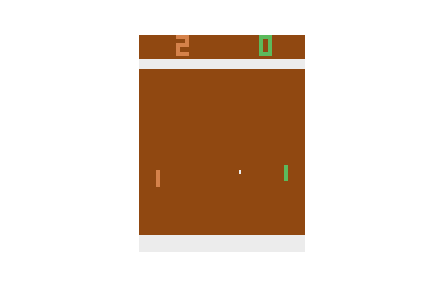
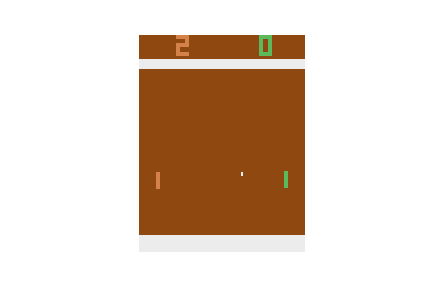
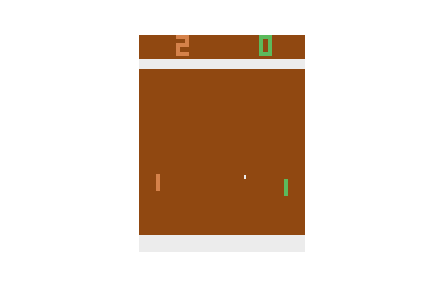
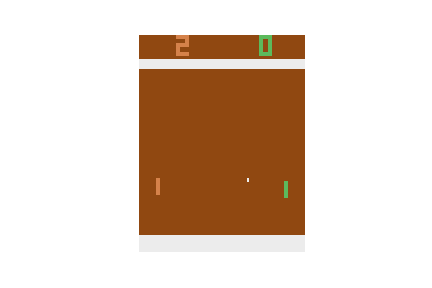
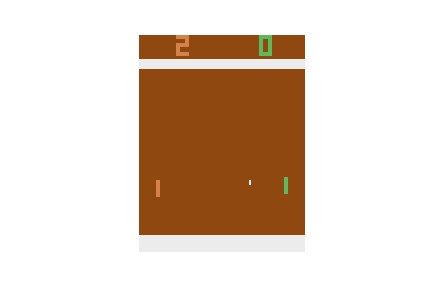
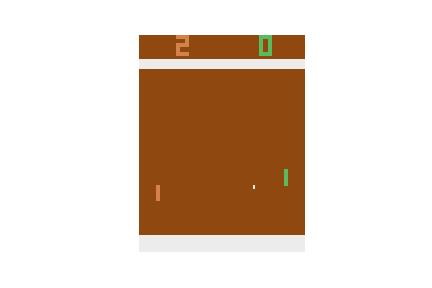
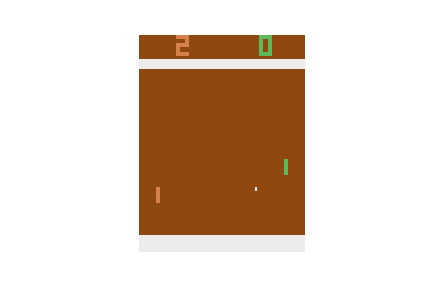
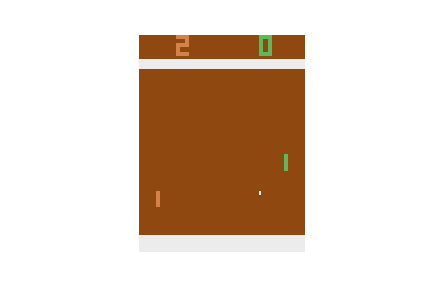
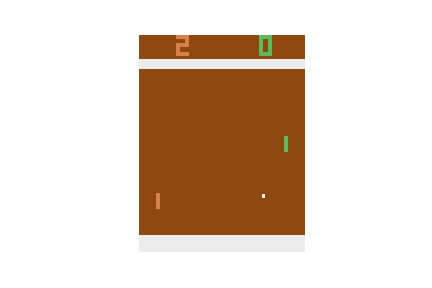
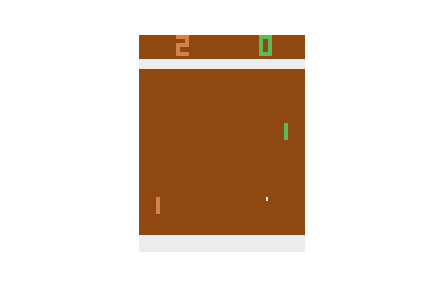
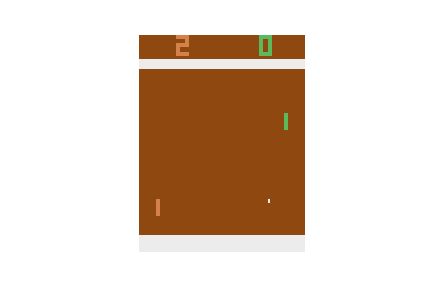
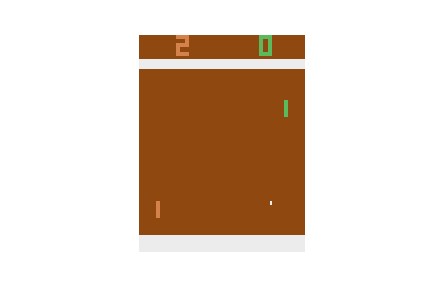
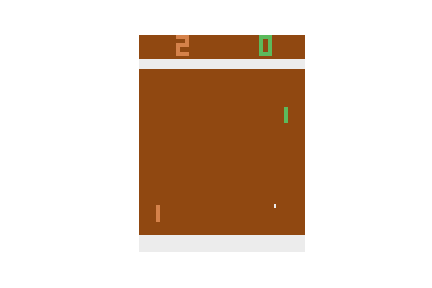
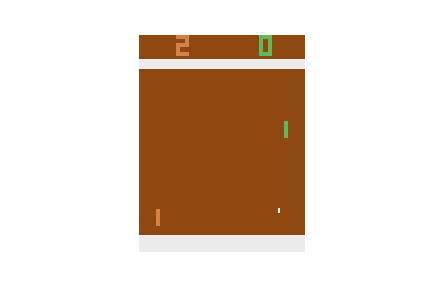
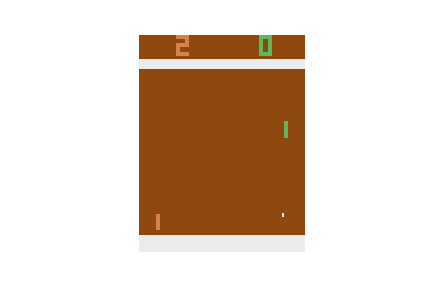
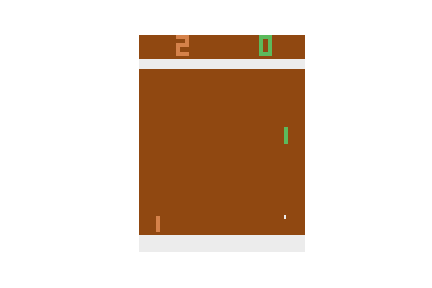
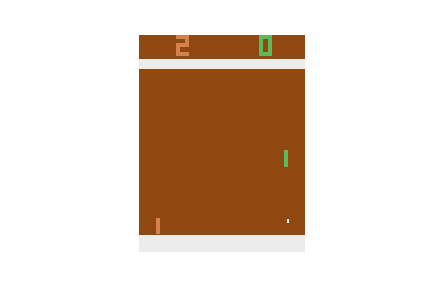
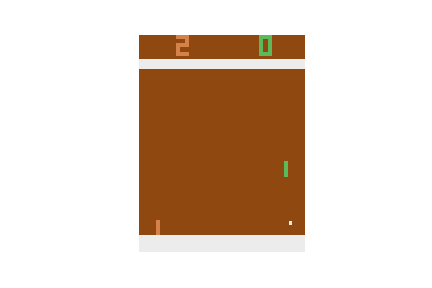
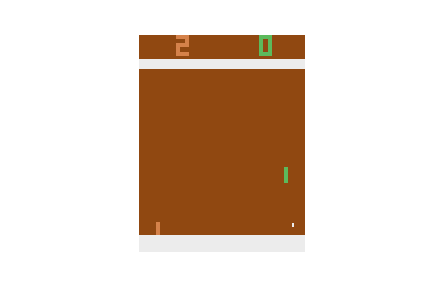
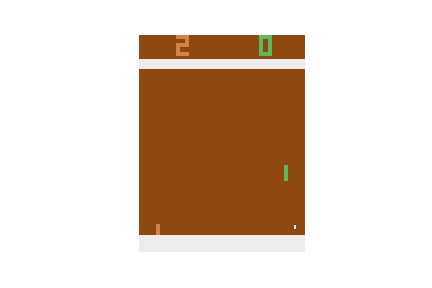
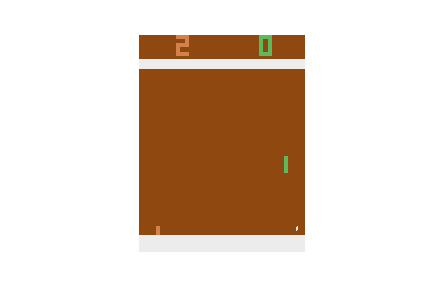
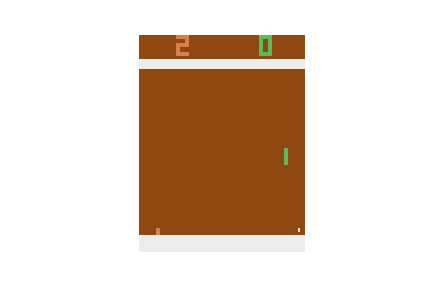
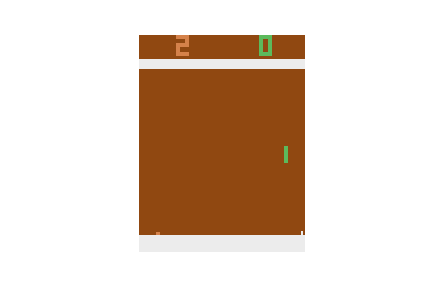
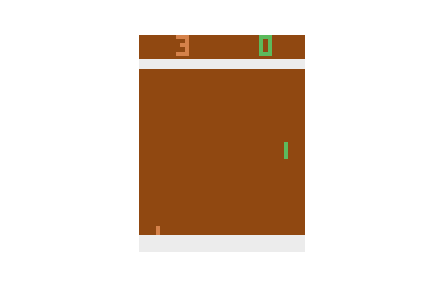
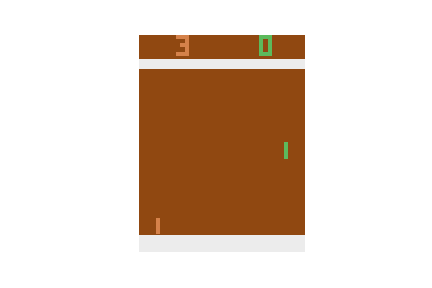
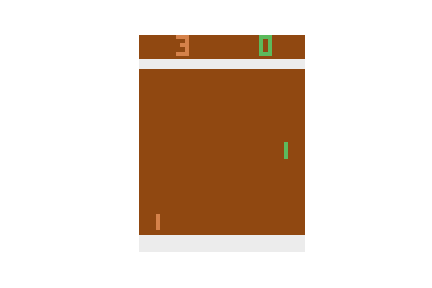
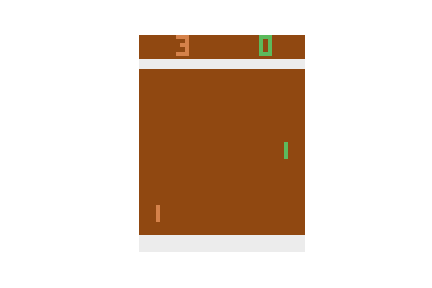
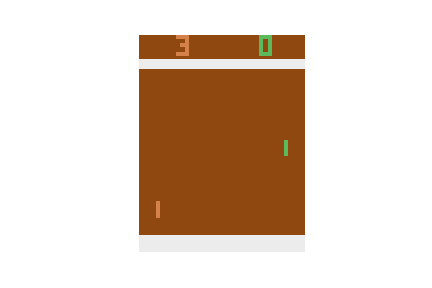
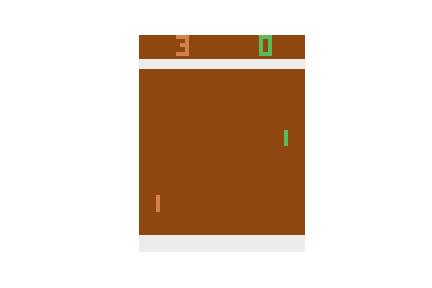
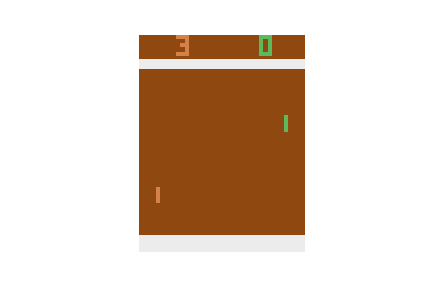
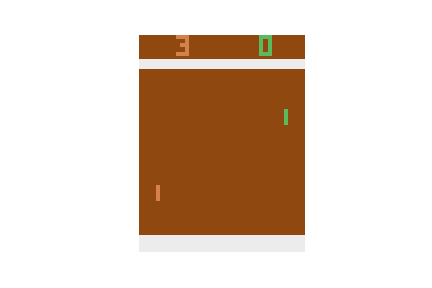
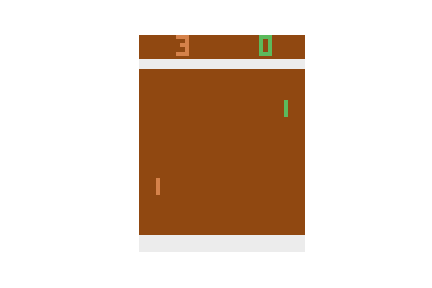
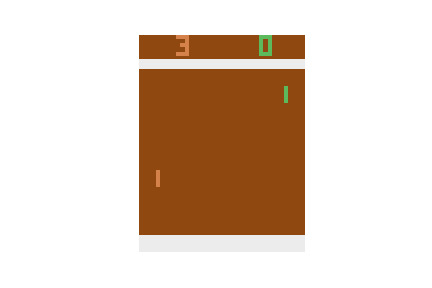
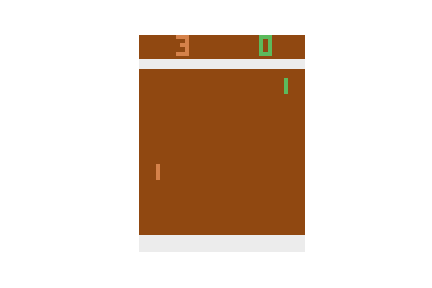
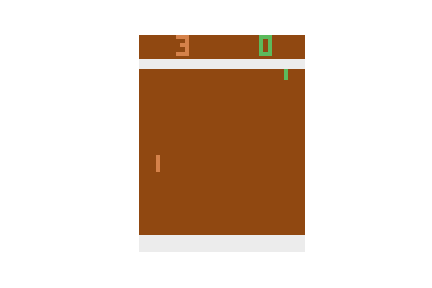
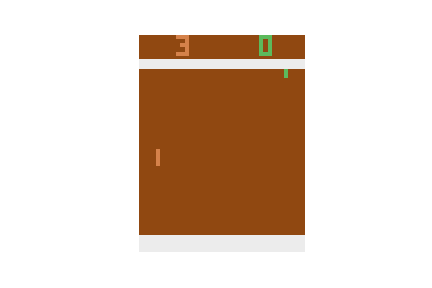
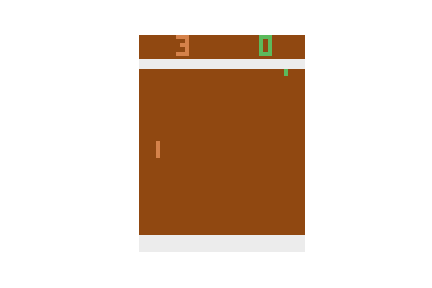
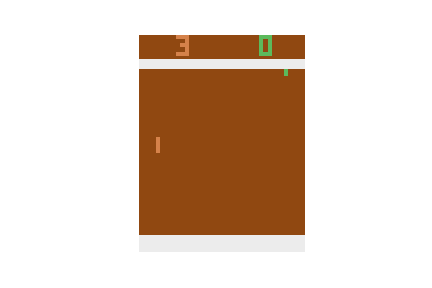
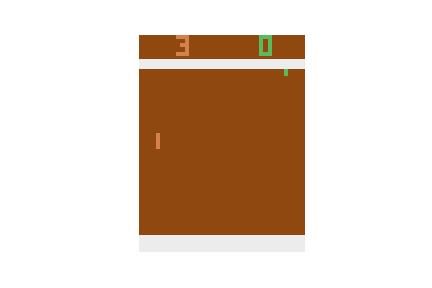
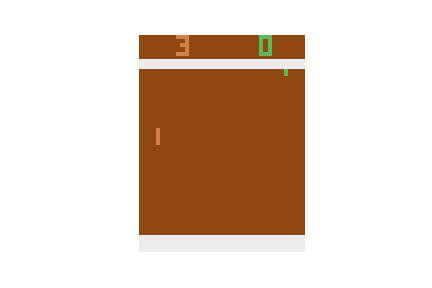
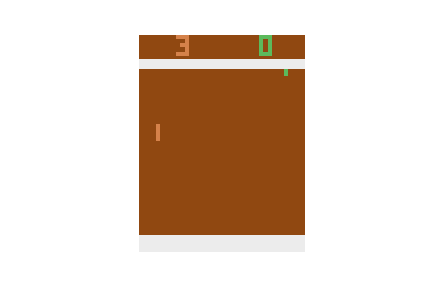
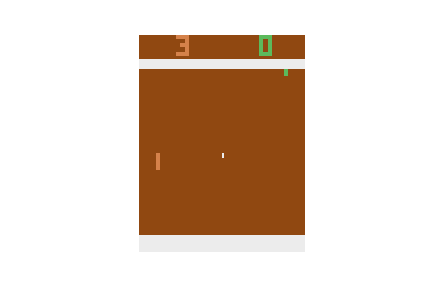
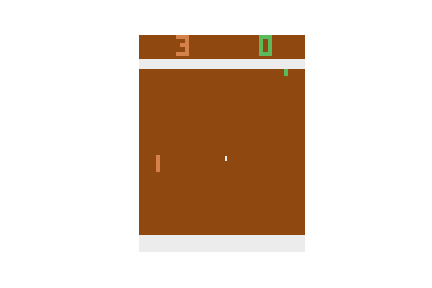
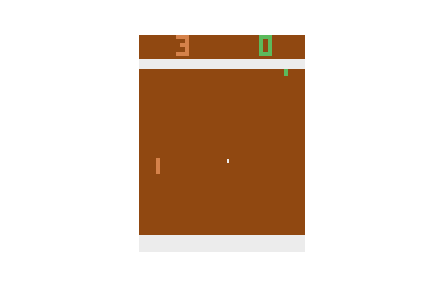
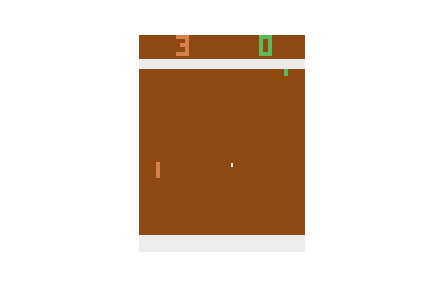
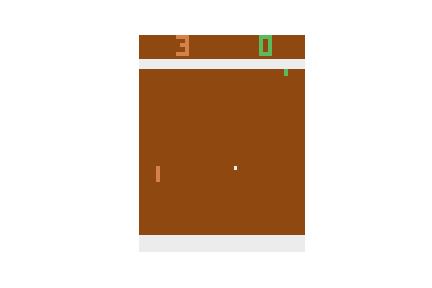
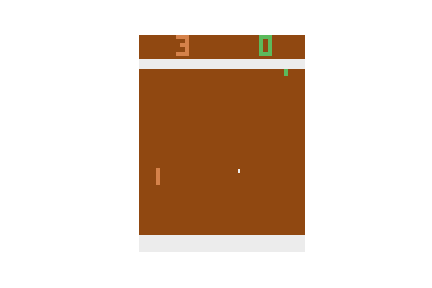
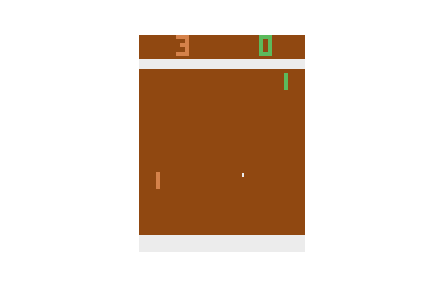
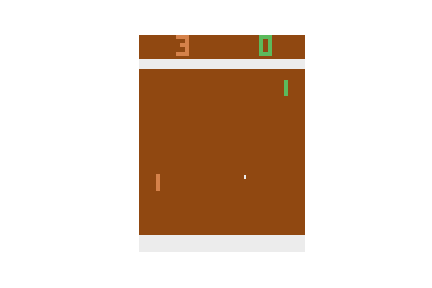
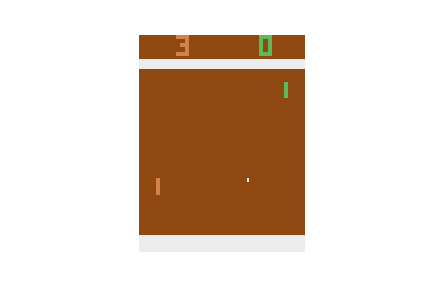
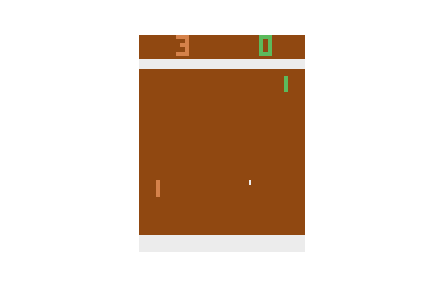
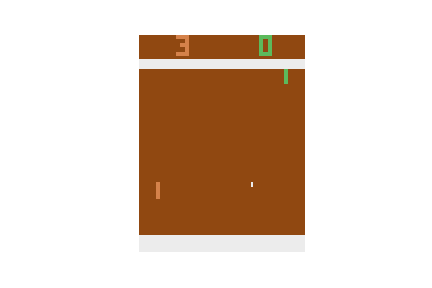
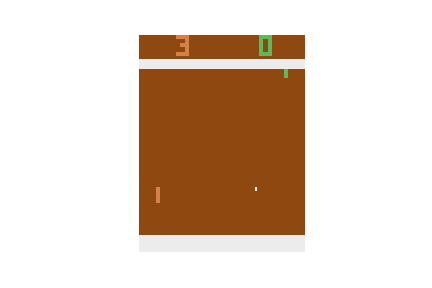
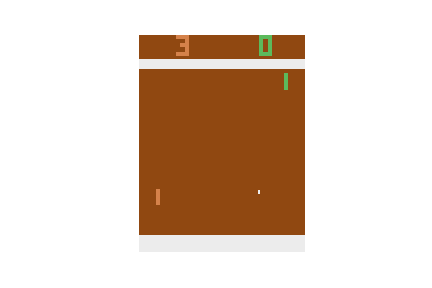
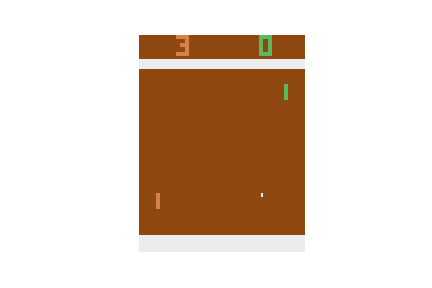
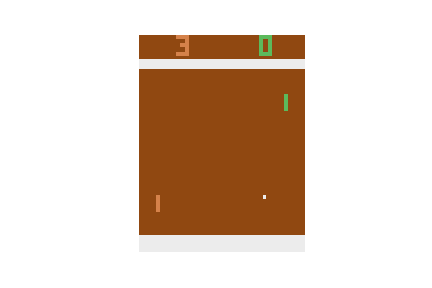
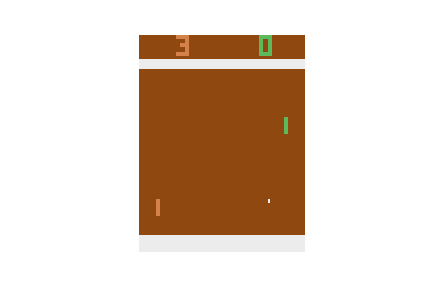
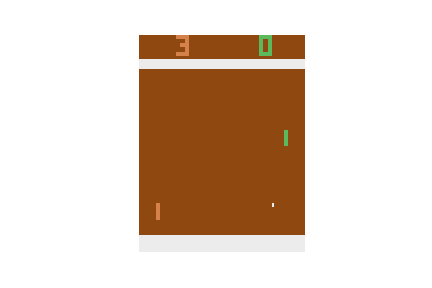
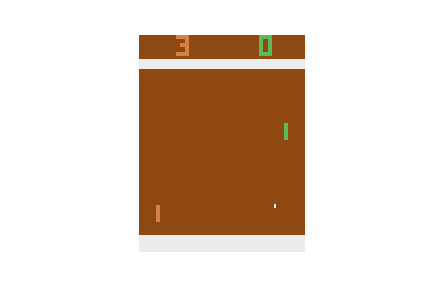
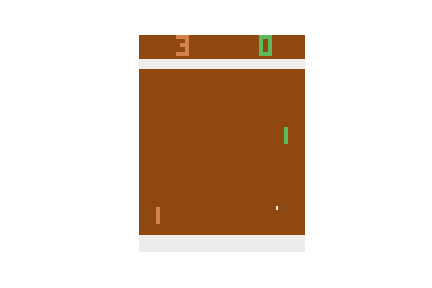
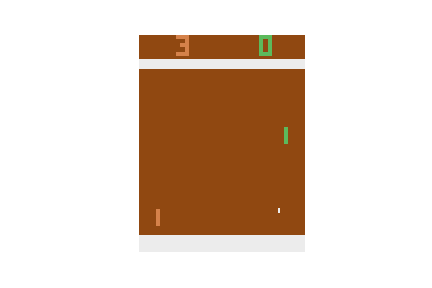
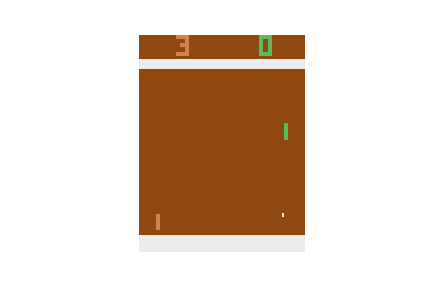
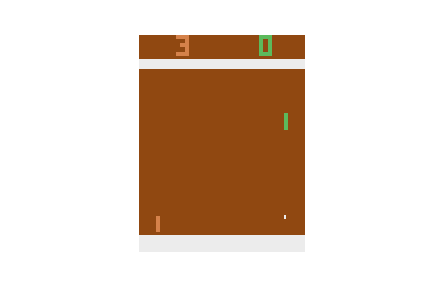
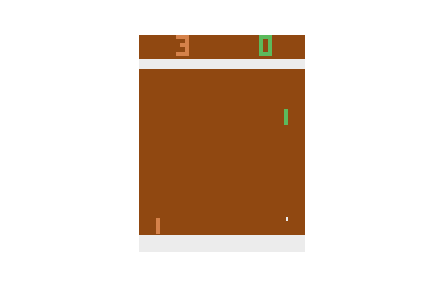
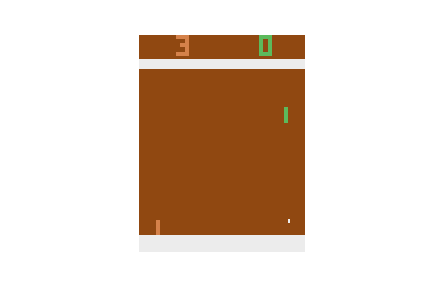
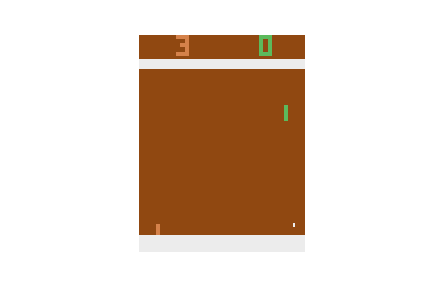
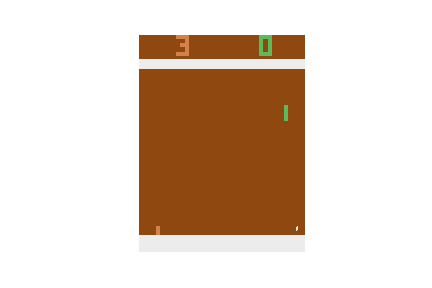
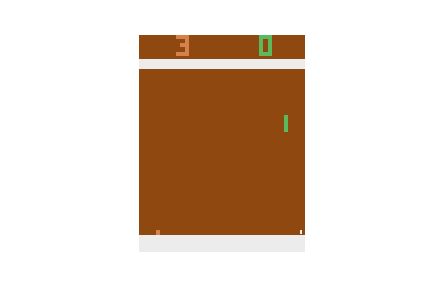
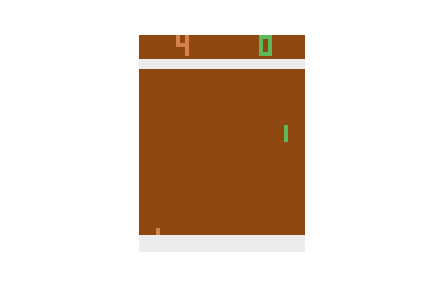
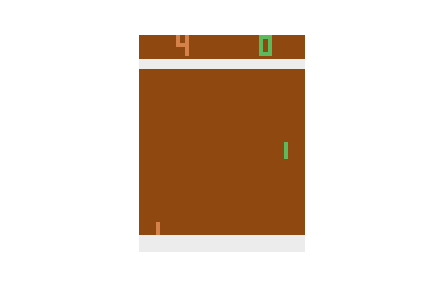
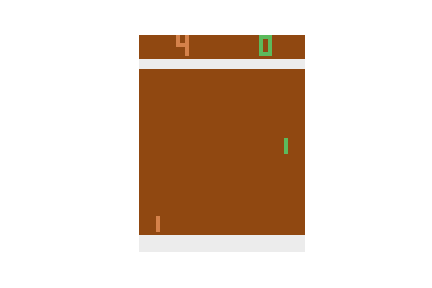
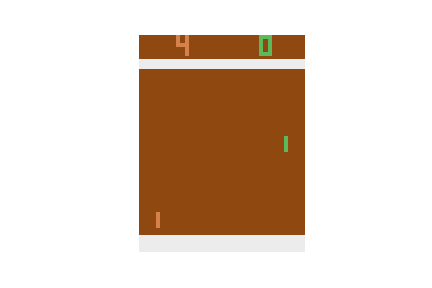
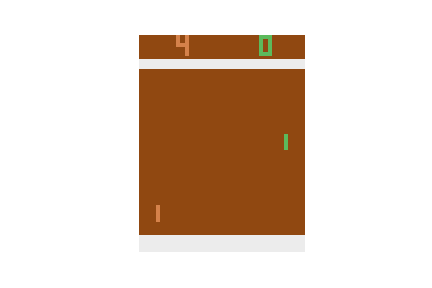
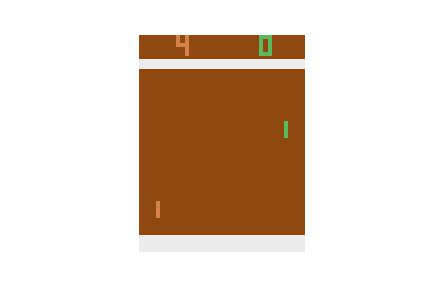
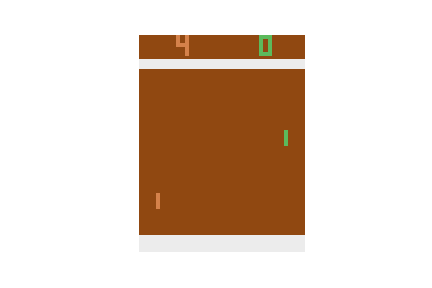
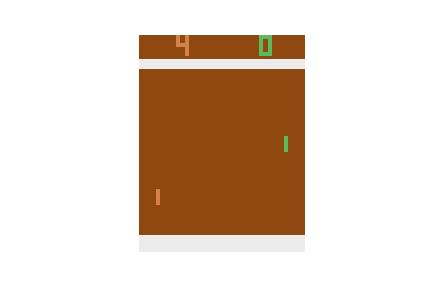
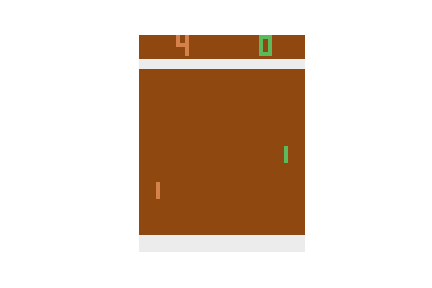
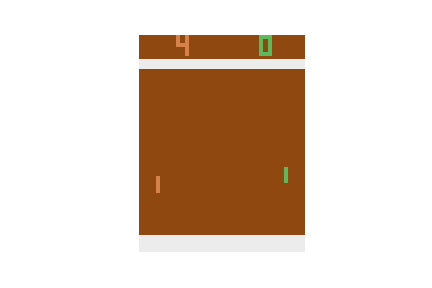
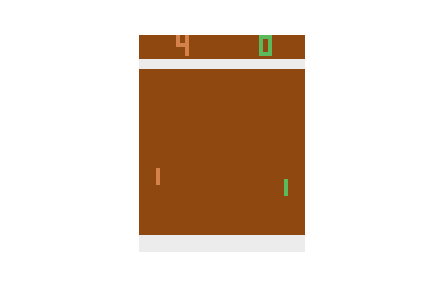
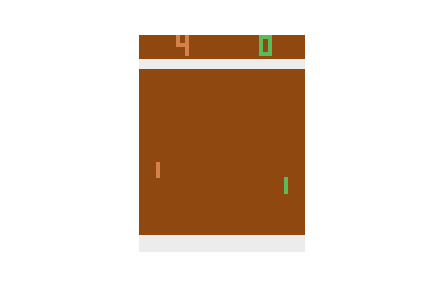
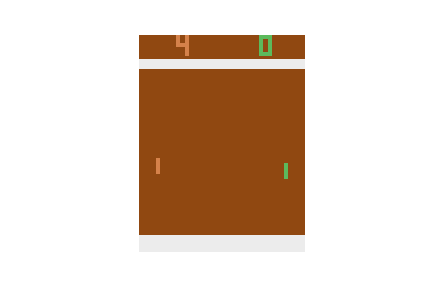
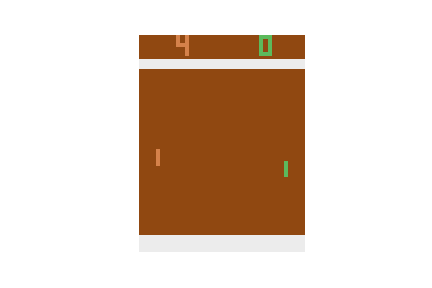
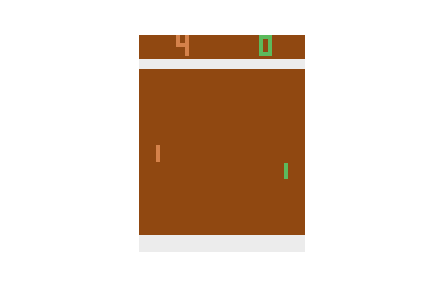
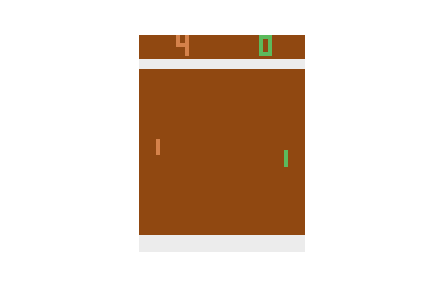
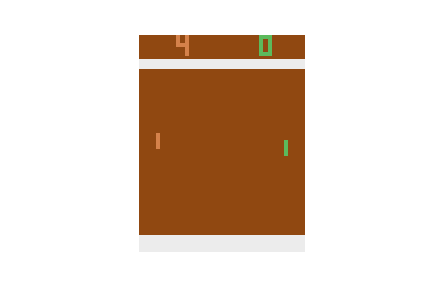
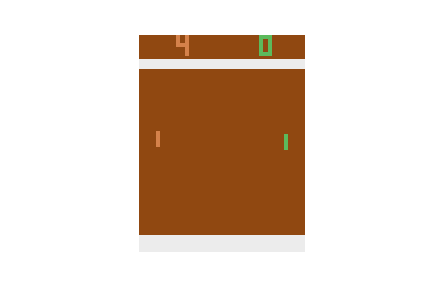
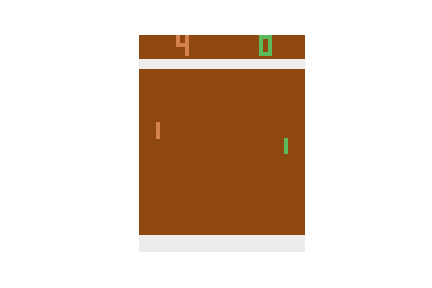
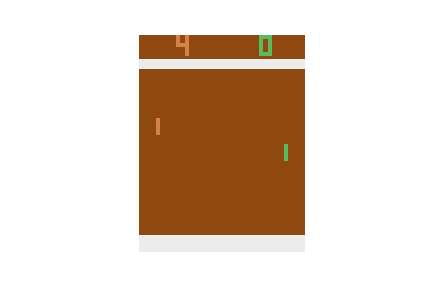
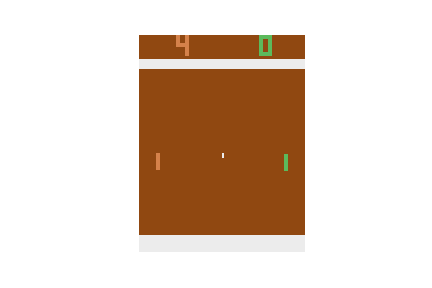
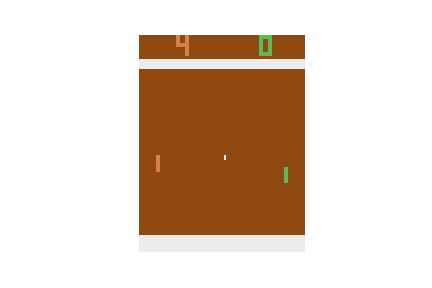
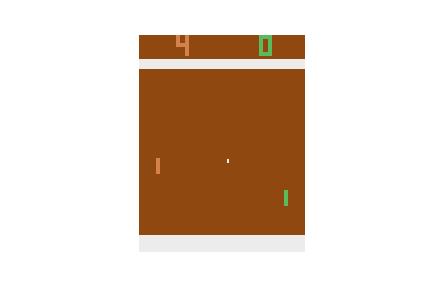
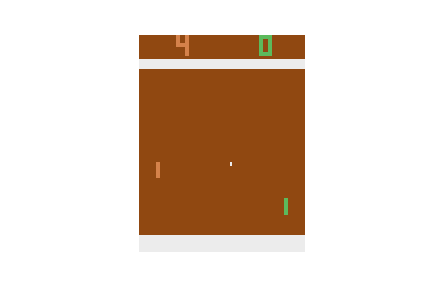
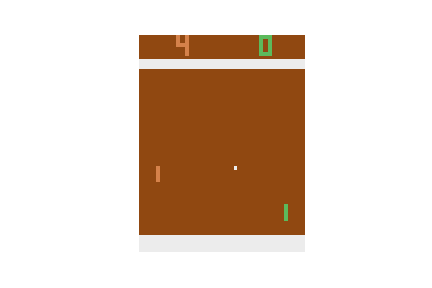
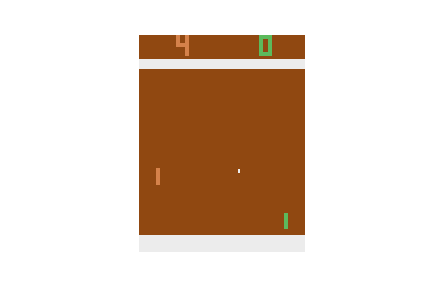
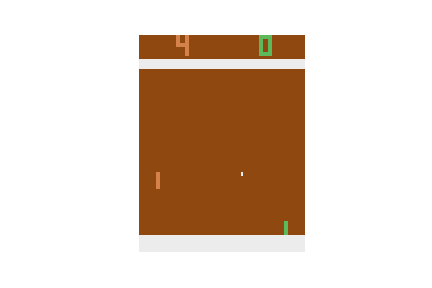
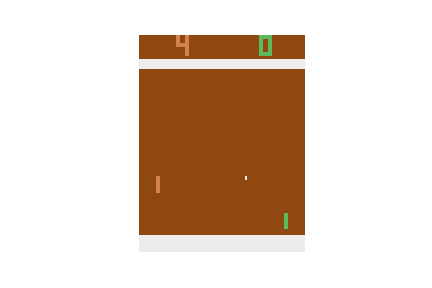
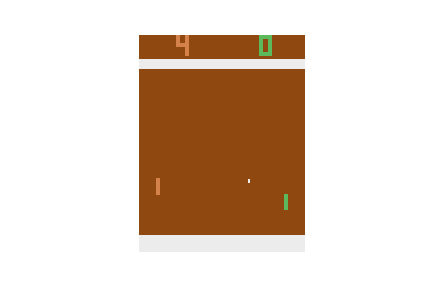
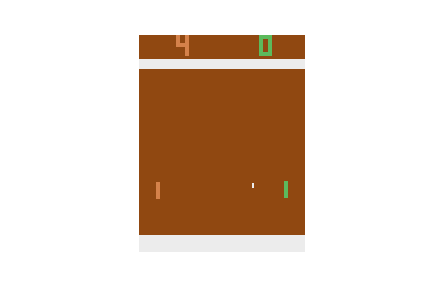
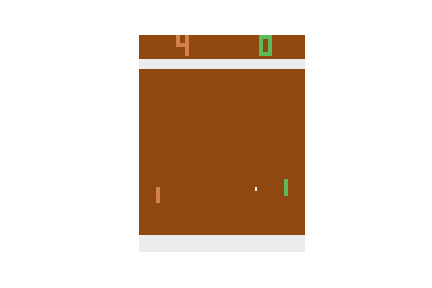
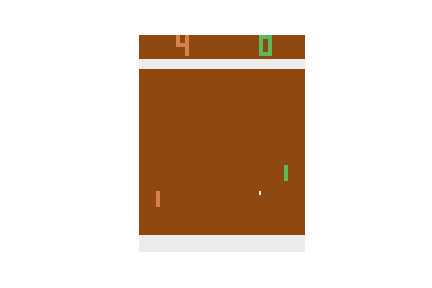
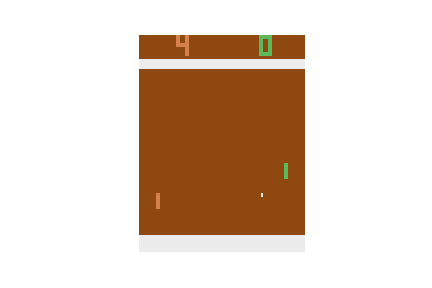
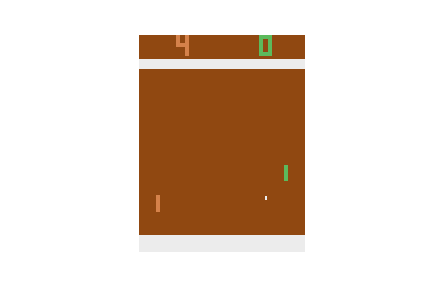
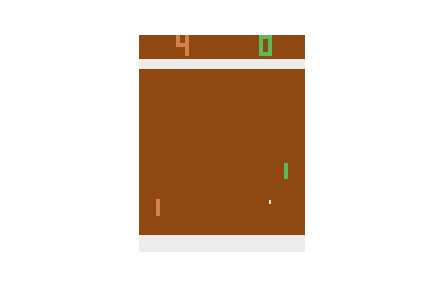
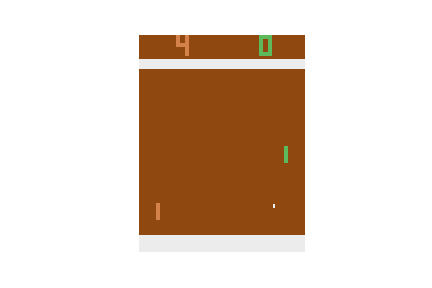
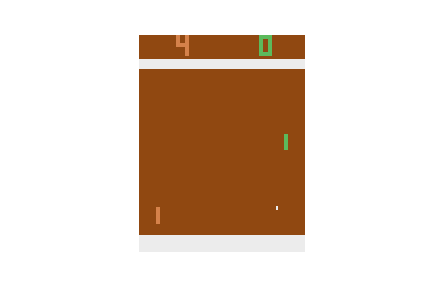
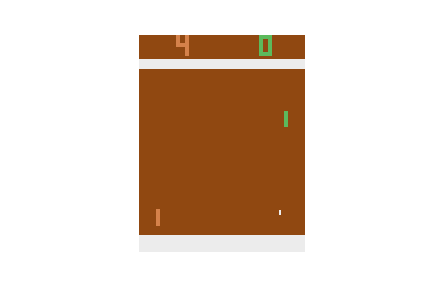
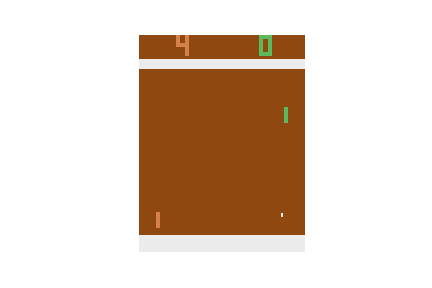
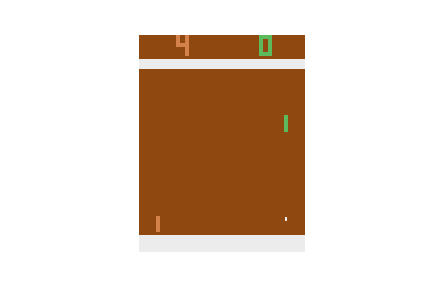
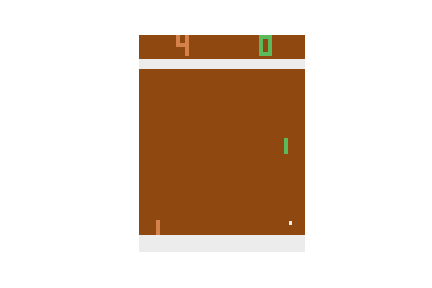
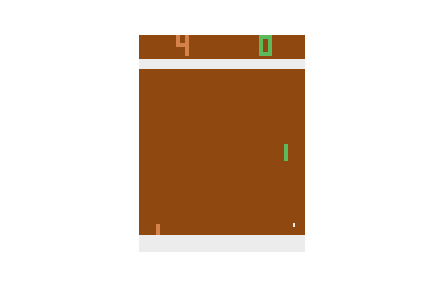
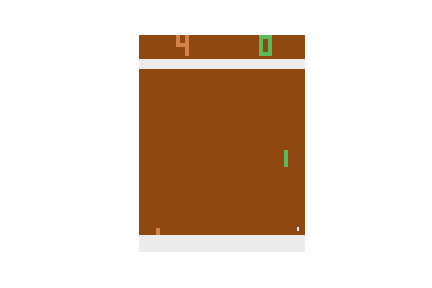
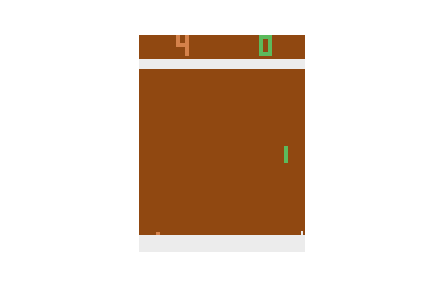
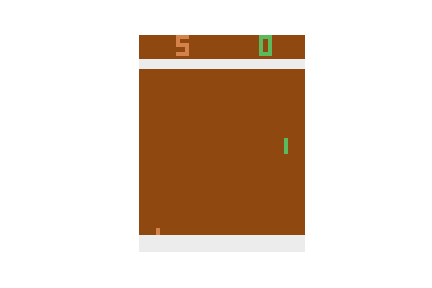
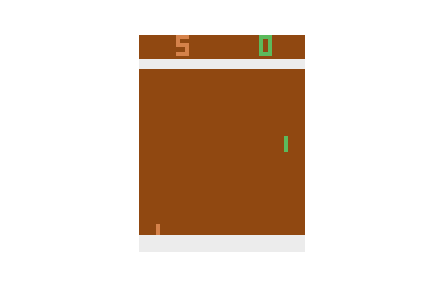
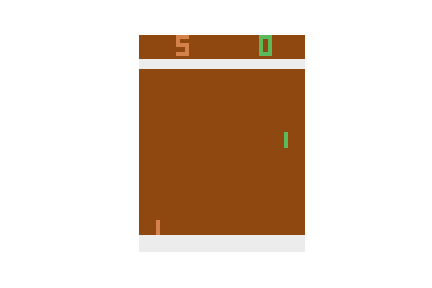
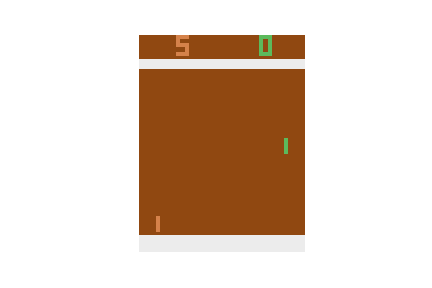
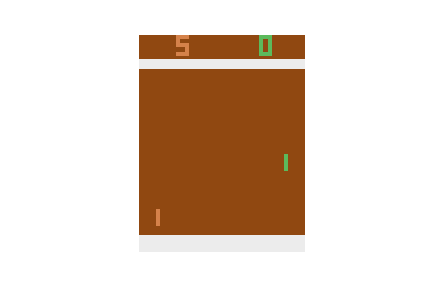
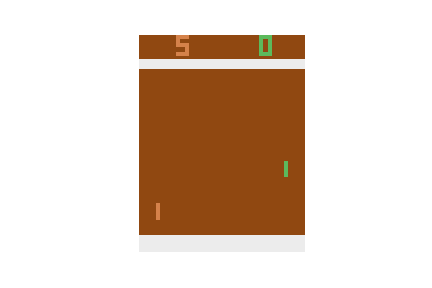
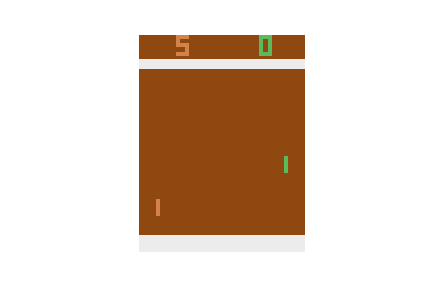
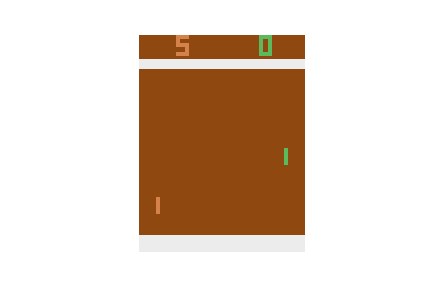
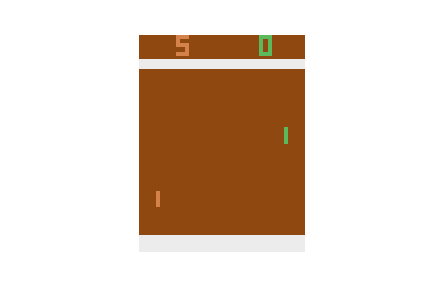
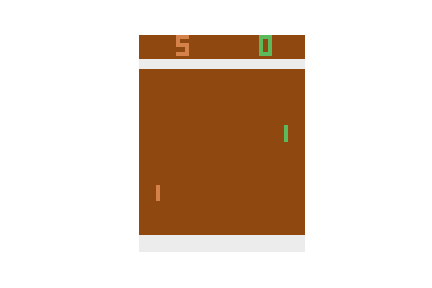
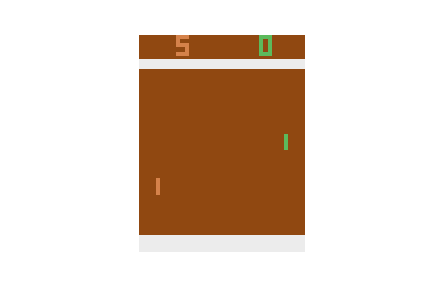
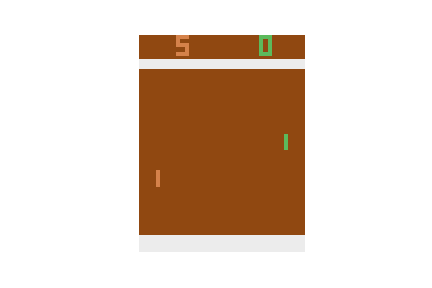
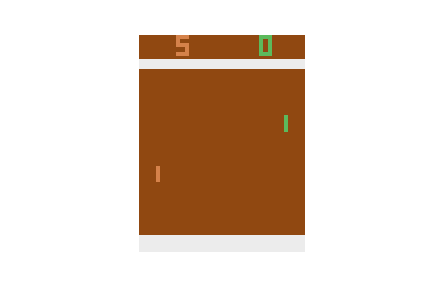
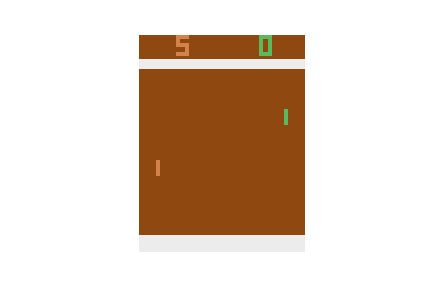
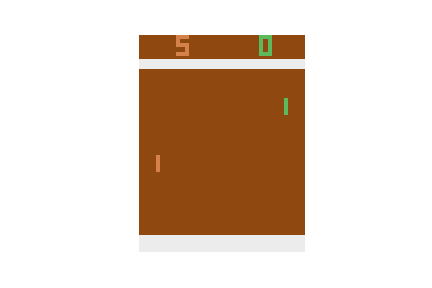
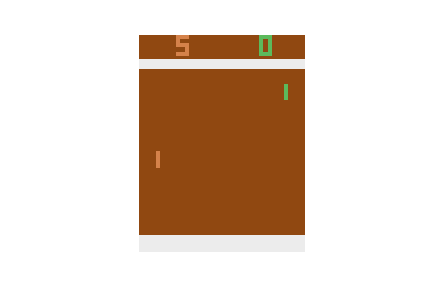
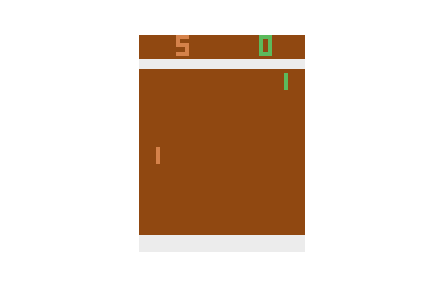
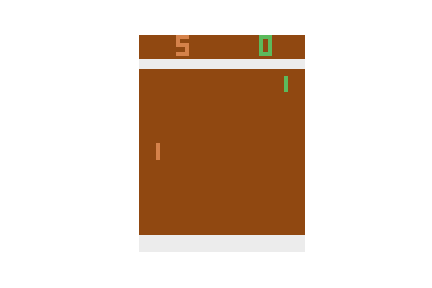
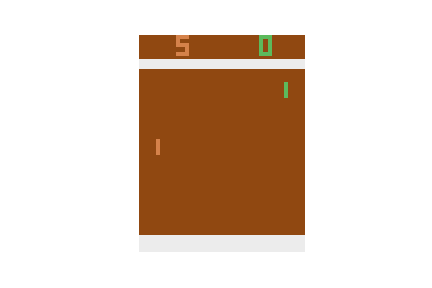
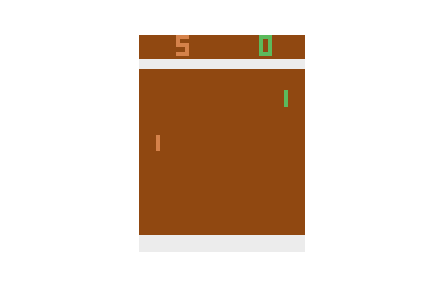
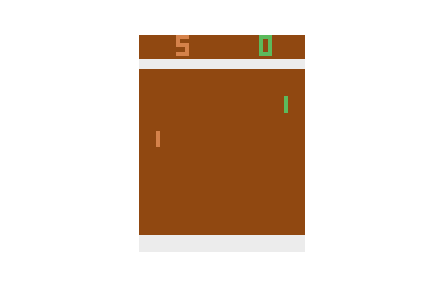
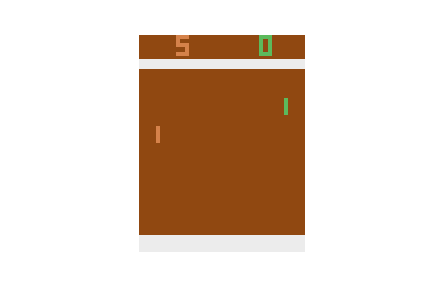
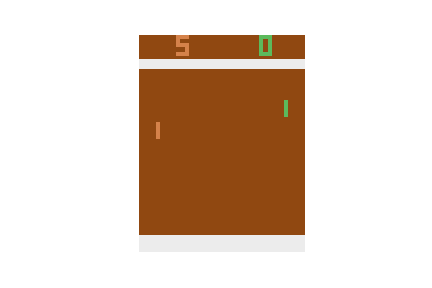
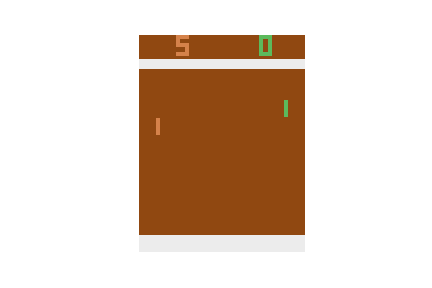
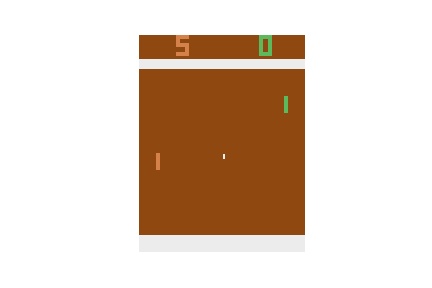
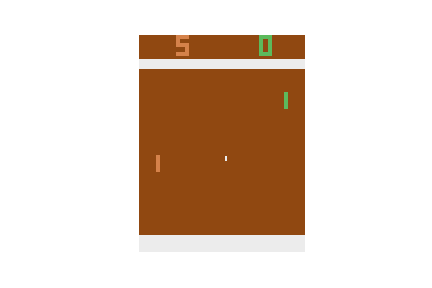
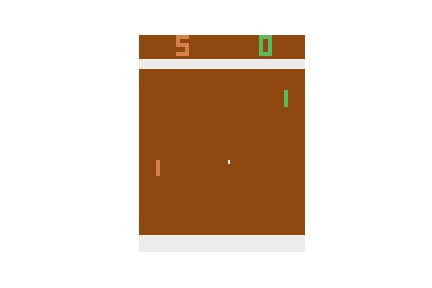
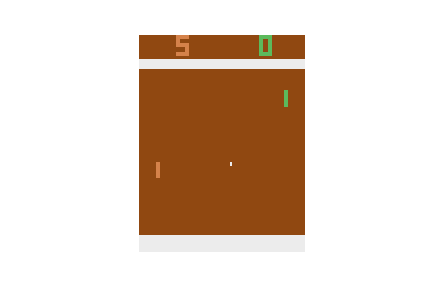
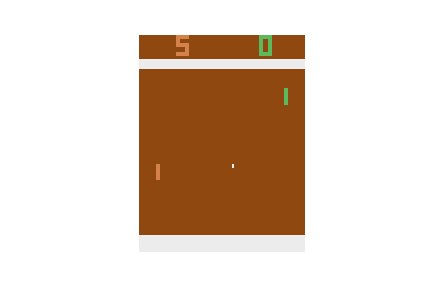
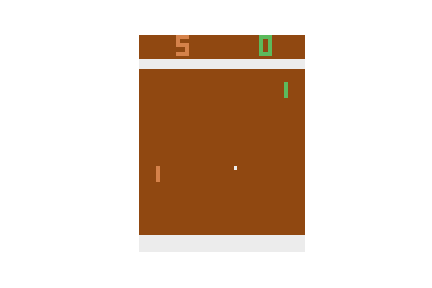
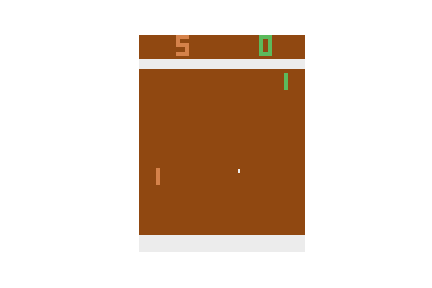
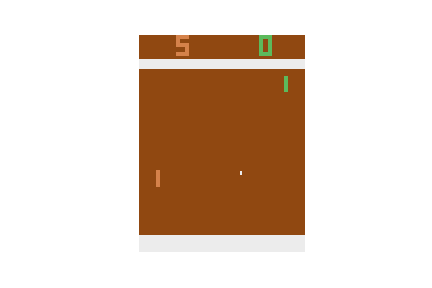
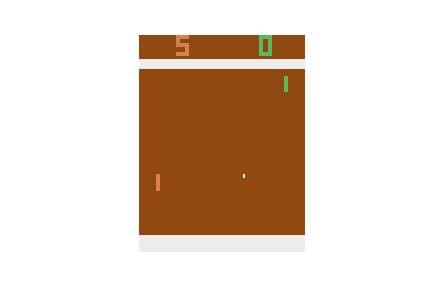
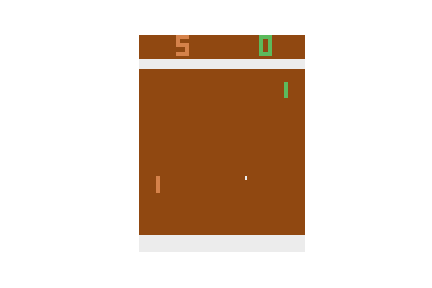
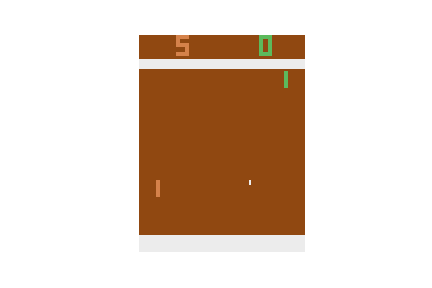
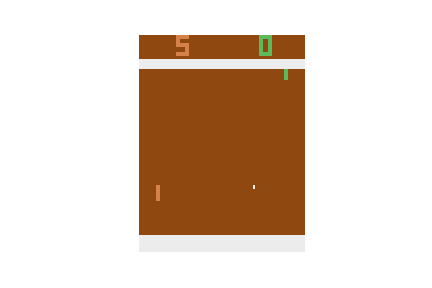
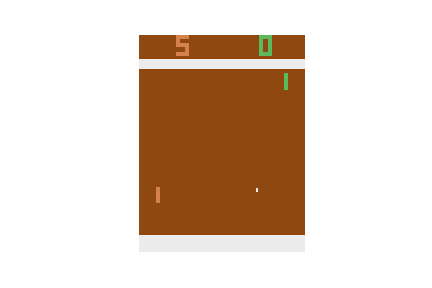
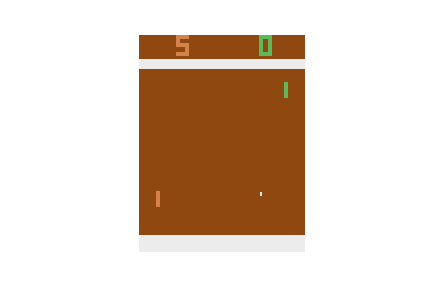
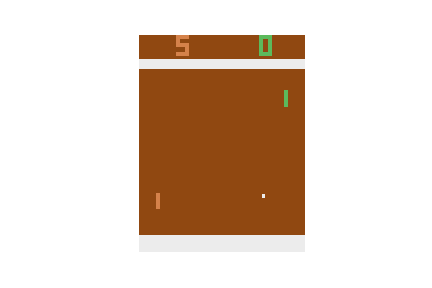
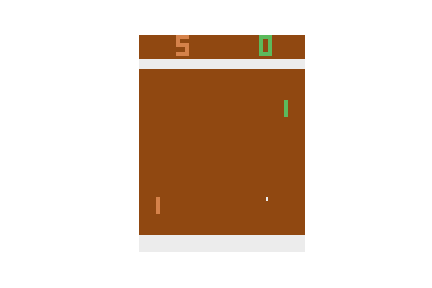
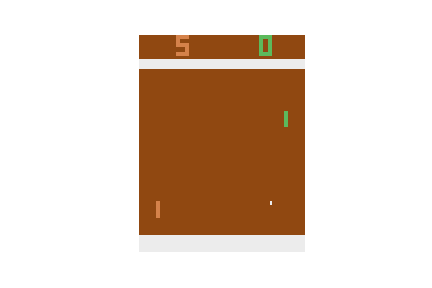
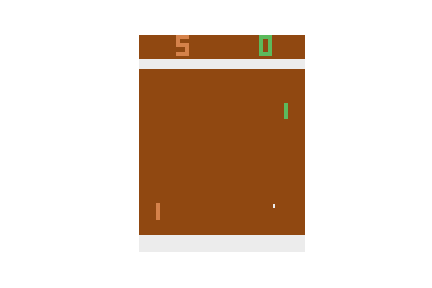
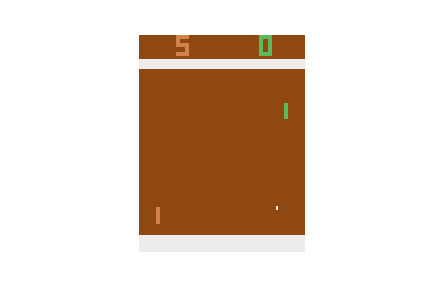
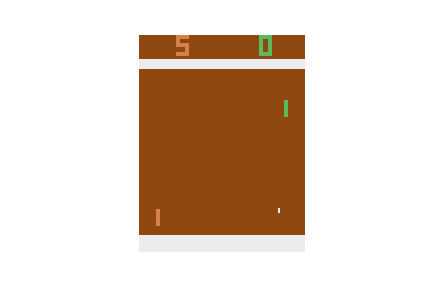
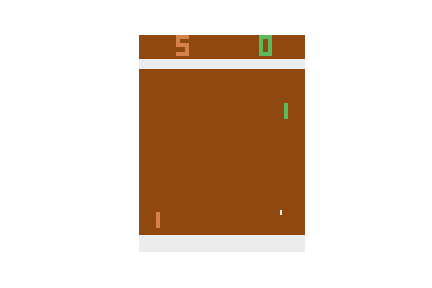
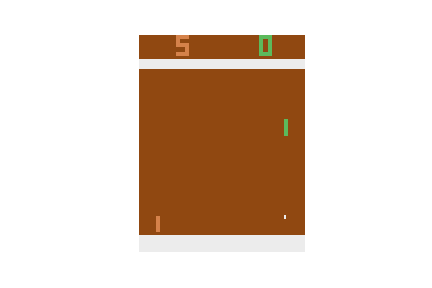
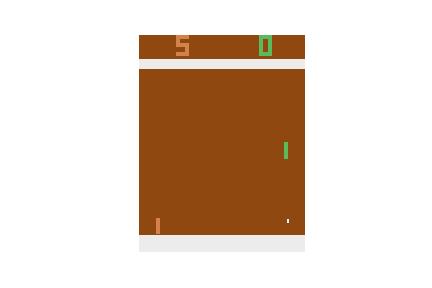
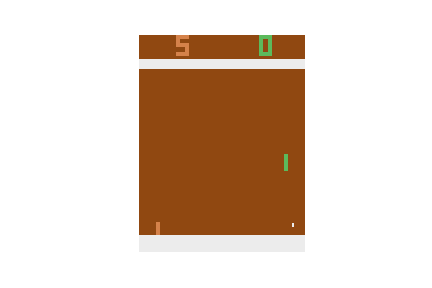
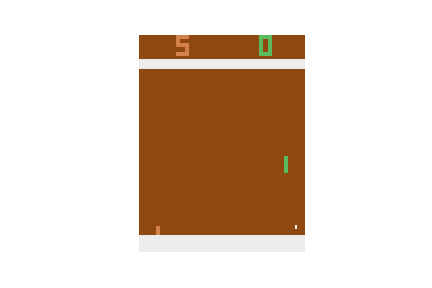
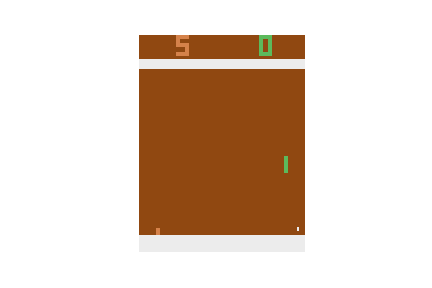
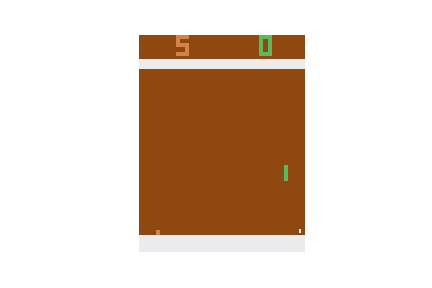
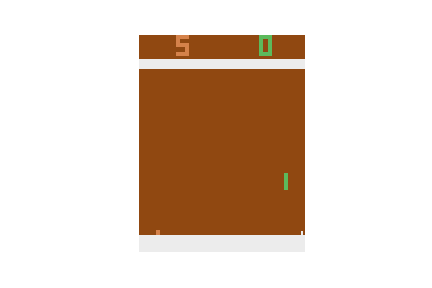
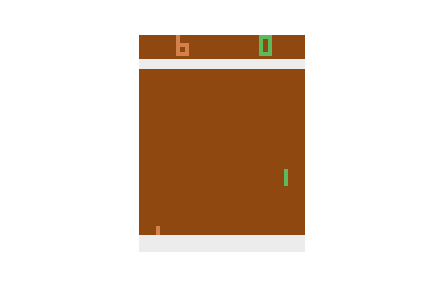
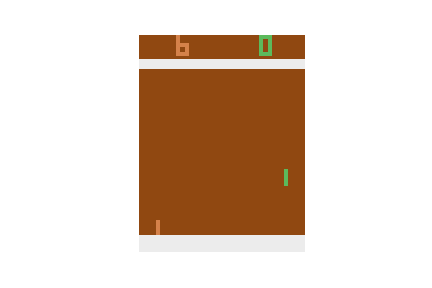
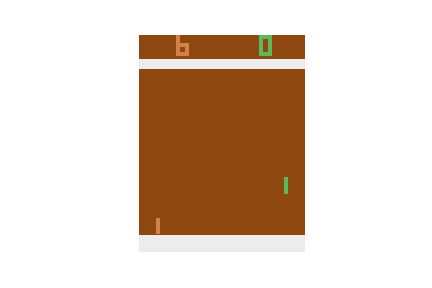
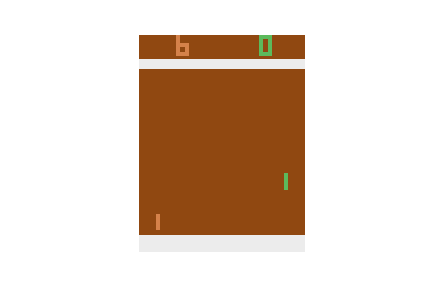
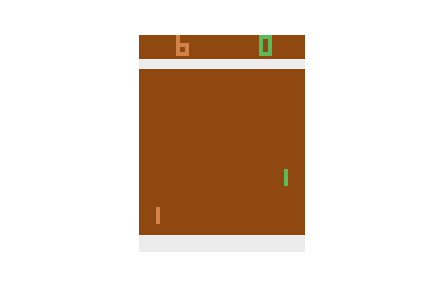
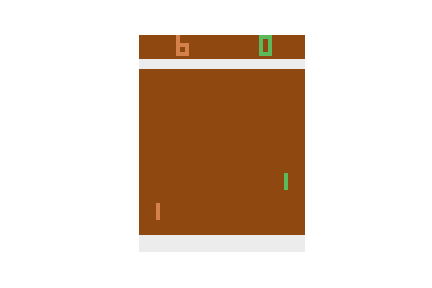
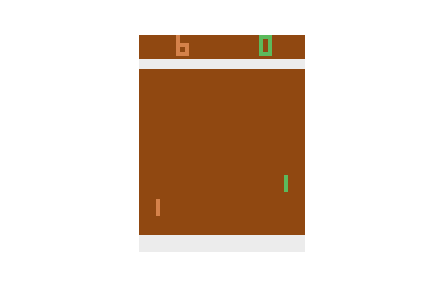
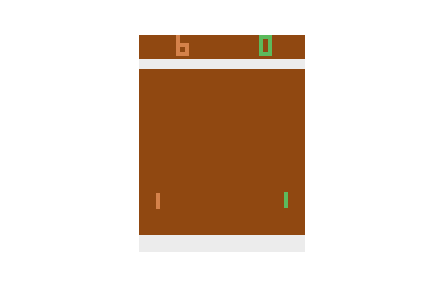
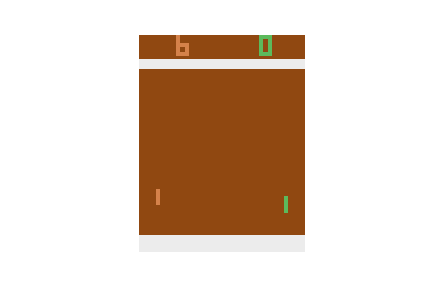
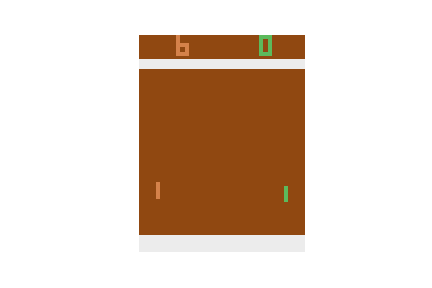
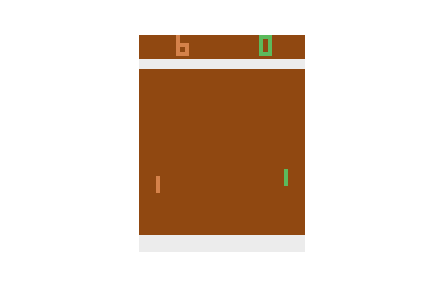
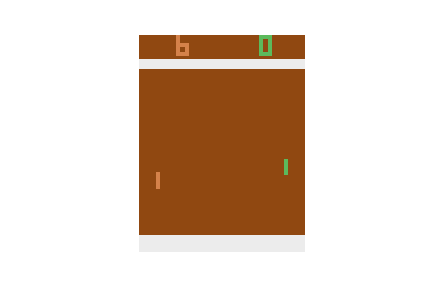
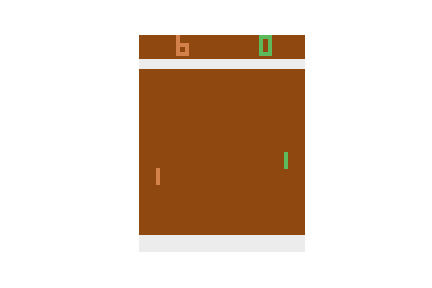
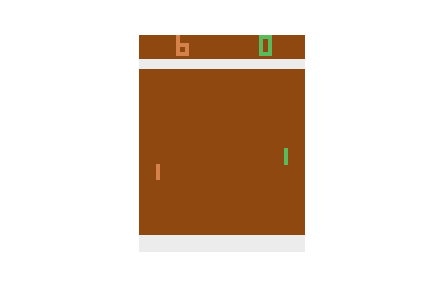
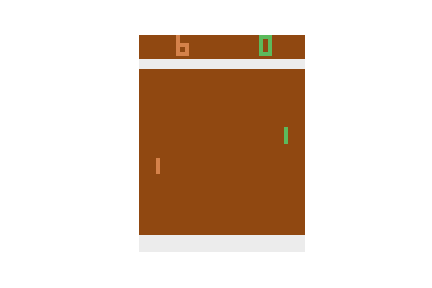
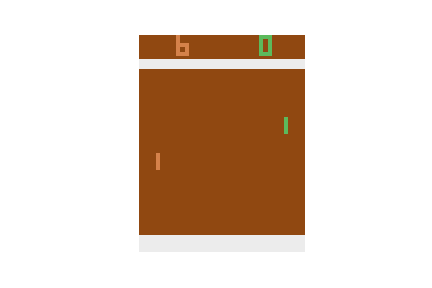
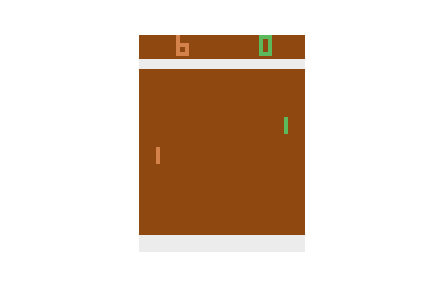
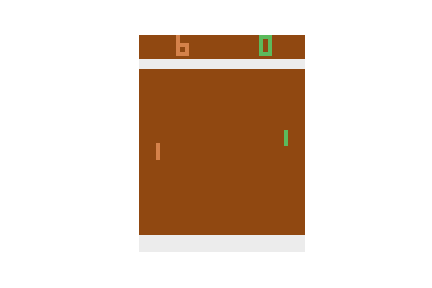
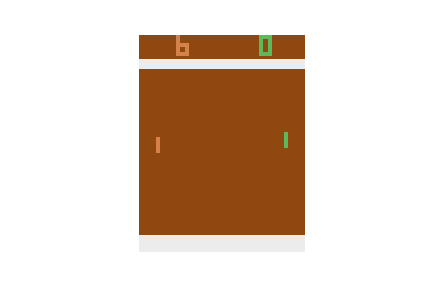
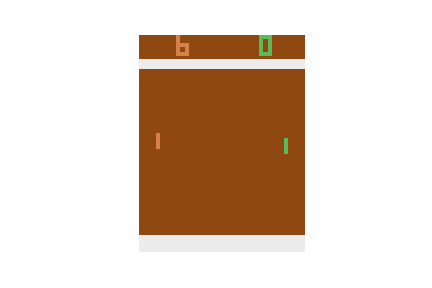
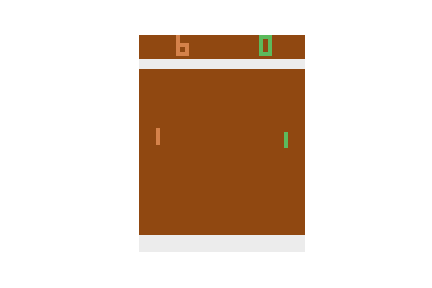
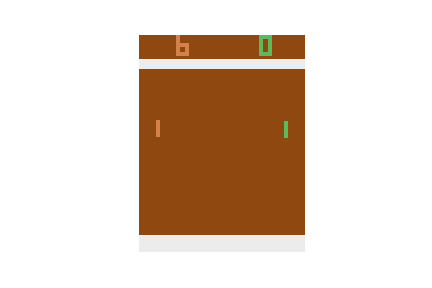
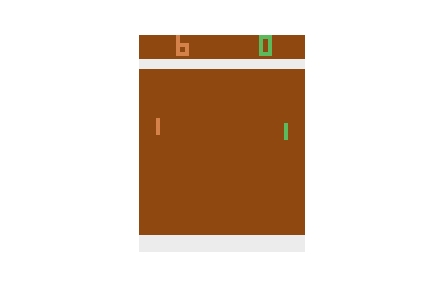
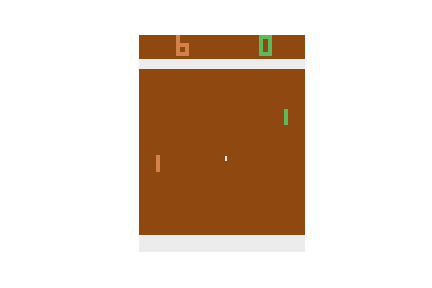
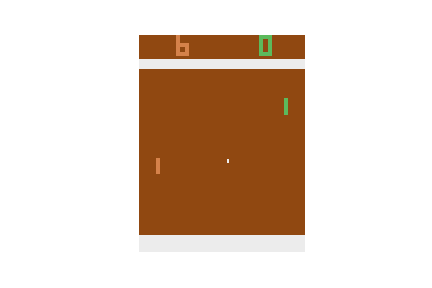
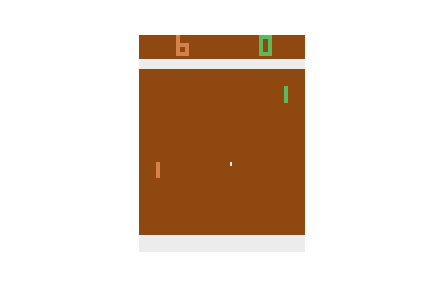
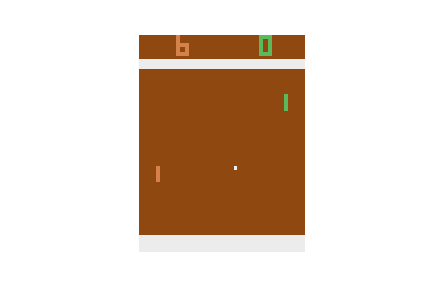
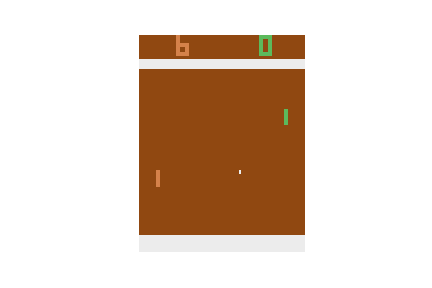
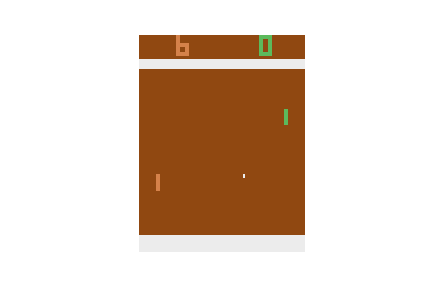
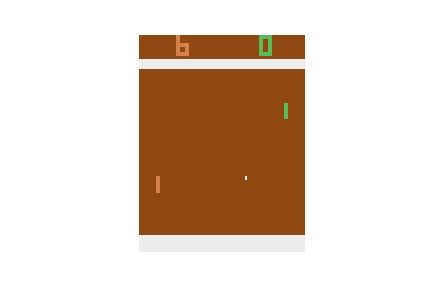
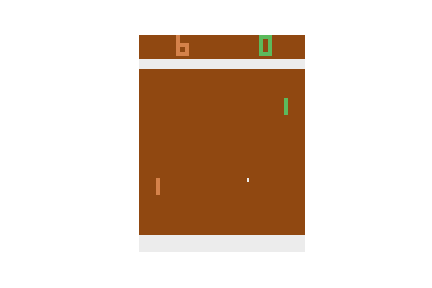
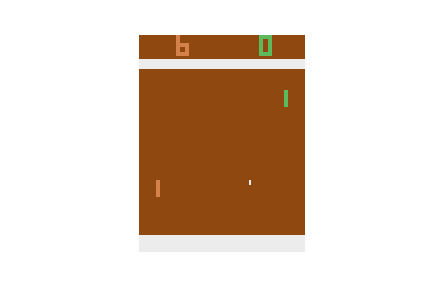
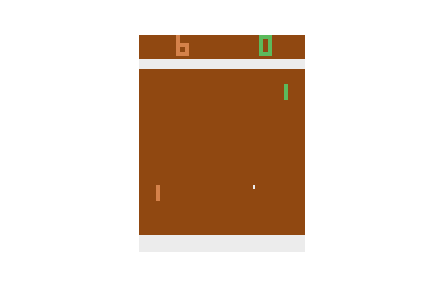
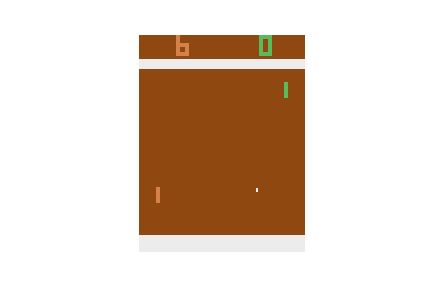
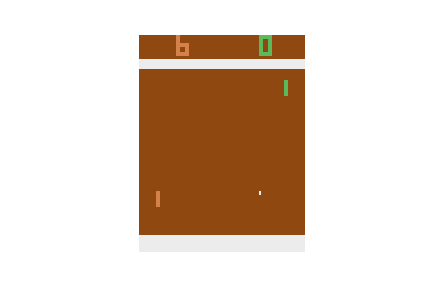
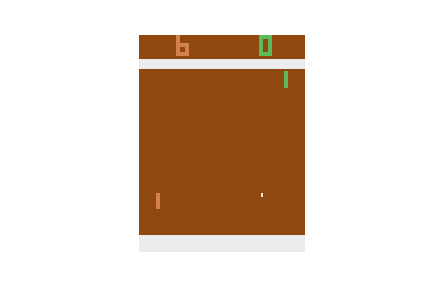
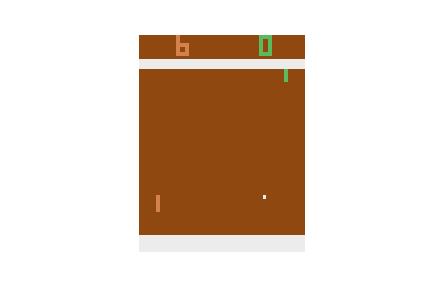
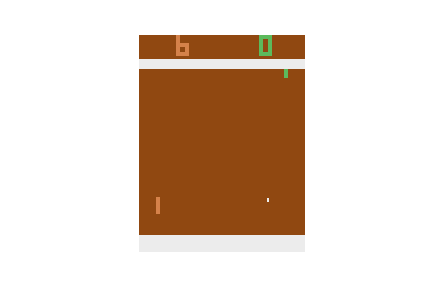
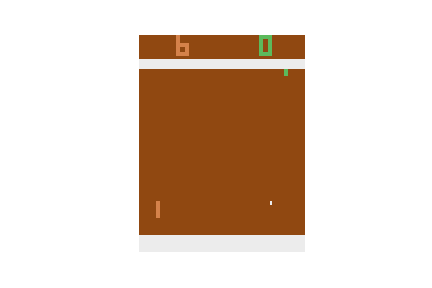
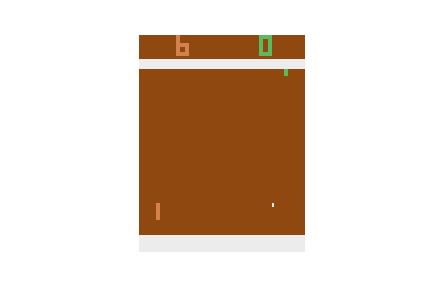
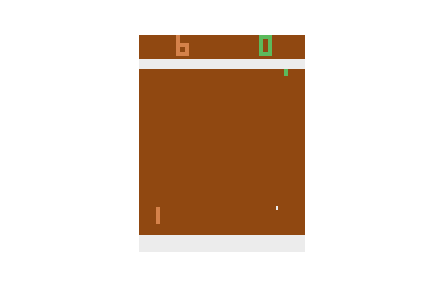
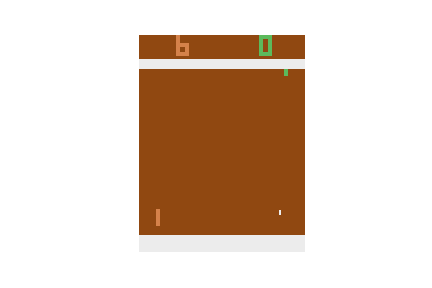
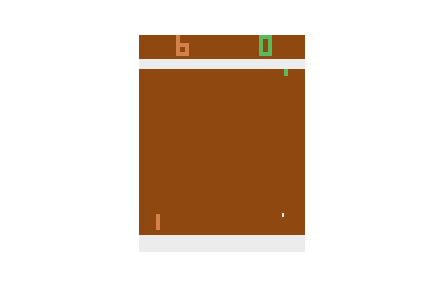
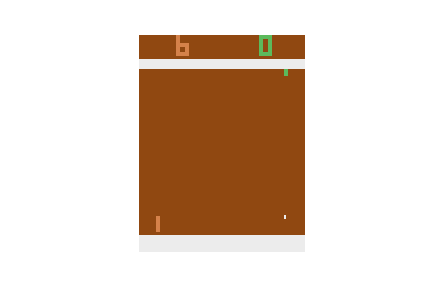
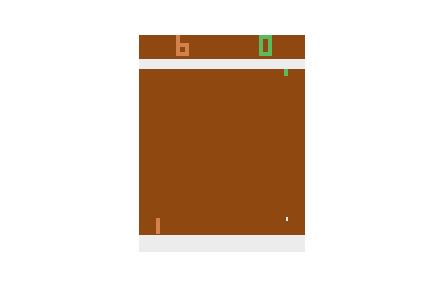
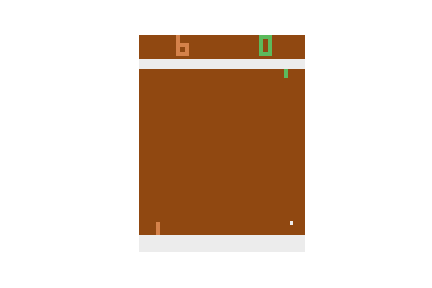
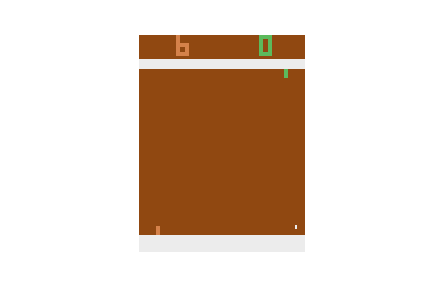
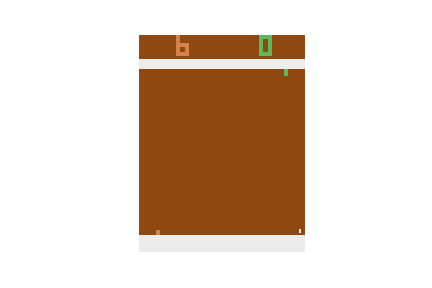
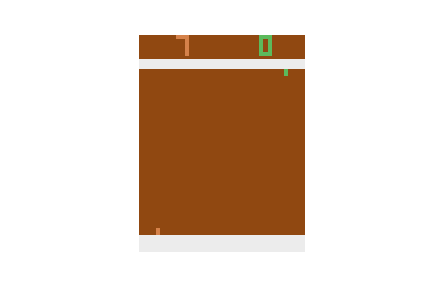
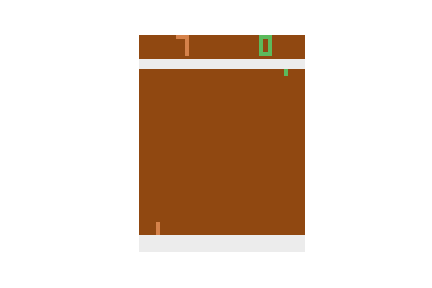
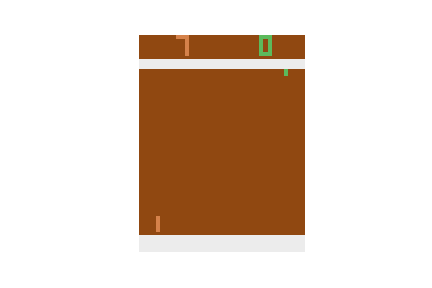
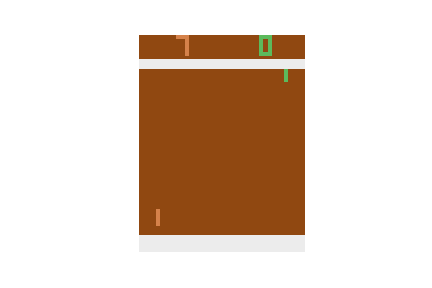
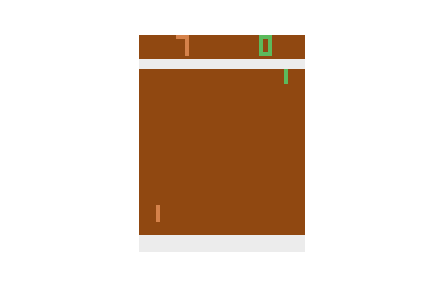
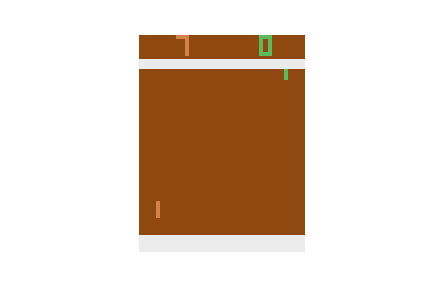
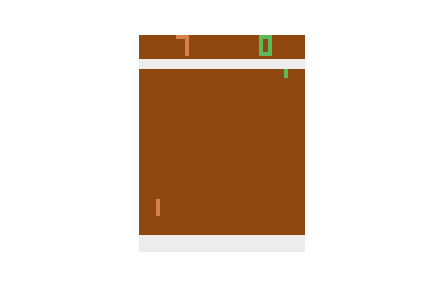
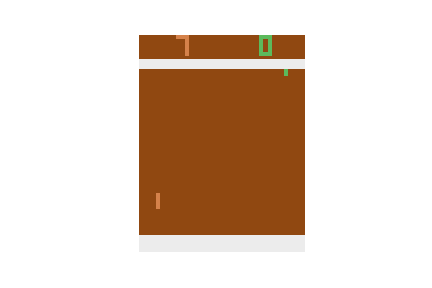
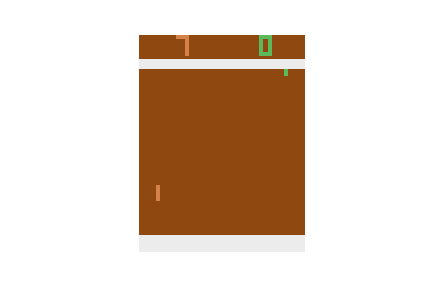
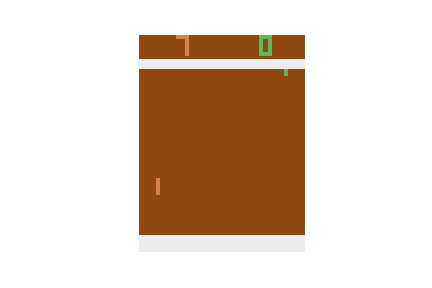
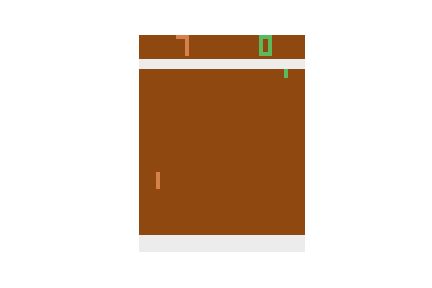
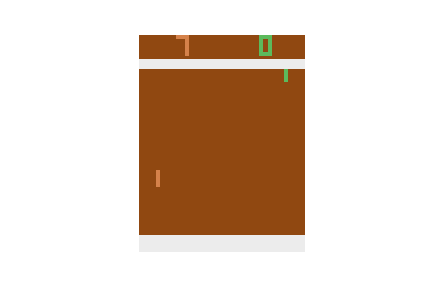
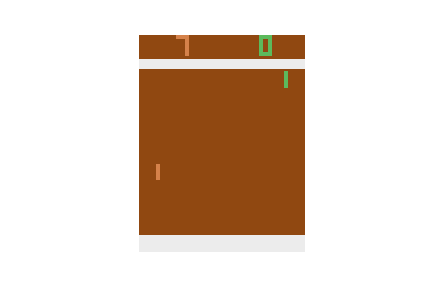
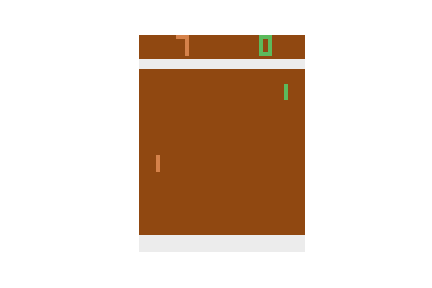
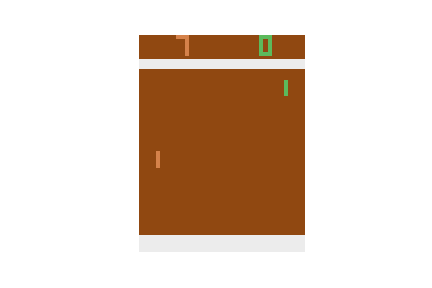
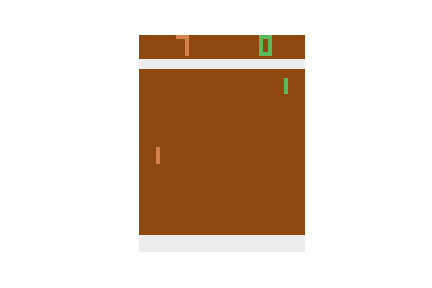
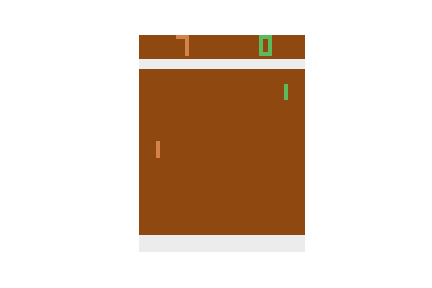
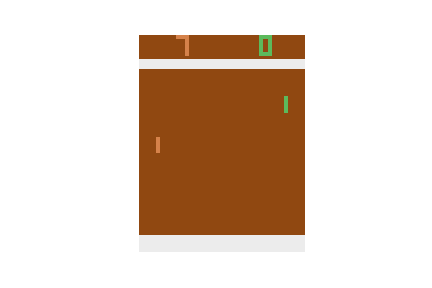
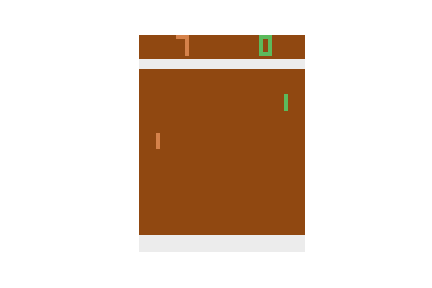
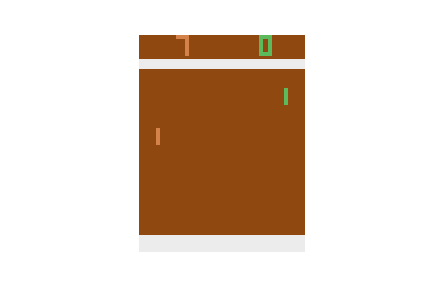
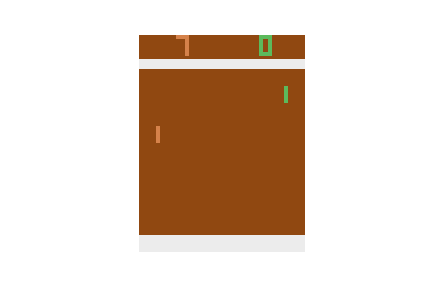
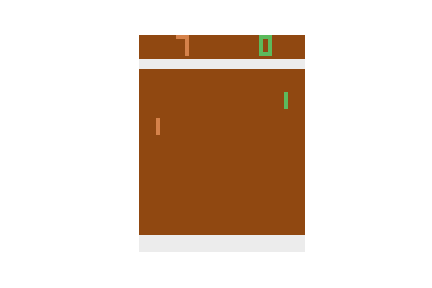
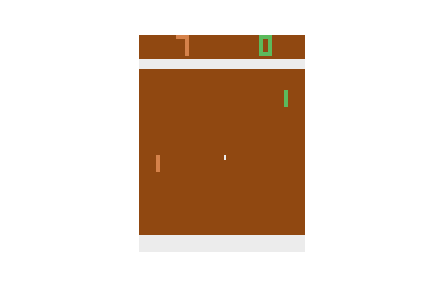
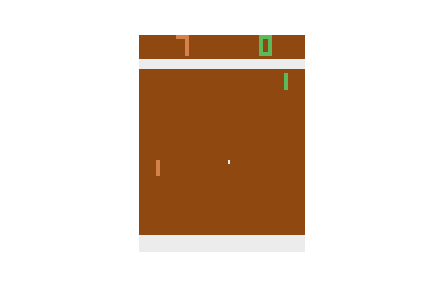
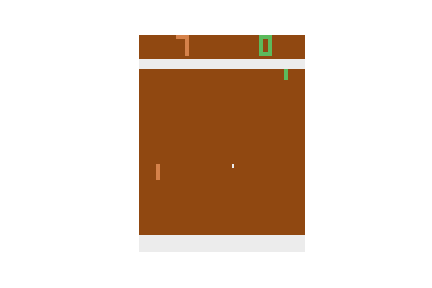
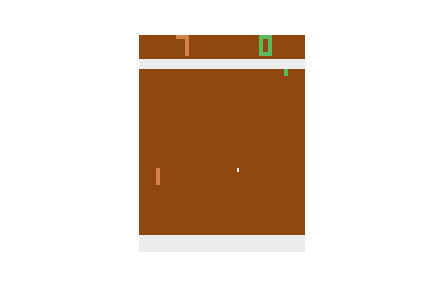
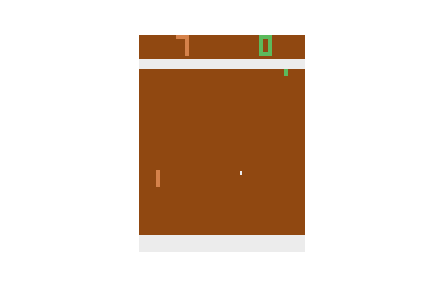
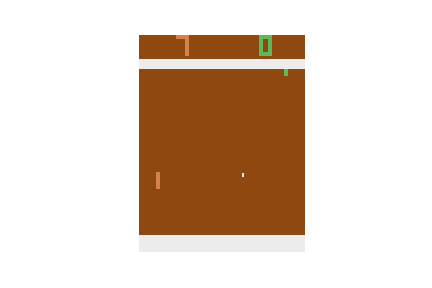
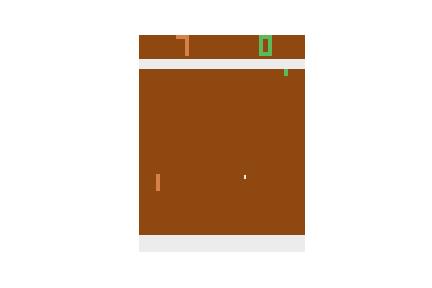
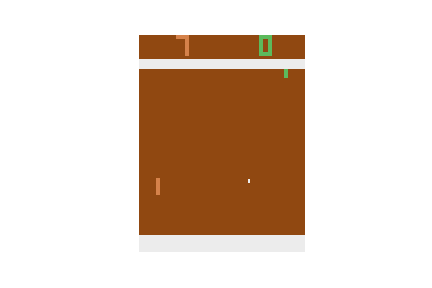
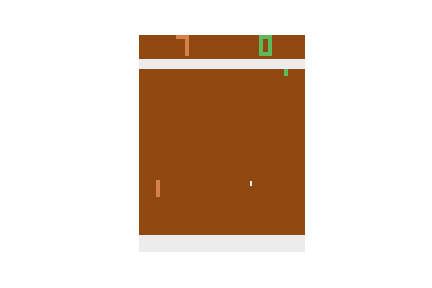

In [4]:
import gym # Uses OpenAI Gym
env = gym.make("Pong-v0")

number_time_points = 400

from src import draw as dr
from src import simulate as sim

%matplotlib inline

dr.display_frames(sim.simulate_with_random_policy(env, number_time_points))

In this video, the agent is in green. Once the agent decides which way to move the paddle, the game simulator executes the chosen action and updates the image on the screen. It also gives the agent a reward: +1 if the ball went past the opponent, -1 if the ball goes past the agent, and 0 otherwise. 

More formally, the game consists of a sequence of states $S^t$ (these will be closely related to the images), actions $A^t$, and rewards $R^t = R(S^t, A^t)$, all of which we model as random variables (hence the capital letters):

\begin{equation}
S^0 \xrightarrow[A^0, R^0]{} S^1 \xrightarrow[A^1, R^1]{} \mbox{ } \cdots 
\end{equation}




## Aside: Image processing

We strip down the images returned by the game simulator to the bare minimum needed to make informed decisions about which actions to take:


In [ ]:
image = env.render(mode='rgb_array')

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image)
ax1.set_title('original')
ax2.imshow(dr.process(image), cmap='Greys')
ax2.set_title('processed')

## Credit assignment problem 

Associated with each realization of a state-action pair $(s, a)$ is a reward $R(s,a) \in \{-1, 0, +1\}$. The goal is to find the policy $\pi(a\,|\,s)$, representing the probability of choosing action $a$ in the state $s$, that maximizes the expected value of a cumulative reward over all time steps. 

What the cumulative reward should actually be is open to debate. For example, the pong game simulator assigns a reward of 0 when the agent's paddle hits the ball, even if the result is to launch the ball on a trajectory that evades the opponents paddle. Arguably, then, a positive (not zero) reward should be assigned to the agent's volley. This ambiguity in how to assign credit is widespread in RL problems and is known as the *credit assignment problem*. 

In the Pong game, a trajectory (or episode) is defined to be the time course up to the point at which the first player wins 21 games. We define the cumulative reward associated with a trajectory to be 

\begin{equation} 
R_{tot} = \sum_{games: i} \left(\gamma^{T_i}  + \gamma^{T_i-1} + \cdots + \gamma + 1 \right) R^{T_1 + \sum_{j=2}^i (T_j+1)}
\end{equation}

where $T_i$ is the duration of game $i$, $\gamma<1$ is a discount factor, and $R^t = R(S^t, A^t)$ . In addition to assigning +1 when the ball goes past the opponent, for example, this formula assigns positive rewards to earlier timesteps in an exponentially decreasing manner. 



## Learning the optimal policy

There are two ways to learn the policy with greatest rewards. The first, Dynamic Programming, makes the strong assumption that the agent knows the environment before experiencing it. That is, given the current state and action, the future state can be computed (or learned). 

In the second approach, Policy Optimization (also called Direct Policy Search), the agent gains knowledge of the environment only through its experience of it. This amounts to taking completely random actions and measuring the rewards that they induce. One then gradually increases the frequency with which actions are taken that by chance turned out to be advantageous in certain environmental states. This process of blindly searching policy space and choosing directions that lead to better rewards is similar to natural selection, which randomly explores genotype space while selecting fitter individuals at the expense of those less fit. And just like natural selection leads to unexpected adaptations in biology, Policy Optimization often works surprisingly well (e.g. Cross Entropy Method). 

But can we do better by leveraging additional information about the reward, viewed as a function of states (and possibly actions)?  Policy Gradient Methods find optimal policies by making use of the gradient of the reward function with respect to the parameters of the policy function. 




## Policy gradient

Consider the gradient $\nabla_W E_\tau [R_{tot}]$, where $W$ is a tensor of weights that parametrize the policy function $\pi(a \, | \, s)$, and $\tau$ is a random variable denoting a trajectory $\{S^0, A^0; S^1, A^1; \cdots ; S^T\}$. Since $\nabla_W E_\tau [R_{tot}]$ indicates the direction in $W$-space in which $E_\tau[R_{tot}]$ increases most rapidly, the gradient-ascent algorithm,

\begin{equation} 
W \leftarrow W + \eta \nabla_W E_\tau[R_{tot}],
\end{equation}

converges to a set of parameters that define a locally optimal policy. A [clever algebraic manipulation](https://www.youtube.com/watch?v=yCqPMD6coO8&list=PLA89DCFA6ADACE599&index=20#t=23m) due to Williams allows us to write the gradient of the objective function in terms of the gradient of the policy

\begin{equation} 
\nabla_W E_\tau[R_{tot}] = E_\tau\left[\, R_{tot} \sum_{t=0}^T \nabla_W \log \pi(A^t \, | \, S^t)\,\right].
\end{equation}

In practice we estimate the expectation on the right-hand side by generating a small sample of trajectories and computing the sample mean. The variance in this estimator is proportional to the number of random variables involved ($T^2$), which can be reduced by a factor of two by a [clever algebraic trick](https://www.youtube.com/watch?v=oPGVsoBonLM#t=23m18s) to obtain: 

\begin{equation} 
\nabla_W E_\tau[R_{tot}] = E_\tau\left[\, \sum_{t=0}^T \nabla_W \log \pi(A^t \, | \, S^t) 
\sum_{u=t}^T 
R_{\text{disc}}^{u} \,\right],
\end{equation}

where $R^{t}_{\text{disc}}$ is the discounted reward we have chosen to assign to time step $t$. 

The expression on the right-hand side makes intuitive sense: it tells us that we should shift $W$ in the direction that increases the probability of actions $\left(\nabla_W \log \pi\right)$ that result in postive cumulative future discounted rewards $\left(\sum_{u=t}^T 
R_{\text{disc}}^{u}\right)$. Andrej Karpathy discusses this in more detail in his [blog](http://karpathy.github.io/2016/05/31/rl/) in the section entitled "Deriving Policy Gradients". 




## Modeling the policy function

To compute a formula for the policy gradient, $\nabla_W \log\pi$, we need a model for the policy function $\pi(a \, | \, s)$. 
Since there are only two possible actions, the policy function can be specified by the probability of moving the paddle up, $p(s)$:

\begin{eqnarray} 
\pi(\uparrow | \, s) & = & p(s) \\
\pi(\downarrow | \, s) & = & 1 - p(s).
\end{eqnarray}

Following [Andrej Karpathy](http://karpathy.github.io/2016/05/31/rl/), we use a three-layer feedforward neural network to model the function $p(s)$. 


![](images/NN_with_weights-01.png)


A static image lacks important information for deciding how to move the paddle: the ball velocity. To extract some of that information, we will pass the *difference of successive  images* to the policy function. In other words, we choose the input nodes $s_j$ to be the difference of a pair of successive vectorized processed images. 

The layers of the neural network are connected via two weight matrices, $W^1$ and $W^2$ (no biases), whose initial values are set using Xavier normalization. Michael Nielsen gives a [nice discussion](http://neuralnetworksanddeeplearning.com/chap3.html#weight_initialization) of how Xavier normalization prevents neuron saturation and slowdown of learning. The math justifying the procedure can be found [here](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization).




## Forward propagation 

The process of computing $p(s)$ is referred to as forward propagating through the network. The activations of the neurons in the hidden layer, $h_i$, is given by

\begin{equation} 
h = g(W^1s)
\end{equation} 

where $g(z)$ is the sigmoid function, and $s$ and $h$ are column vectors. The activation of the output neuron is

\begin{equation} 
p = g(W^2h).
\end{equation} 




## Backward propagation 

Having set up a model for the policy we may now compute its gradient, $\nabla_W \pi( a\, | \, s)$. Considering the two possible values of $a$ separately, and using the chain rule of differentiation, one may show that the matrix representing the gradient of the policy with respect to $W^2$ is

\begin{equation} 
\nabla_{W^2} \pi( a\, | \, s) = \delta^3(s,a) h^{\text{Tr}}(s) 
\end{equation} 

where Tr denotes transpose and 

\begin{eqnarray} 
\delta^3(s,a) & = & y(a) - p(s) \\
y(a) & = & 
\left\{ 
\begin{array}{cc} 
1 & \text{if } a = \uparrow\\
0 & \text{if } a = \downarrow
\end{array}
\right.
\end{eqnarray} 

One way to interpret $\delta^3$ is a measure of how sensitive the cross entropy $H = -y\log p - (1-y)\log(1-p)$ is to changes in the weighted input, $z^3 = W^2h$, to the output neuron: 

\begin{equation} 
\delta^3 = -\nabla_{z^3} H.
\end{equation} 

Our task is to compute the reward-weighted sum of policy gradients $G_{W} = \sum_{t=0}^T \nabla_{W} \log \pi(a^t \, | \, s^t) \, R_{\text{part}}^{t}$ for a sample trajectory $\{ s^0, a^0; s^1, a^1; \cdots ; s^T \}$, where the partial sum of future discounted rewards is $R_{\text{part}}^{t} = \sum_{u=t}^T R_{\text{disc}}^{u}$. Using our expression for $\nabla_{W^2} \pi( a\, | \, s)$, we can now write

\begin{equation} 
\boxed{
G_{W^2} = \left(\hat{\delta^3}\right)^{\text{Tr}} H
}
\end{equation} 

where

\begin{equation} 
H = 
\left[
\begin{array}{rcl} 
\cdots & h^0 & \cdots\\
\cdots & h^1 & \cdots\\
 & \vdots & \\
\cdots & h^T & \cdots\\ 
\end{array} 
\right],
\end{equation}

and the notation $\cdots h^t \cdots$ indicates that the vector of hidden-layer activations at time $t$, $h^t$, should be written as a row vector. Also, 

\begin{equation} 
\hat{\delta^3} = 
\left[
\begin{array}{c} 
\delta^{3,0} \, R^0_{\text{part}} \\
\delta^{3,1} \, R^1_{\text{part}} \\
 \vdots\\
\delta^{3,T} \, R^T_{\text{part}} 
\end{array} 
\right],
\end{equation}

where $\delta^{3,t} = \delta^3(s^t, a^t)$. 

A similar but more involved calculation yields

\begin{equation} 
\boxed{
G_{W^1} = \left(\hat{\delta^2}\right)^{\text{Tr}}  S
}
\end{equation} 
where 

\begin{equation} 
S = 
\left[
\begin{array}{rcl} 
\cdots & s^0 & \cdots\\
\cdots & s^1 & \cdots\\
 & \vdots & \\
\cdots & s^T & \cdots\\ 
\end{array} 
\right]
\end{equation}

is the matrix formed by vertically stacking the states at each time point, with each state  written as a row vector. 
The error term $\hat{\delta^3}$ is 'back-propagated' to a similar error term, 


\begin{equation} 
\hat{\delta^2} = \left( \hat{\delta^3} \otimes W^2 \right) \odot H \odot \left( 1 - H \right),
\end{equation} 

associated with variations in inputs to the hidden layer. In this formula, the Outer Product is defined by

\begin{equation} 
(u \otimes v)_{ij} = u_i v_j,
\end{equation}

and the Hadamard Product by

\begin{equation} 
(A \odot B)_{ij} = A_{ij} B_{ij} .
\end{equation} 

Finally, the weights of the neural network are updated using a mini-batch of trajectories: 

\begin{equation} 
\boxed{
W \leftarrow W + \alpha \sum_{\tau_1, \tau_2, \cdots, \tau_n} G^{\tau_n}_W.
}
\end{equation} 


In [7]:
from src import policy

gamma=0.95
alpha=0.1
weights_filename='weights.cPickle'

policy.train(gamma, alpha, weights_filename)

[2017-09-06 18:20:50,911] Making new env: Pong-v0


trajectory 0: game finished, reward: -1.000000
trajectory 0: game finished, reward: 1.000000 !!!!!!!!
trajectory 0: game finished, reward: -1.000000
trajectory 0: game finished, reward: 1.000000 !!!!!!!!
trajectory 0: game finished, reward: -1.000000
trajectory 0: game finished, reward: -1.000000
trajectory 0: game finished, reward: -1.000000
trajectory 0: game finished, reward: -1.000000
trajectory 0: game finished, reward: -1.000000
trajectory 0: game finished, reward: -1.000000
trajectory 0: game finished, reward: -1.000000
trajectory 0: game finished, reward: -1.000000
trajectory 0: game finished, reward: -1.000000
trajectory 0: game finished, reward: -1.000000
trajectory 0: game finished, reward: -1.000000
trajectory 0: game finished, reward: -1.000000
trajectory 0: game finished, reward: -1.000000
trajectory 0: game finished, reward: -1.000000
trajectory 0: game finished, reward: -1.000000
trajectory 0: game finished, reward: -1.000000
trajectory 0: game finished, reward: -1.0000

KeyboardInterrupt: 

[2017-09-06 18:21:38,304] Making new env: Pong-v0



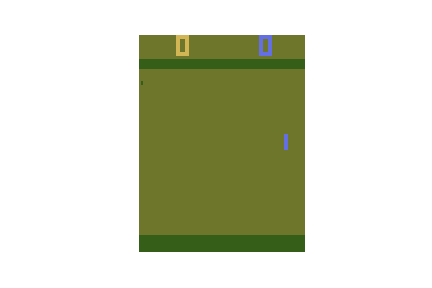
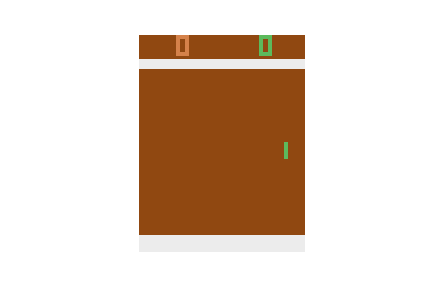
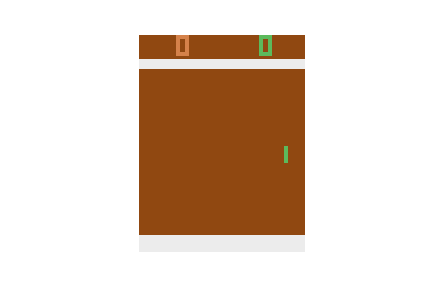
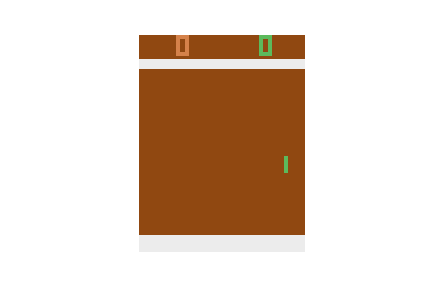
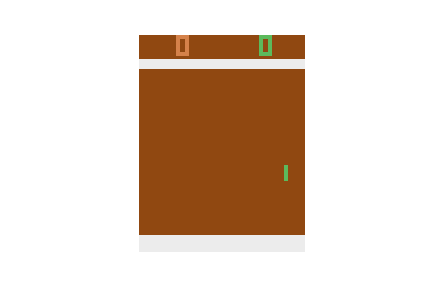
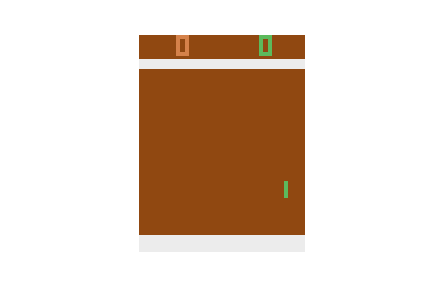
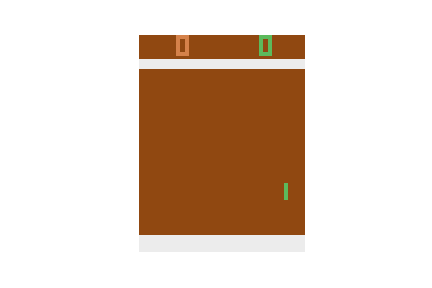
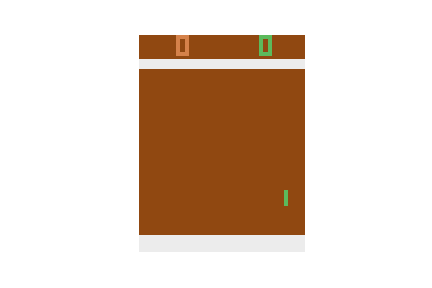
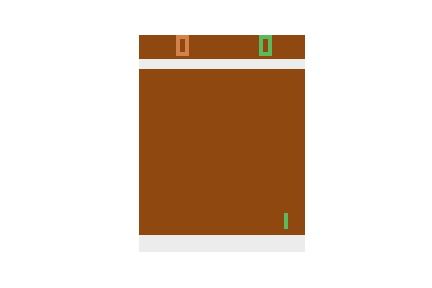
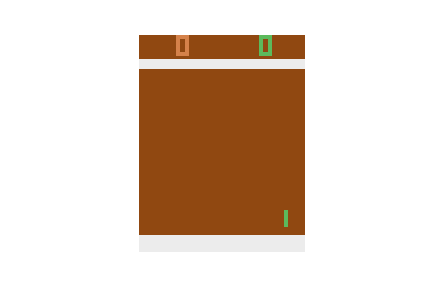
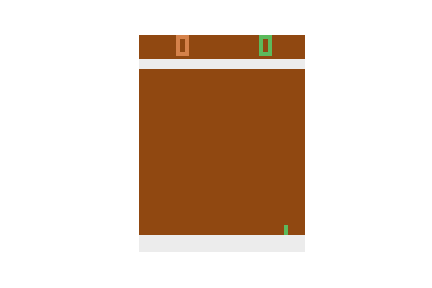
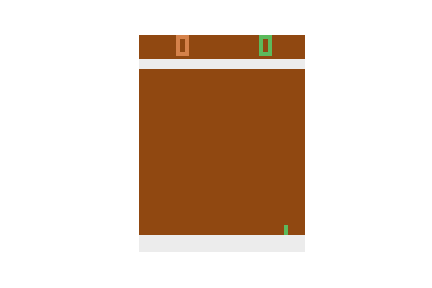
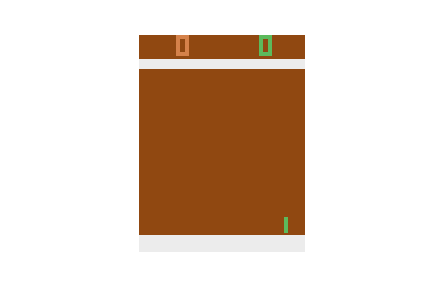
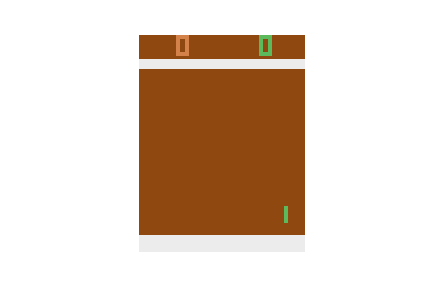
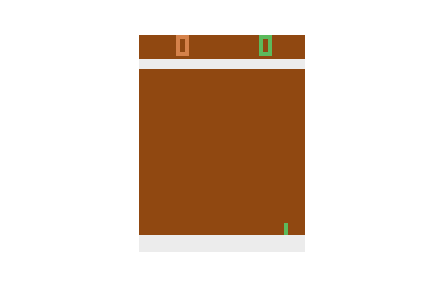
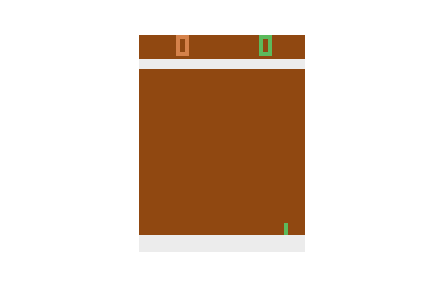
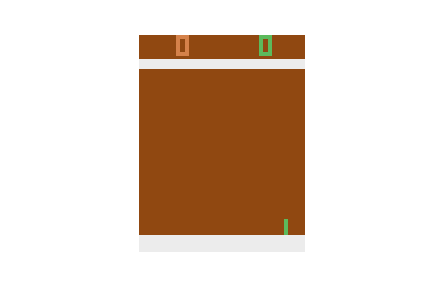
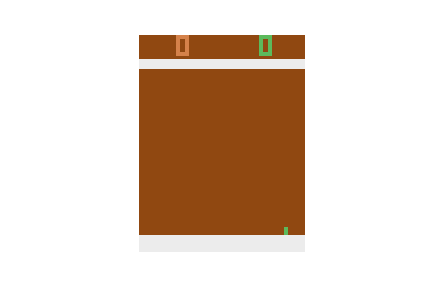
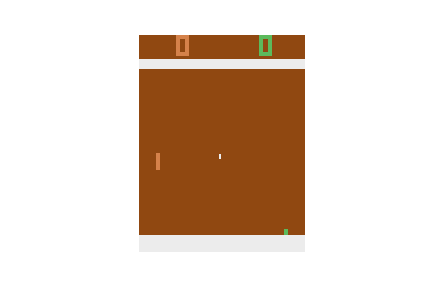
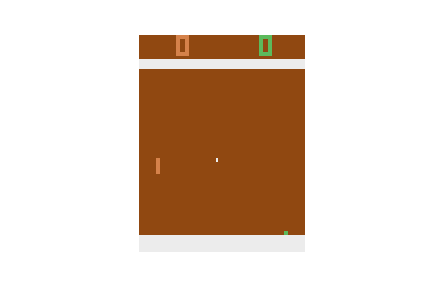
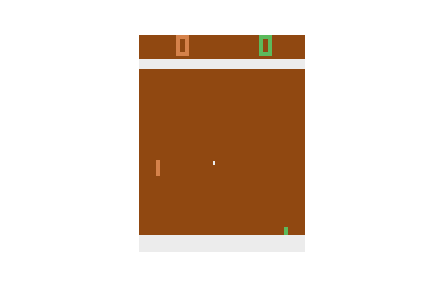
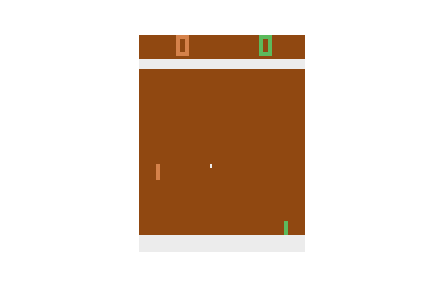
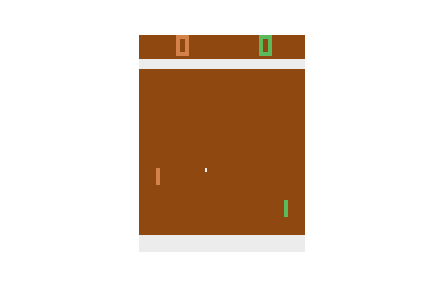
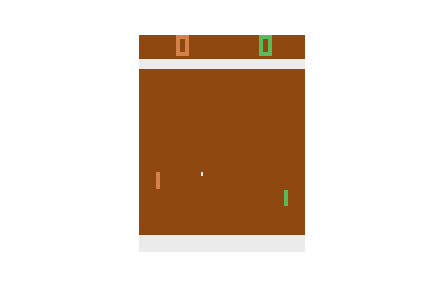
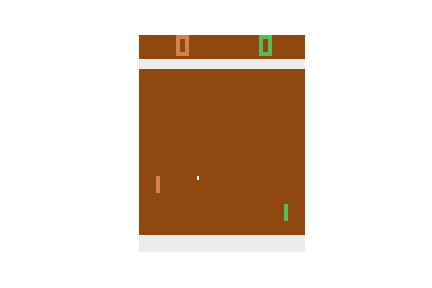
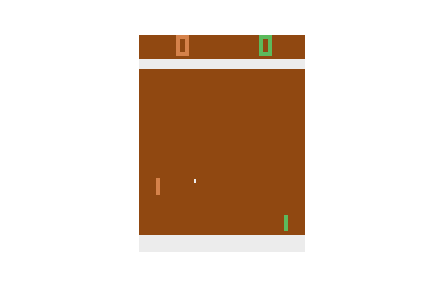
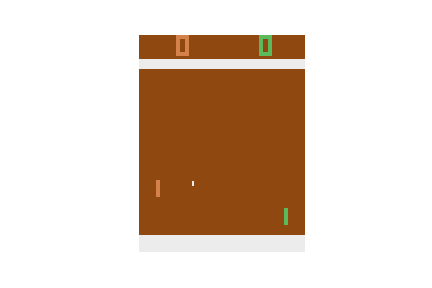
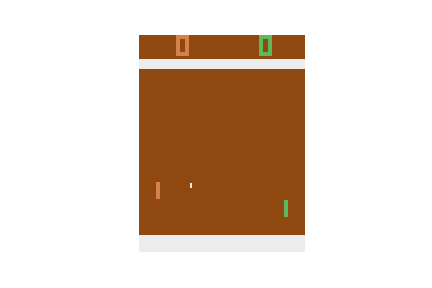
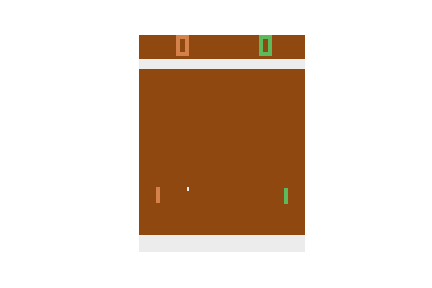
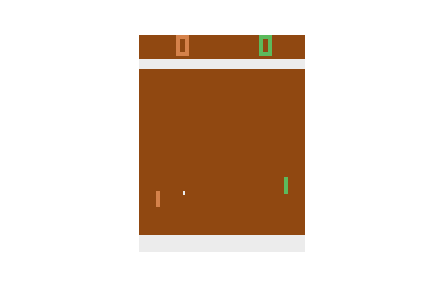
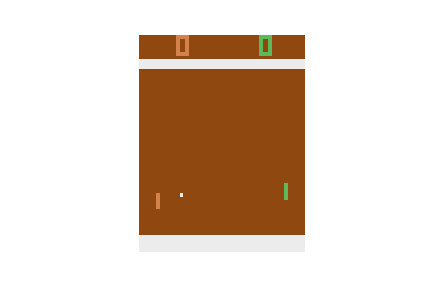
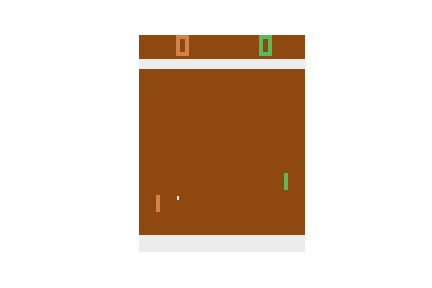
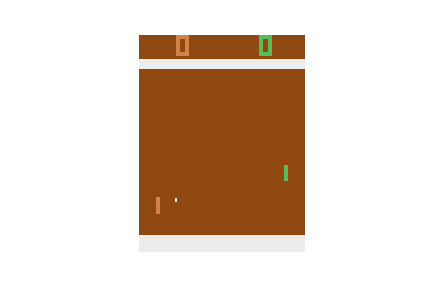
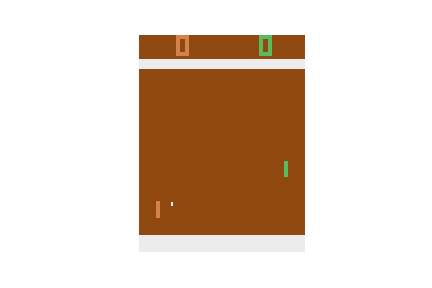
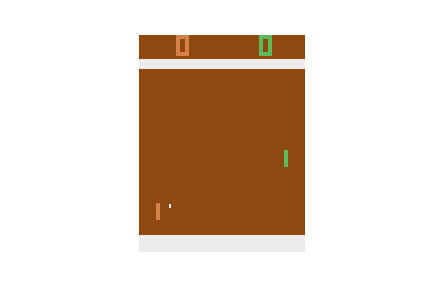
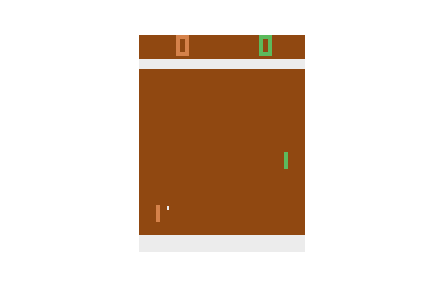
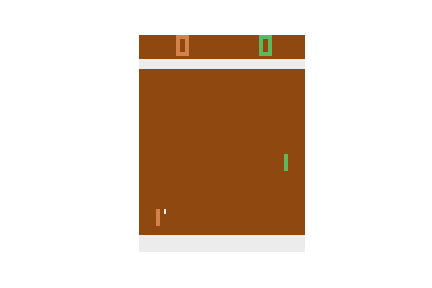
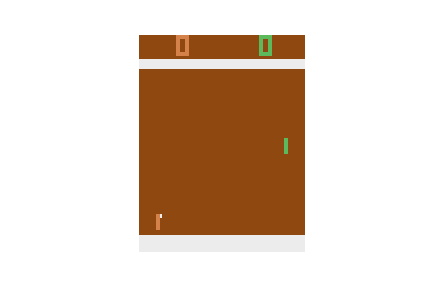
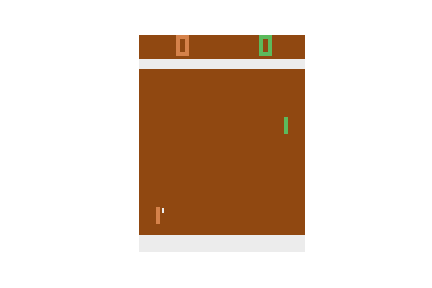
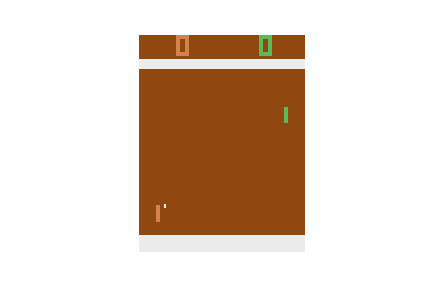
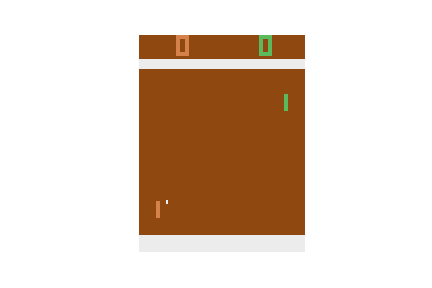
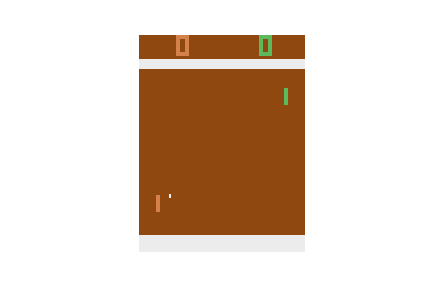
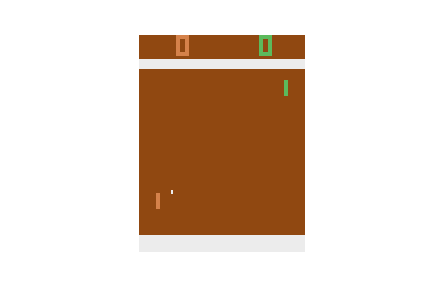
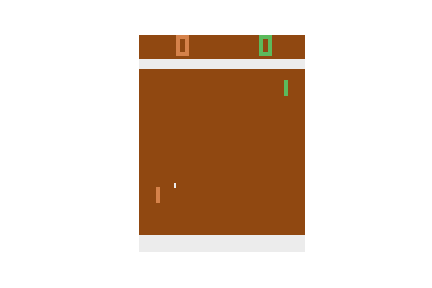
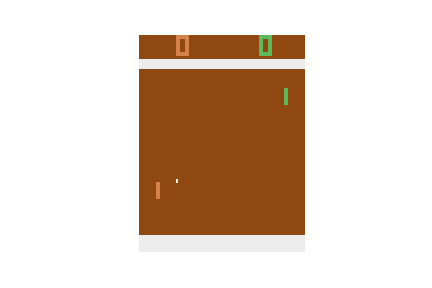
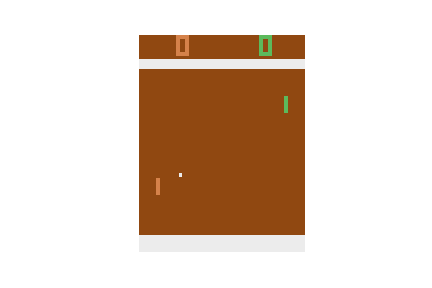
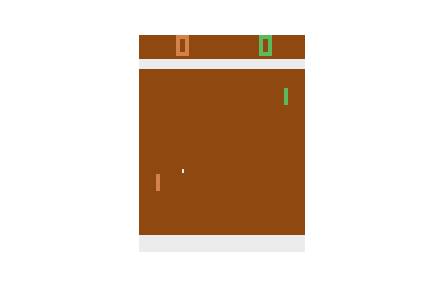
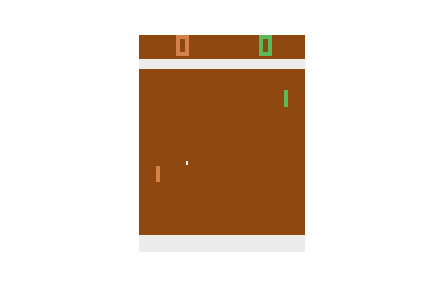
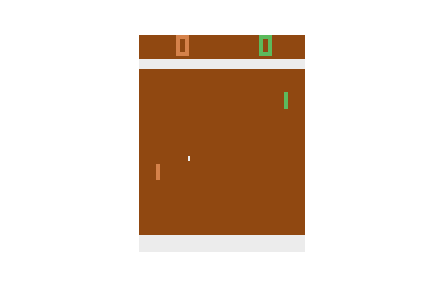
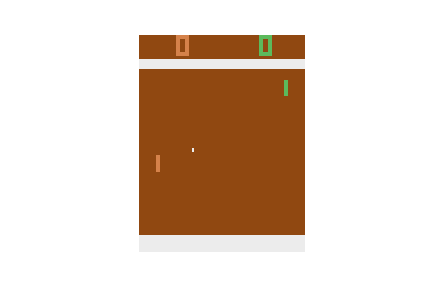
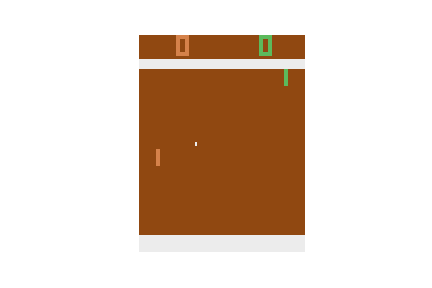
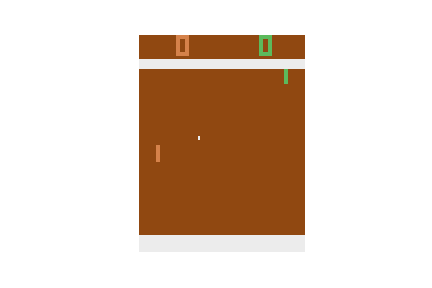
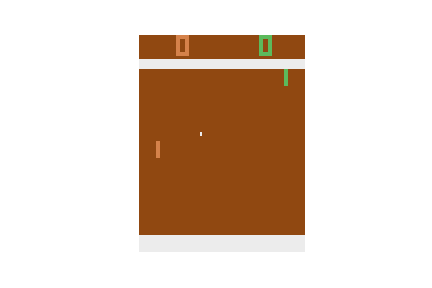
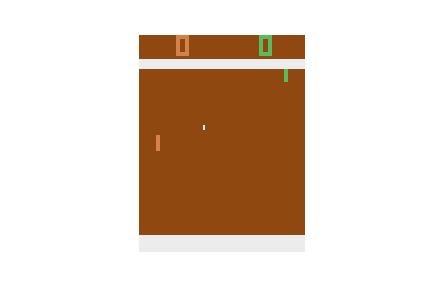
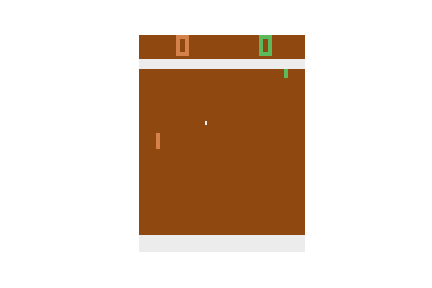
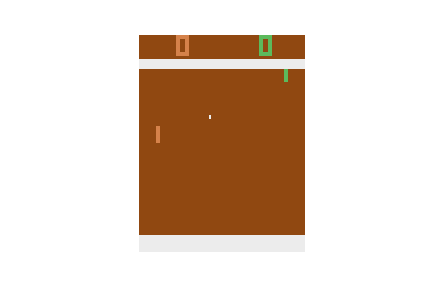
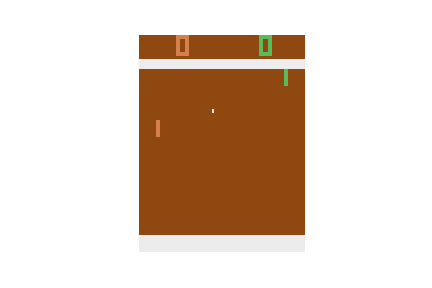
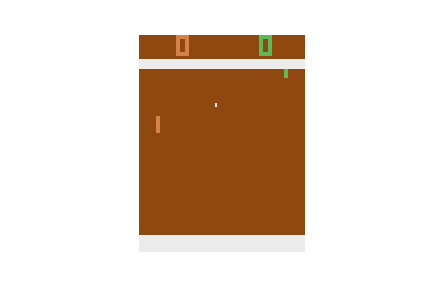
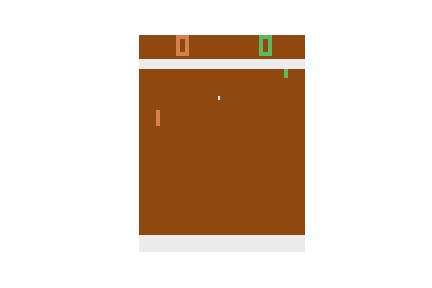
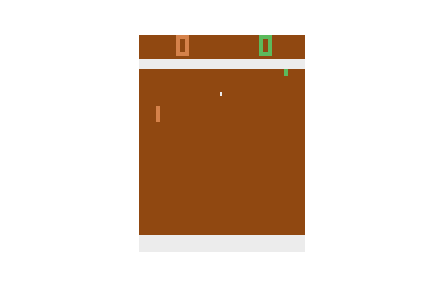
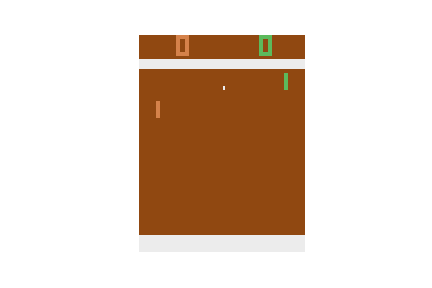
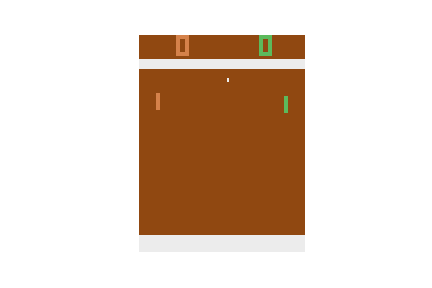
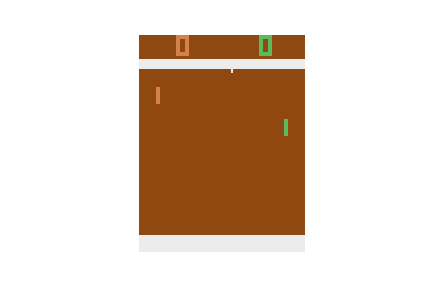
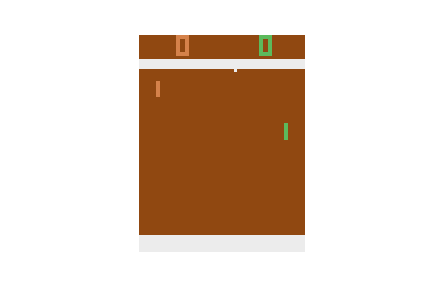
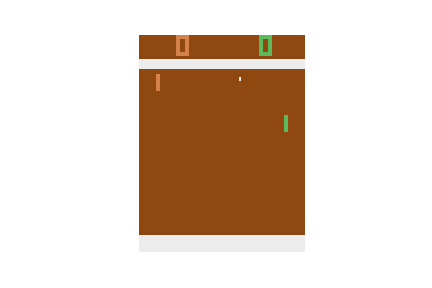
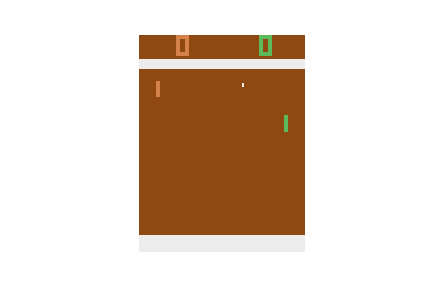
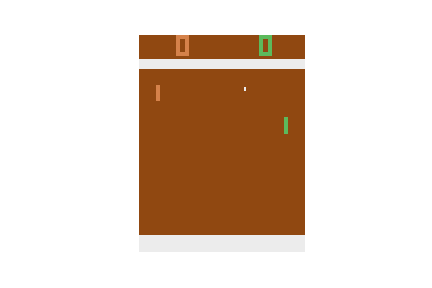
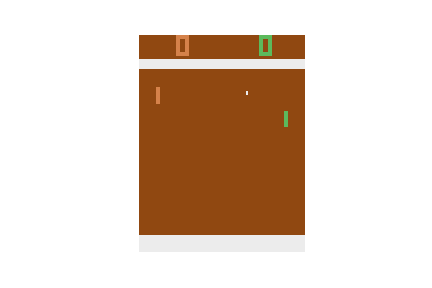
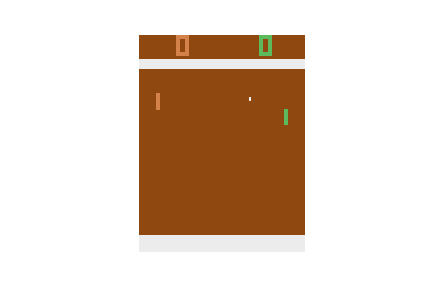
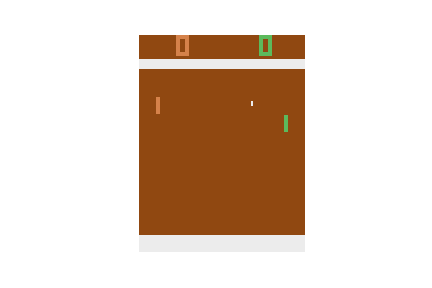
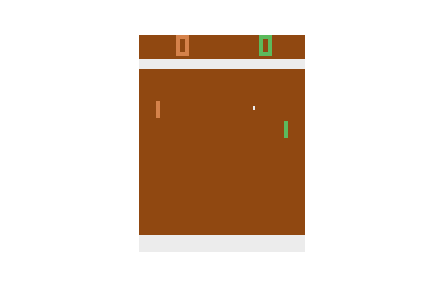
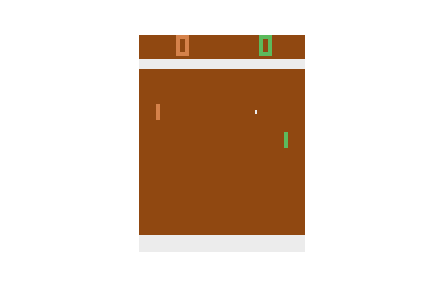
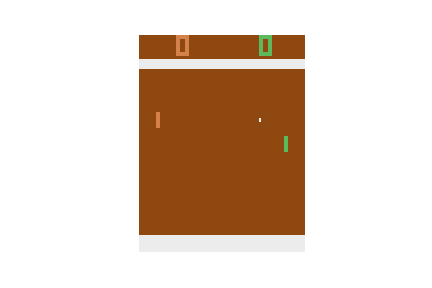
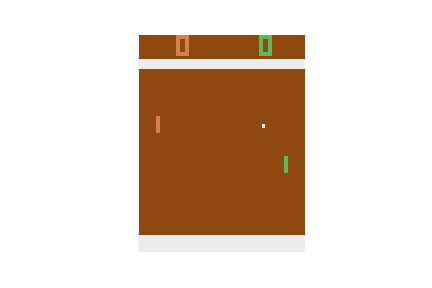
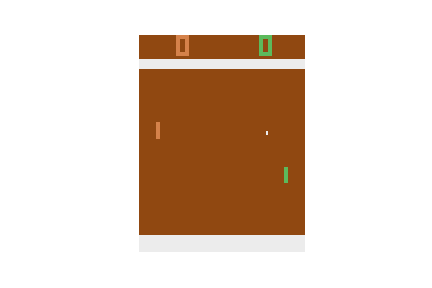
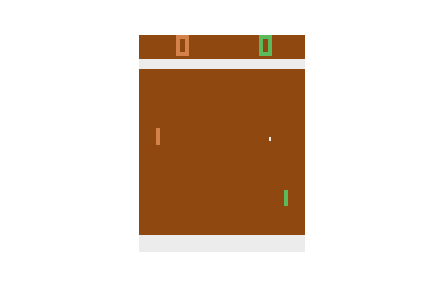
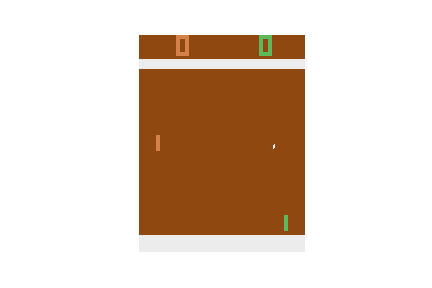
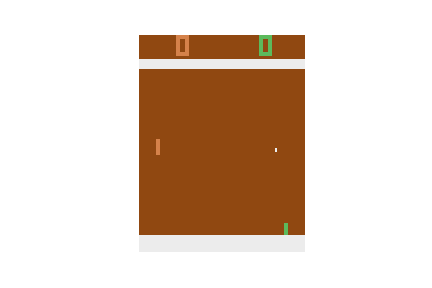
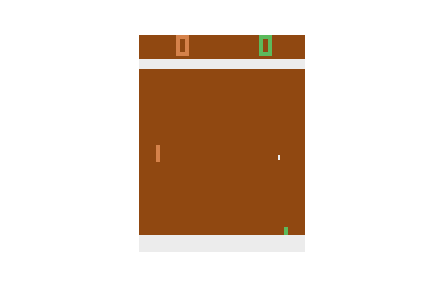
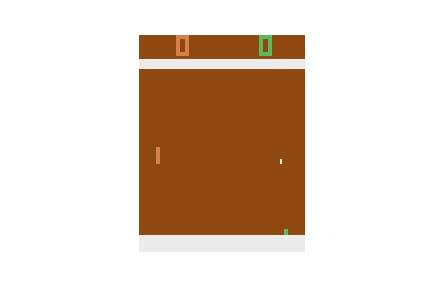
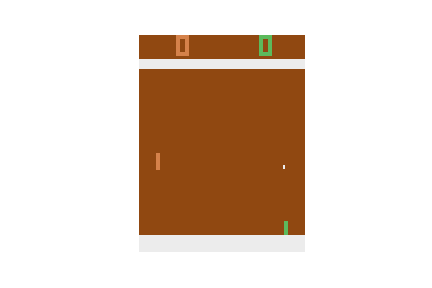
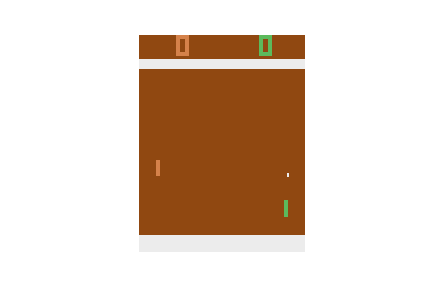
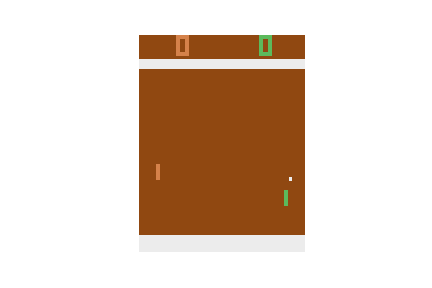
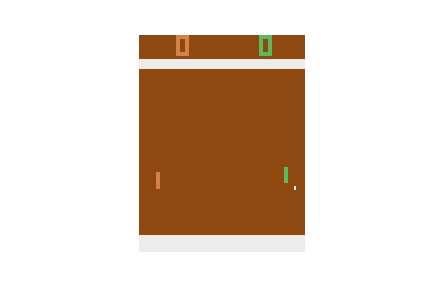
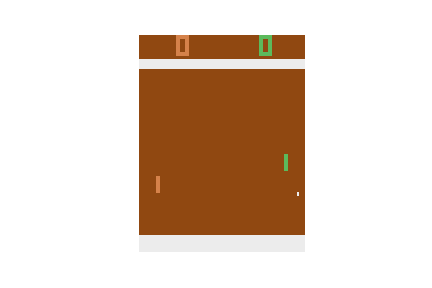
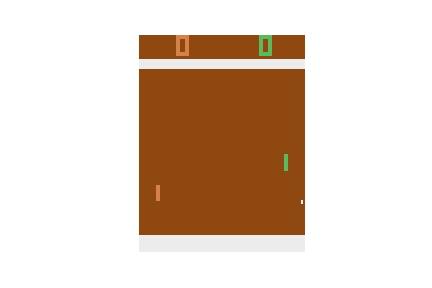
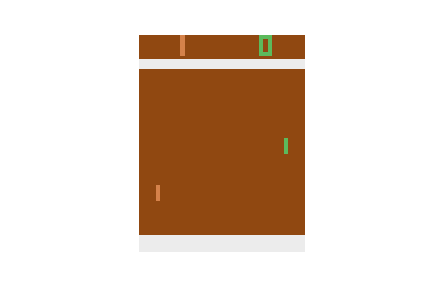
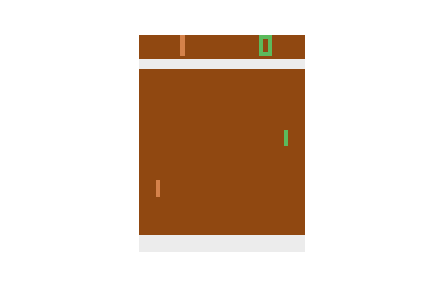
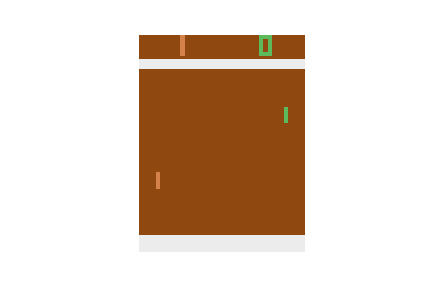
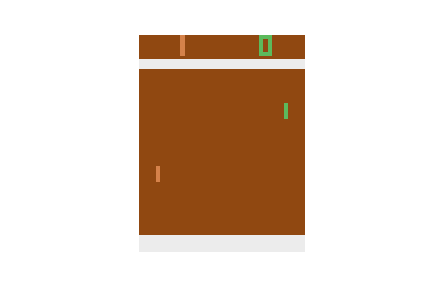
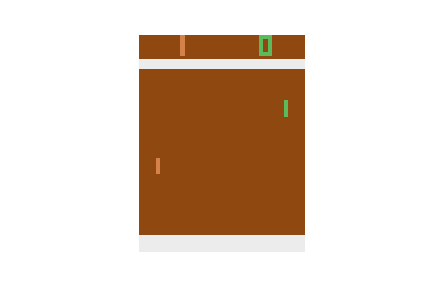
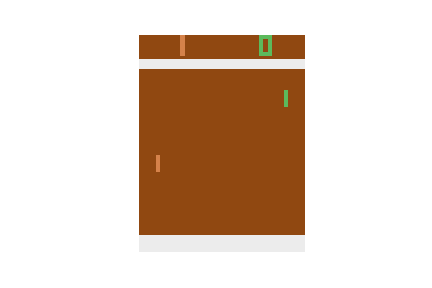
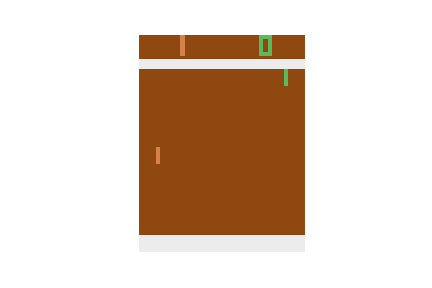
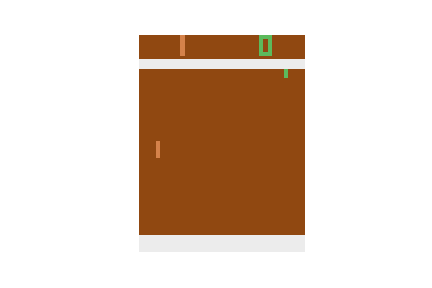
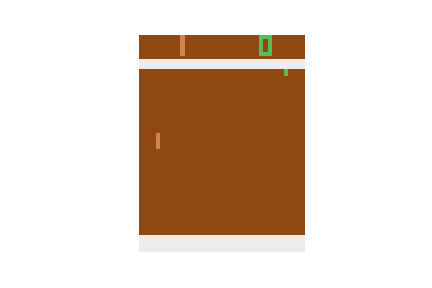
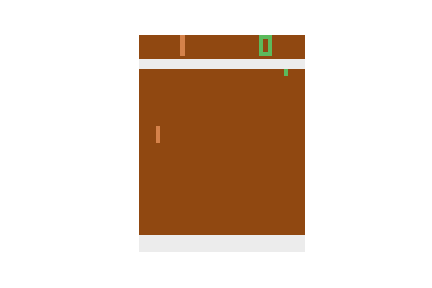
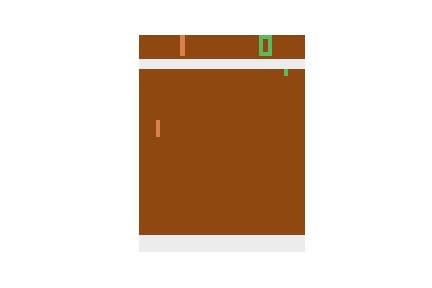
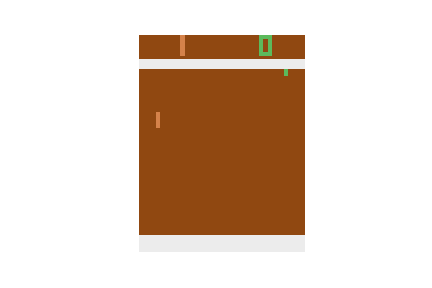
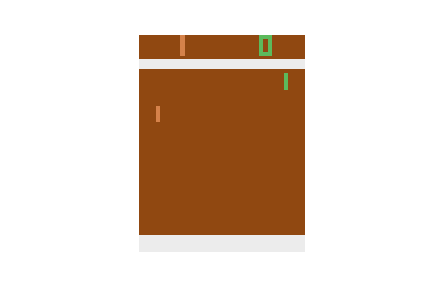
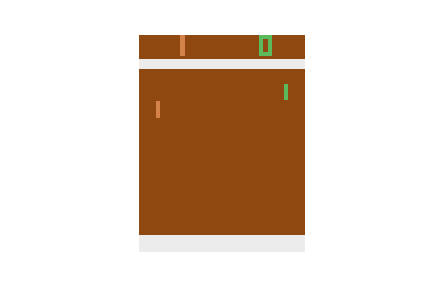
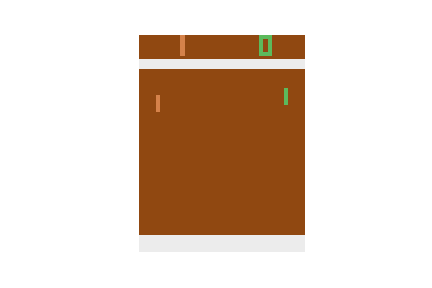
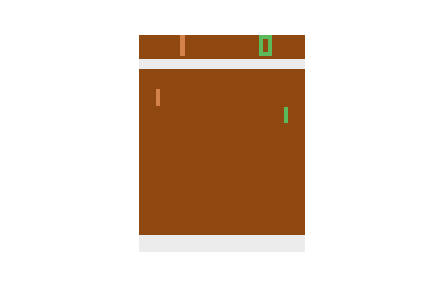
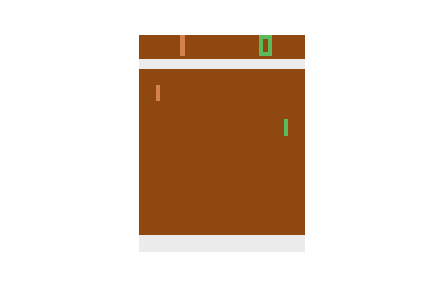
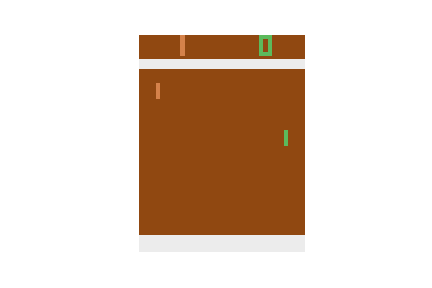
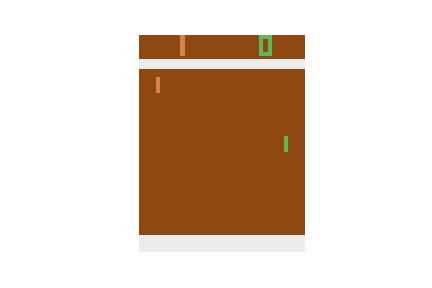
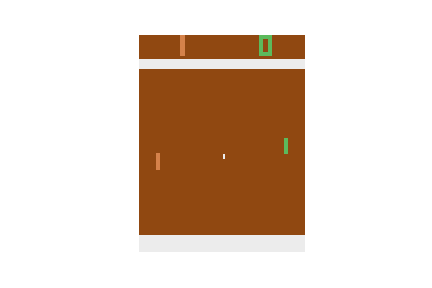
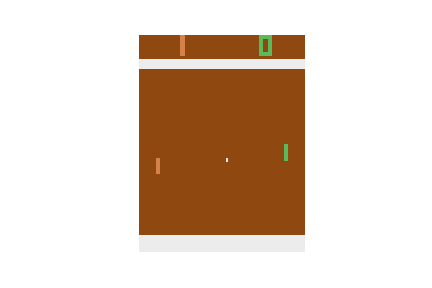
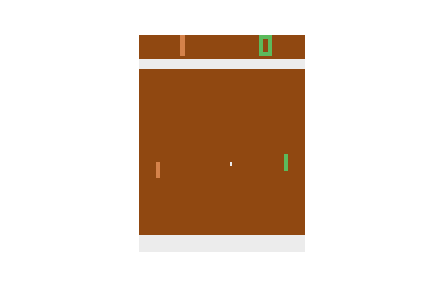
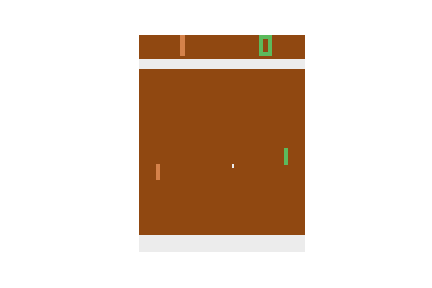
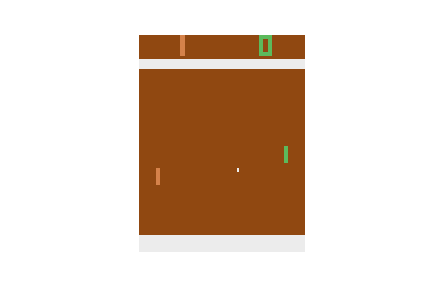
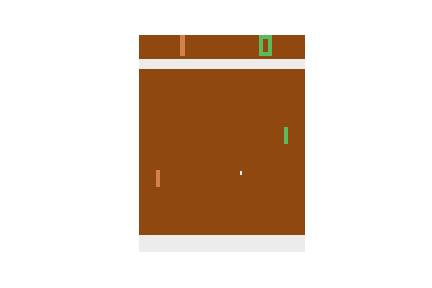
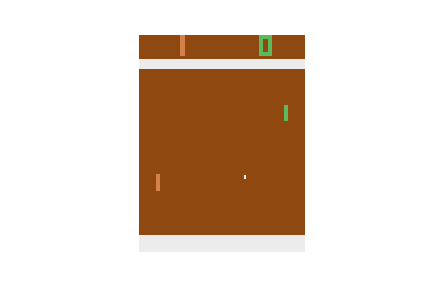
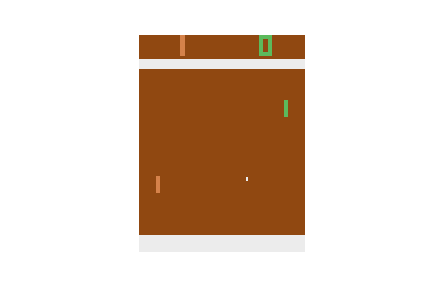
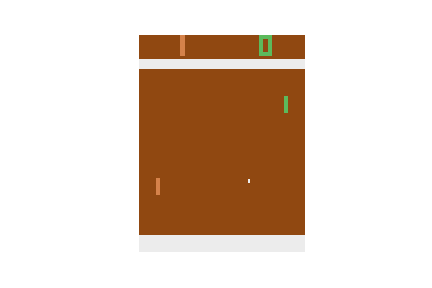
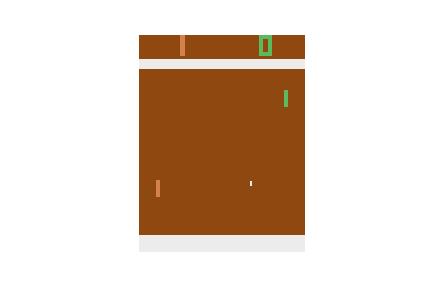
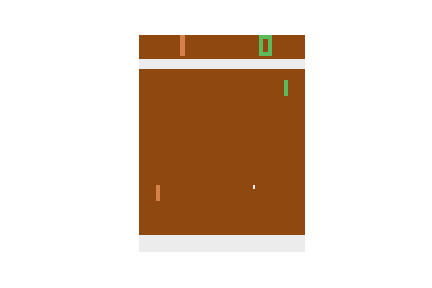
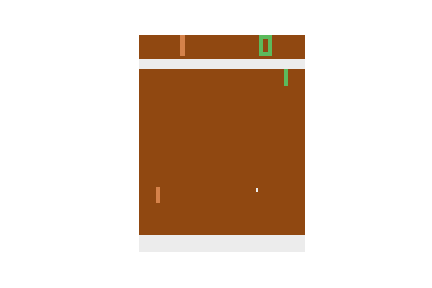
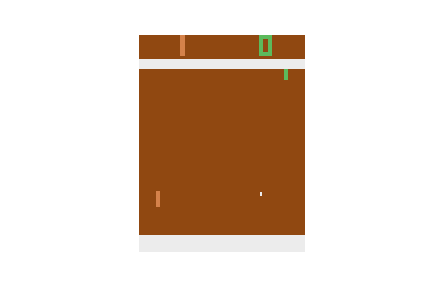
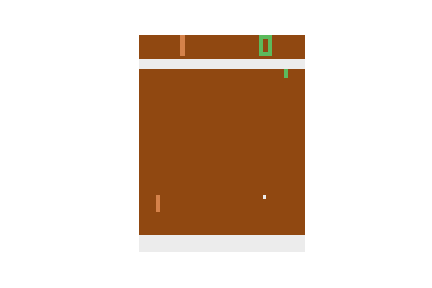
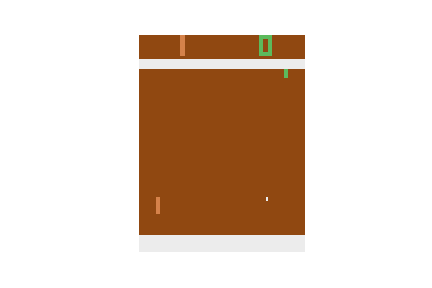
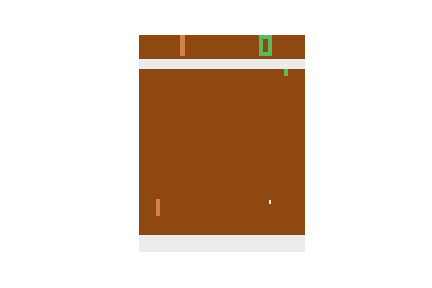
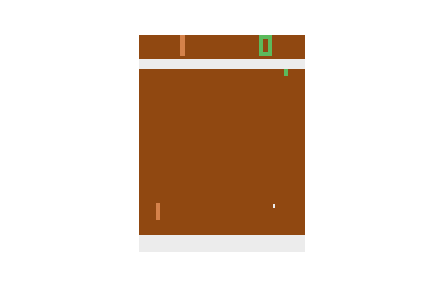
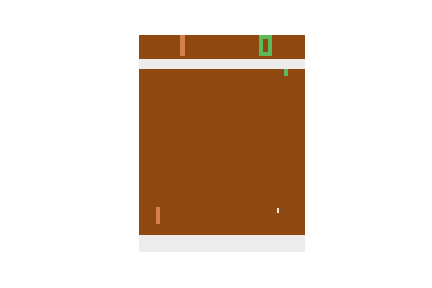
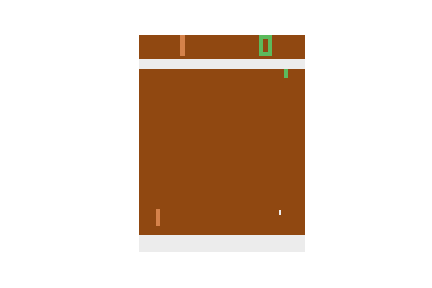
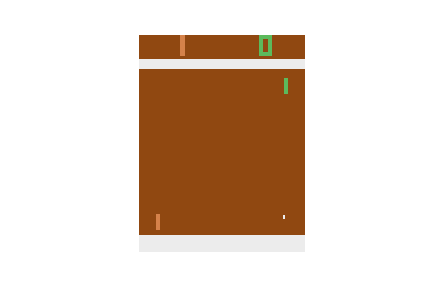
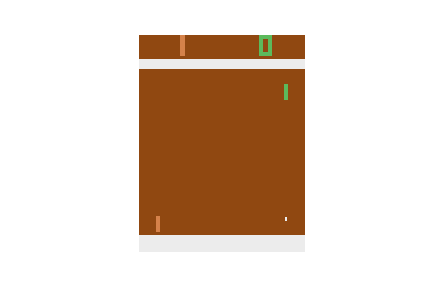
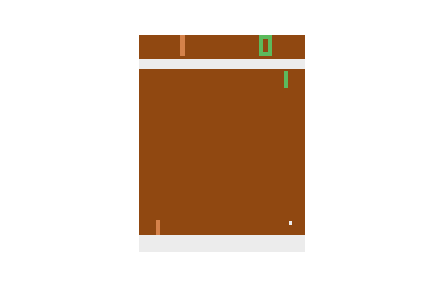
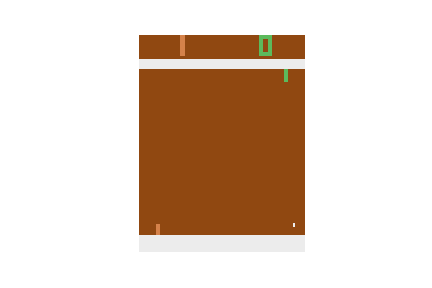
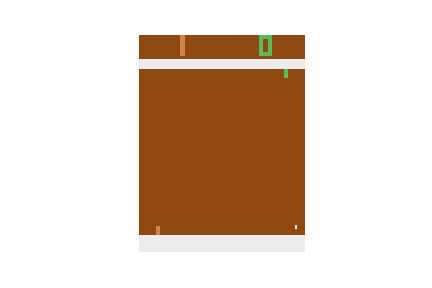
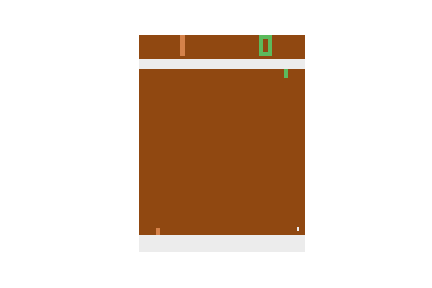
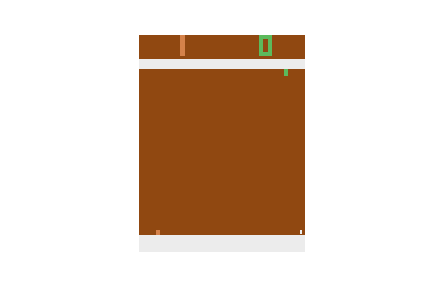
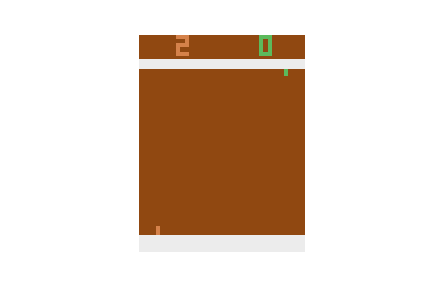
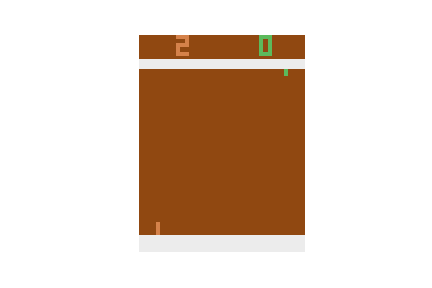
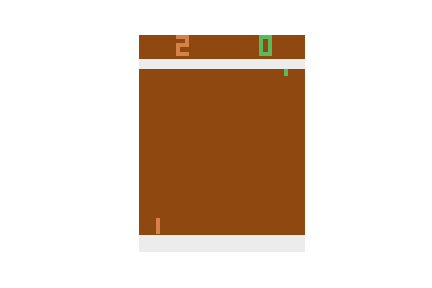
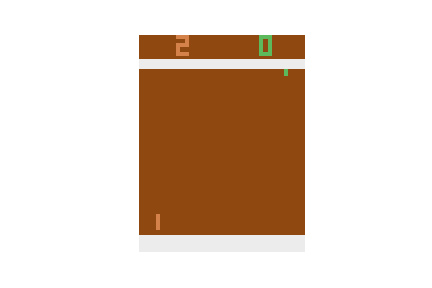
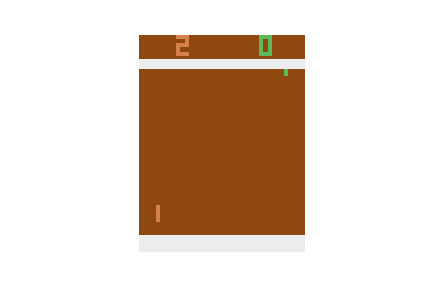
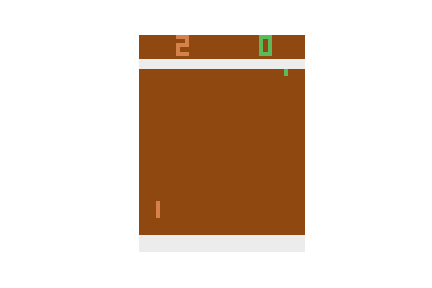
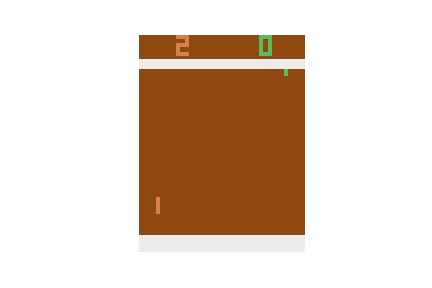
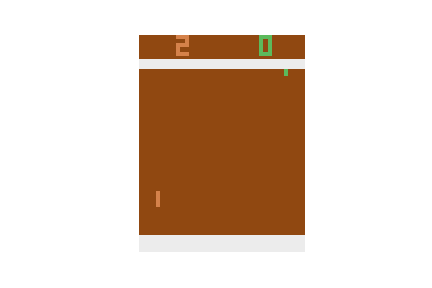
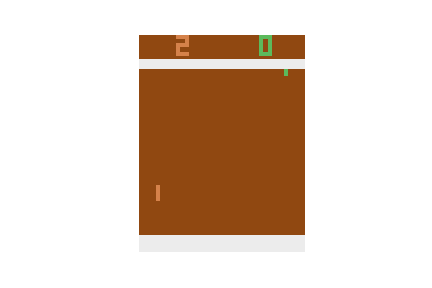
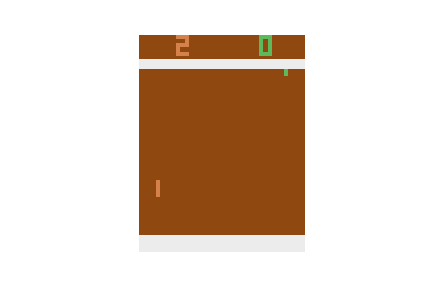
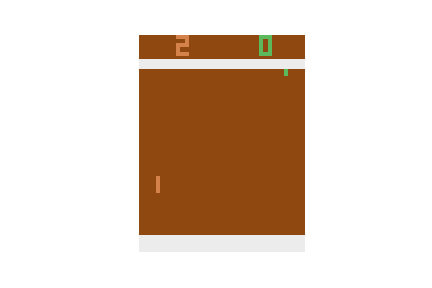
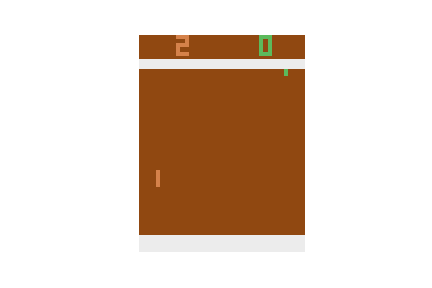
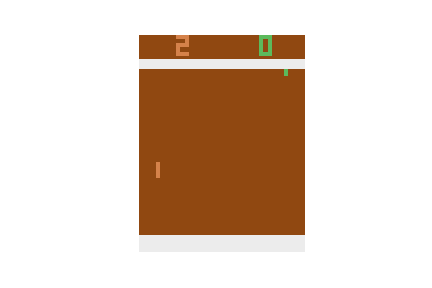
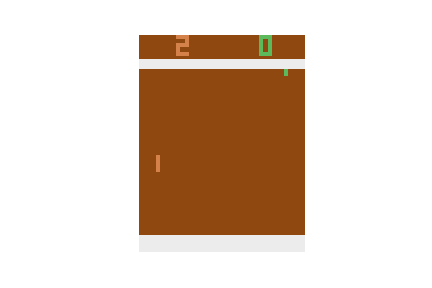
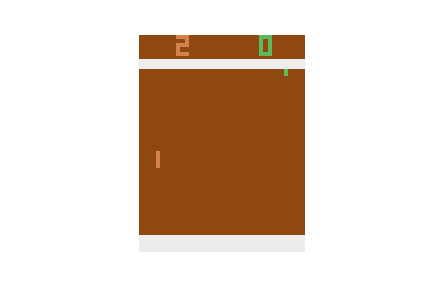
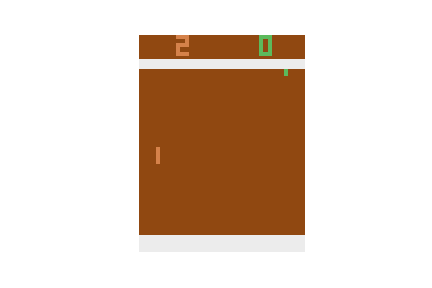
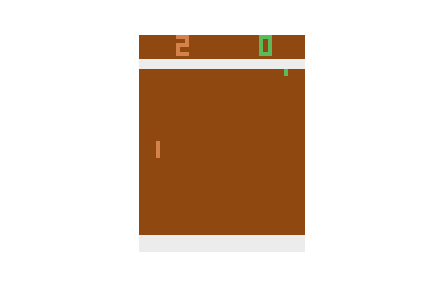
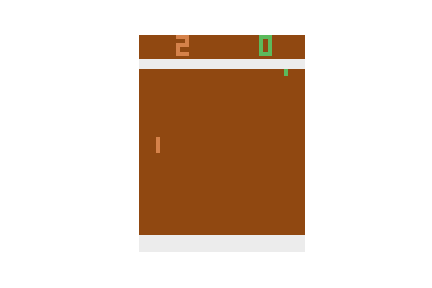
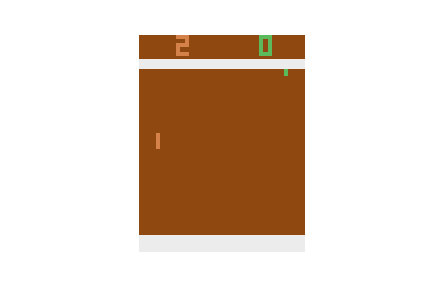
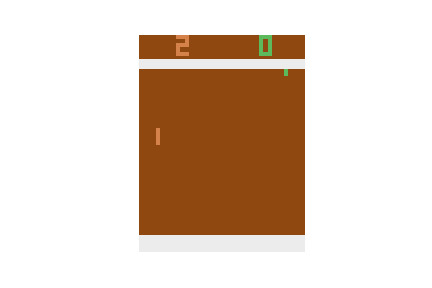
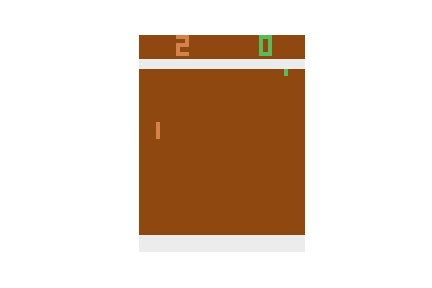
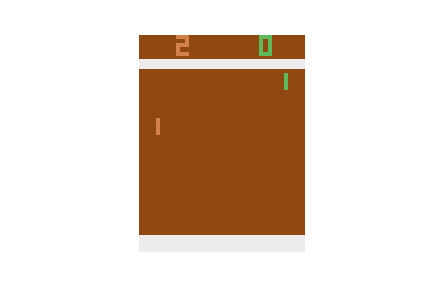
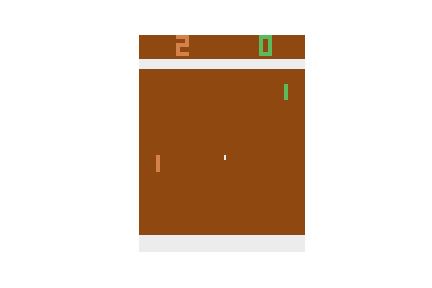
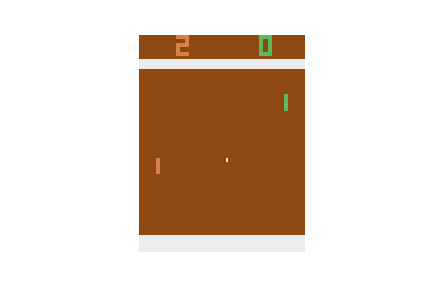
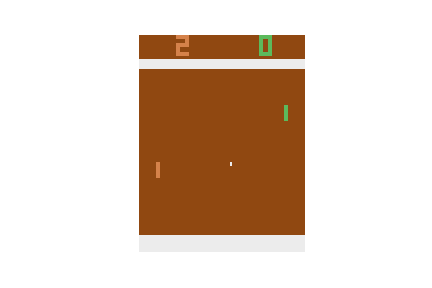
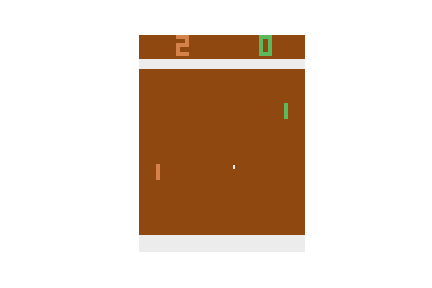
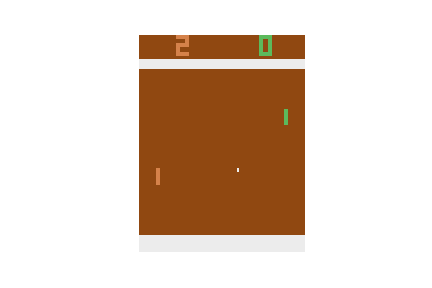
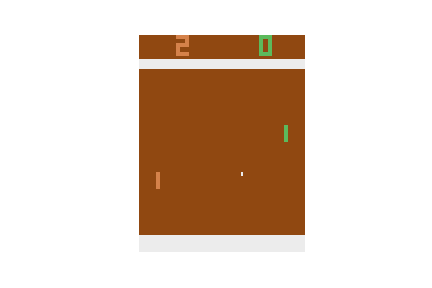
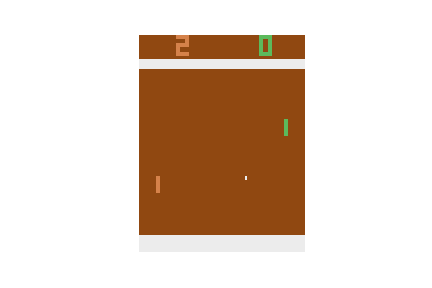
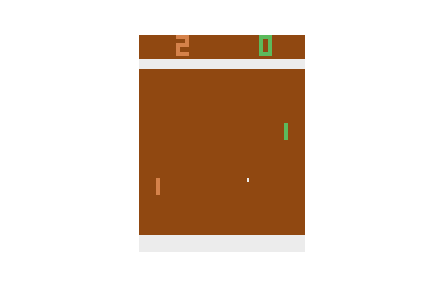
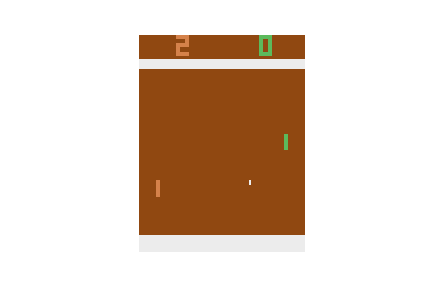
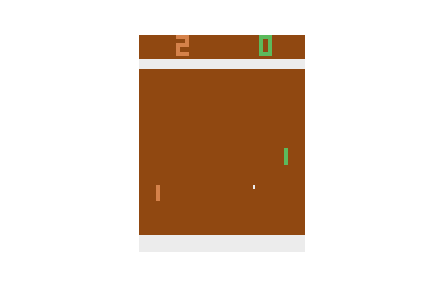
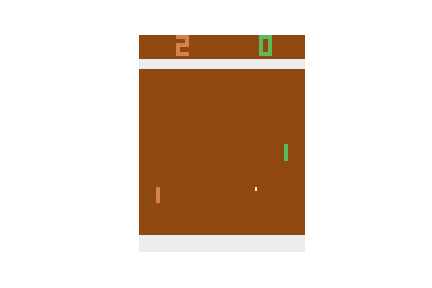
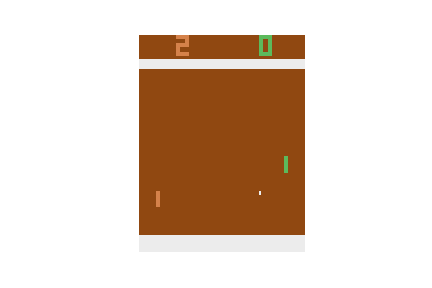
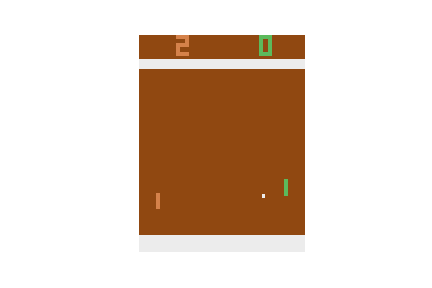
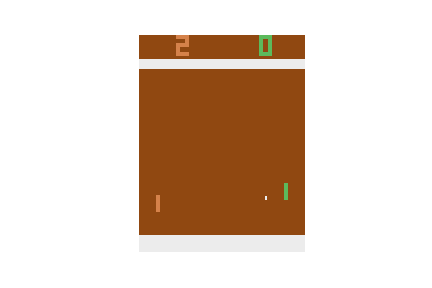
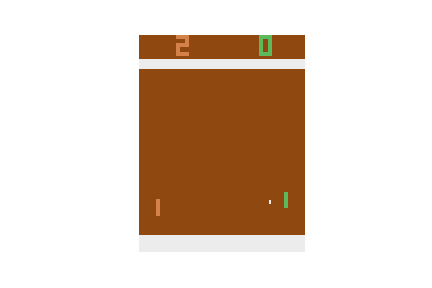
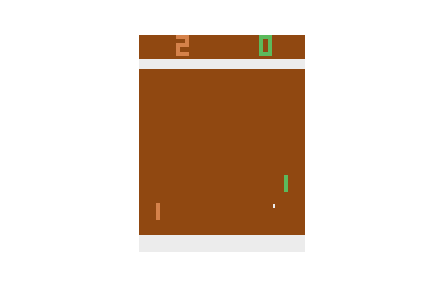
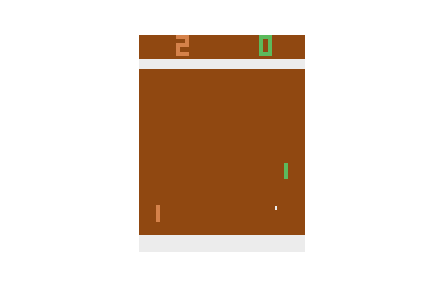
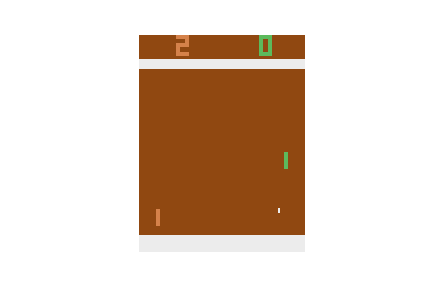
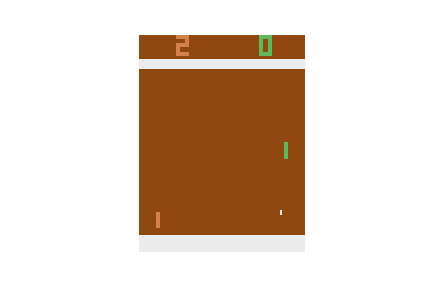
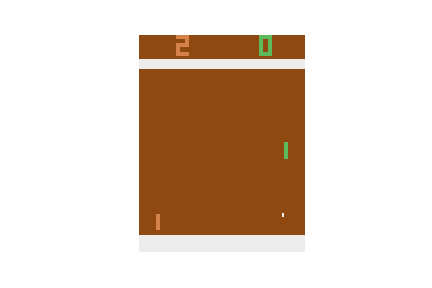
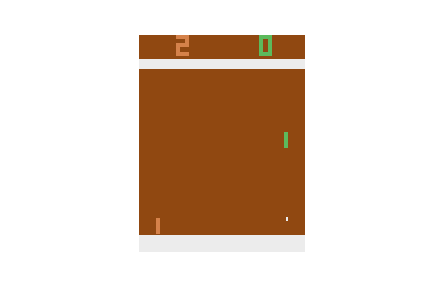
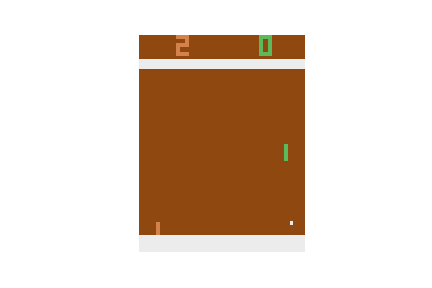
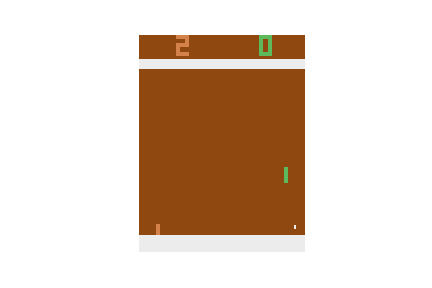
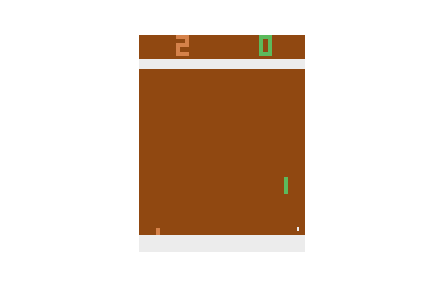
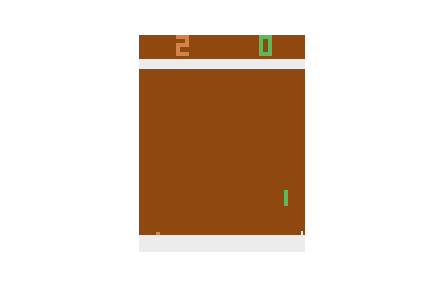
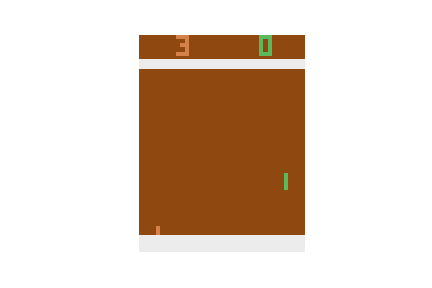
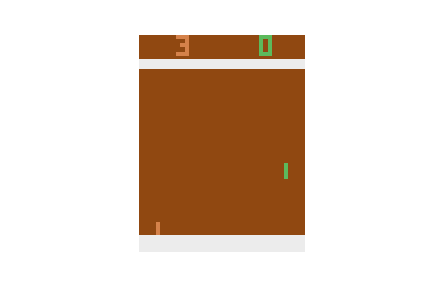
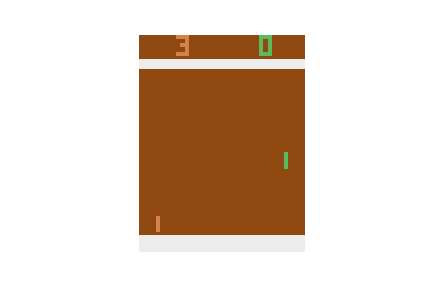
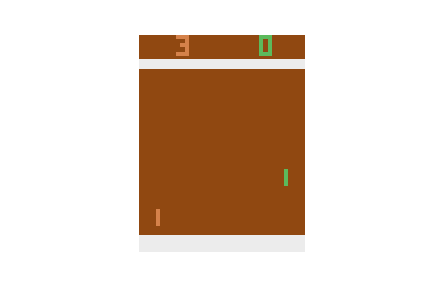
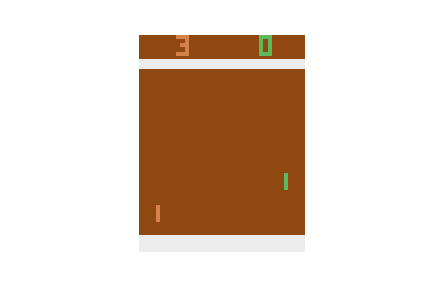
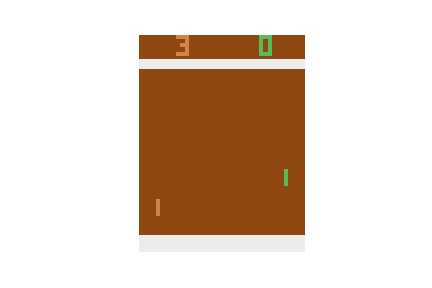
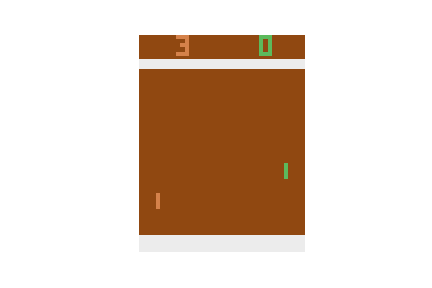
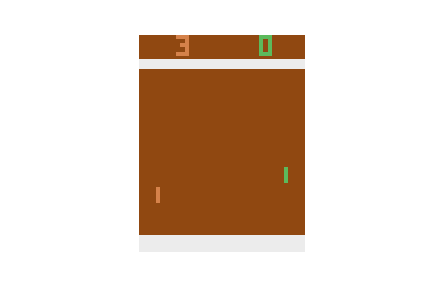
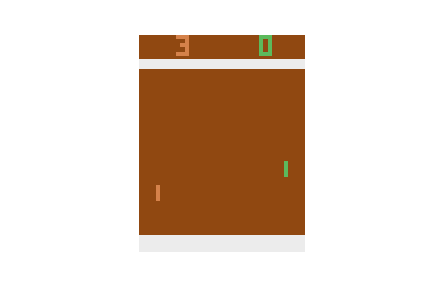
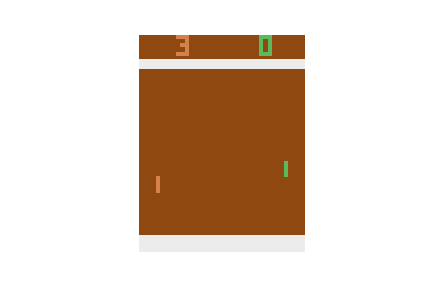
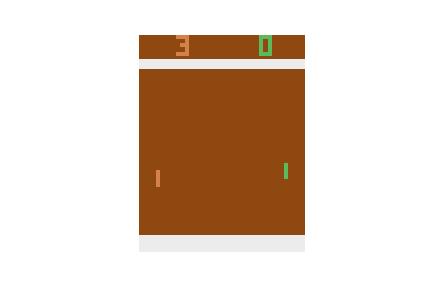
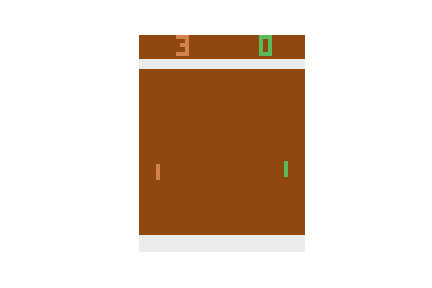
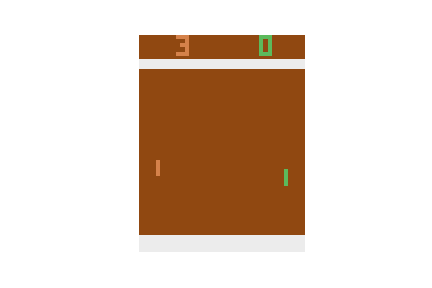
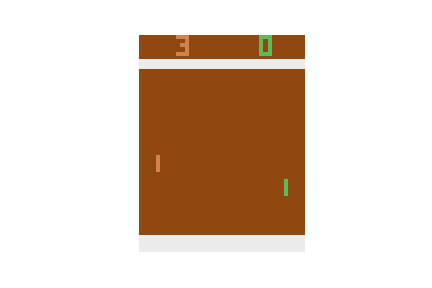
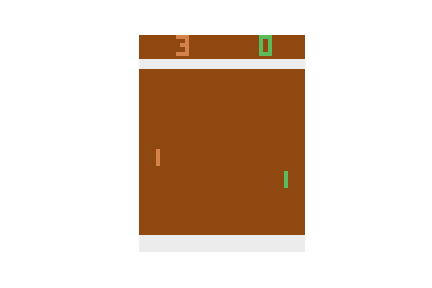
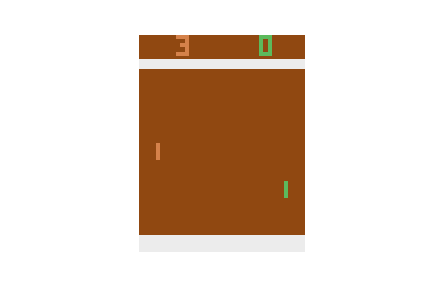
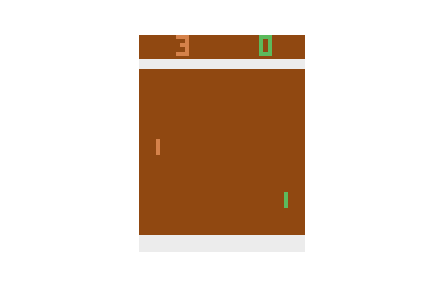
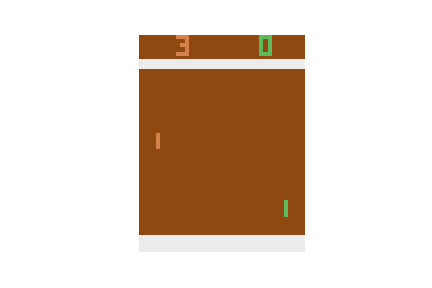
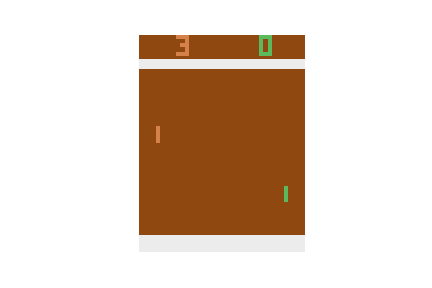
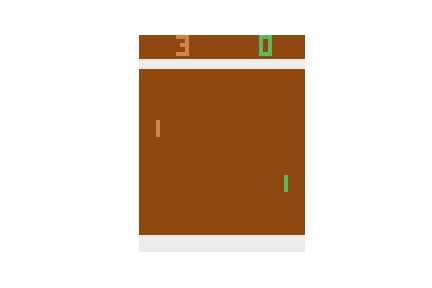
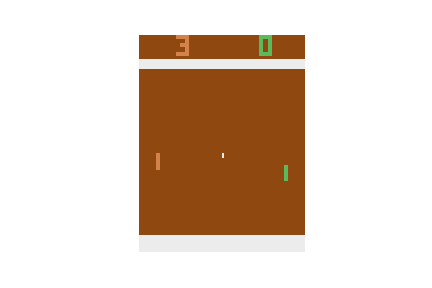
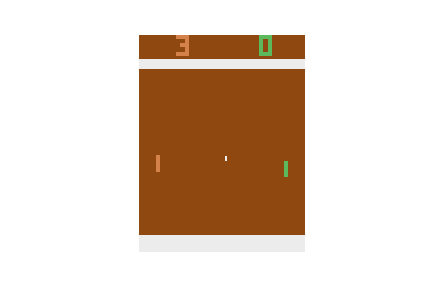
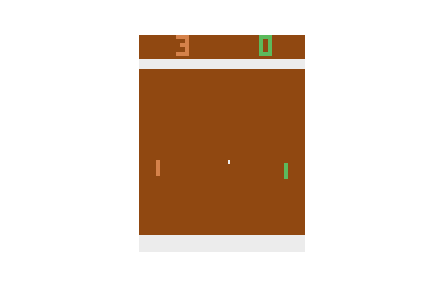
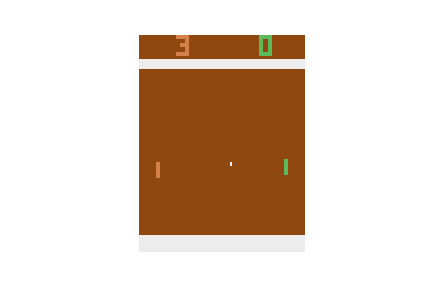
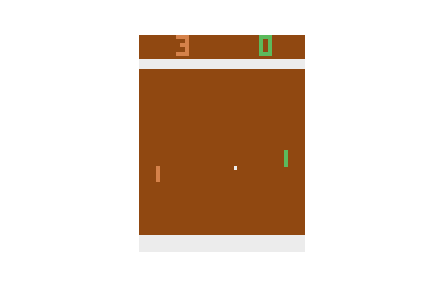
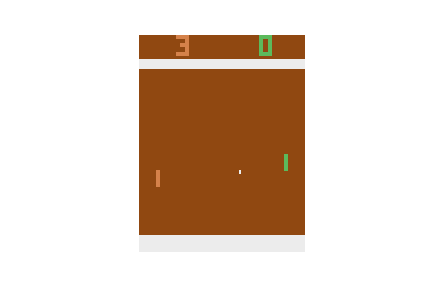
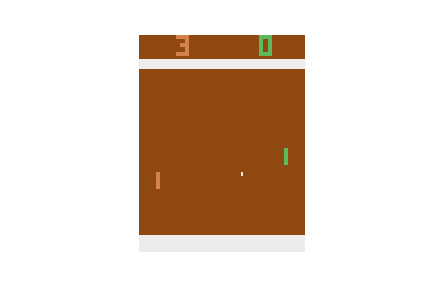
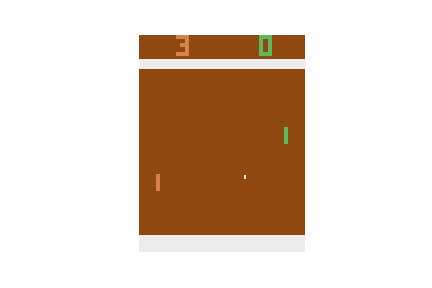
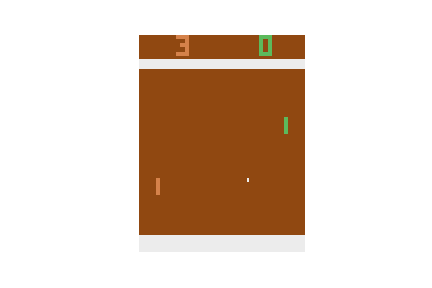
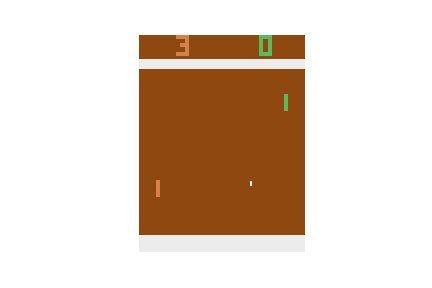
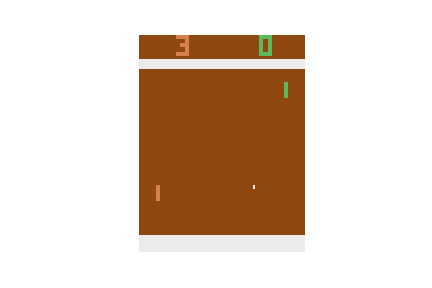
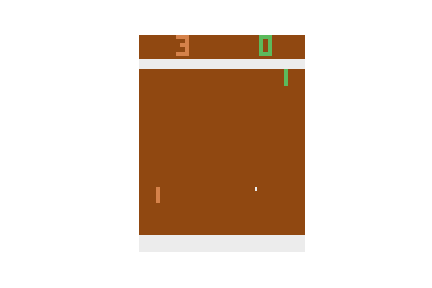
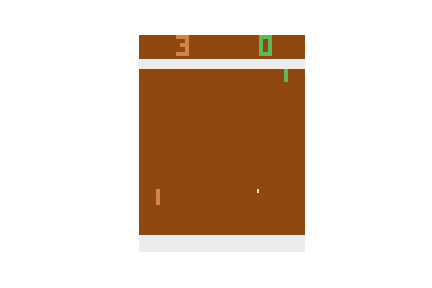
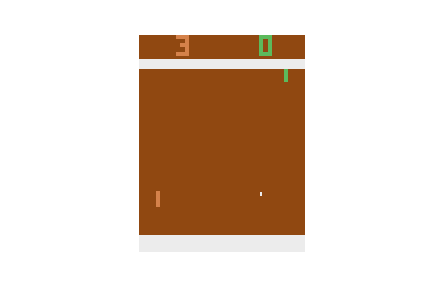
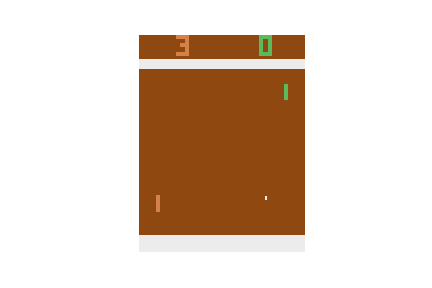
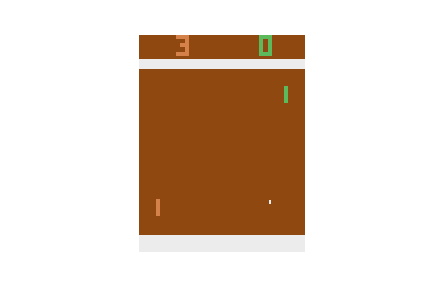
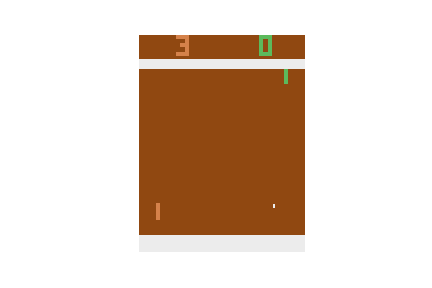
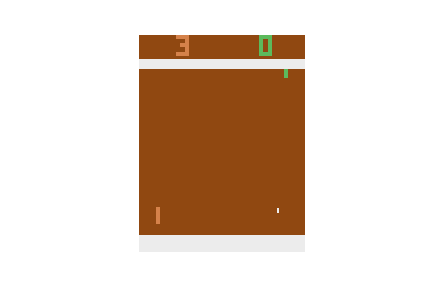
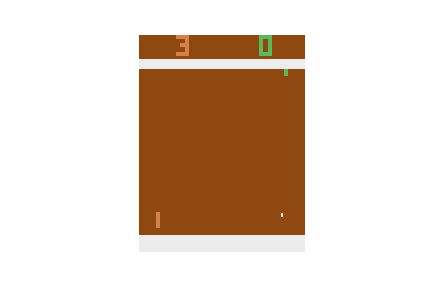
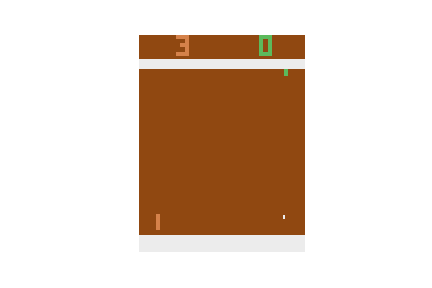
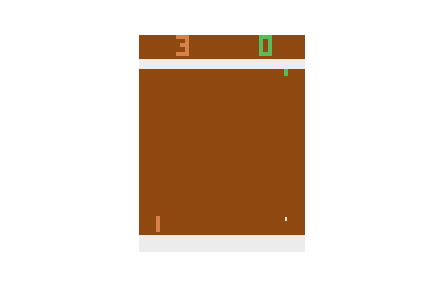
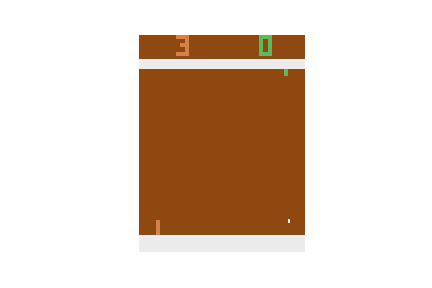
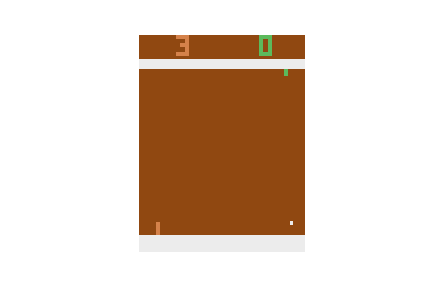
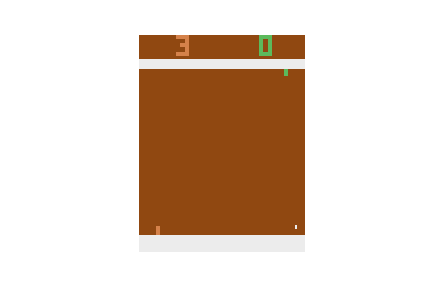
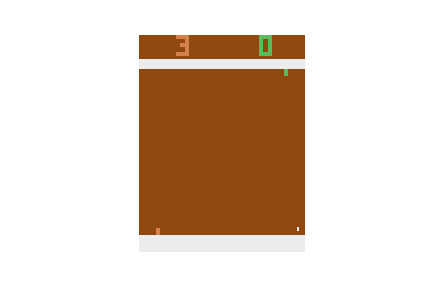
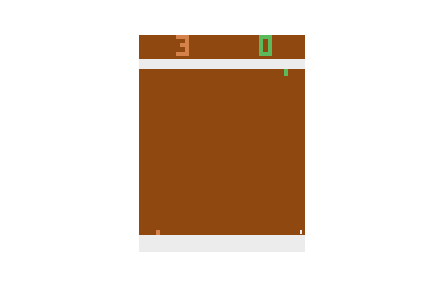
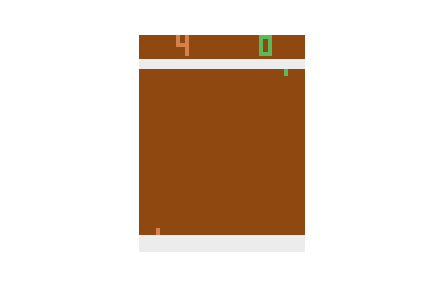
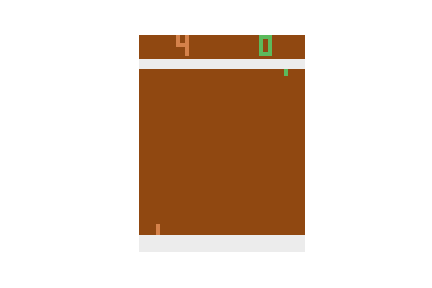
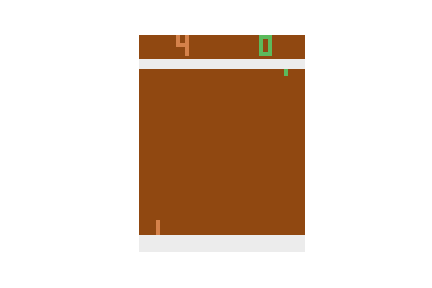
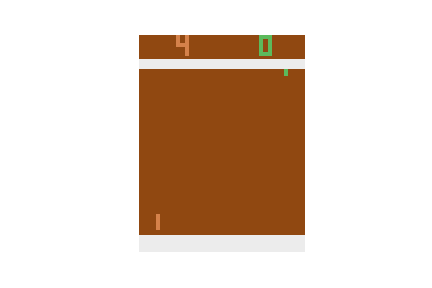
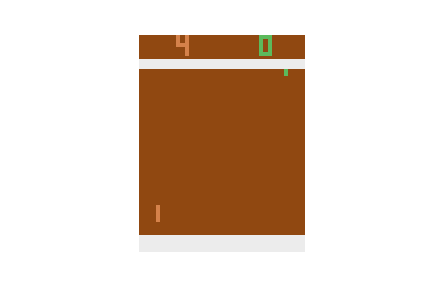
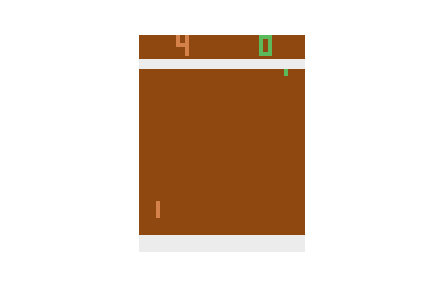
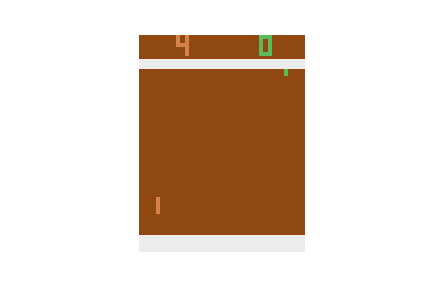
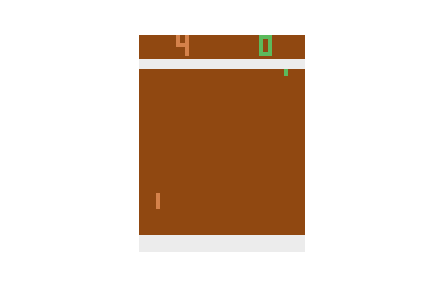
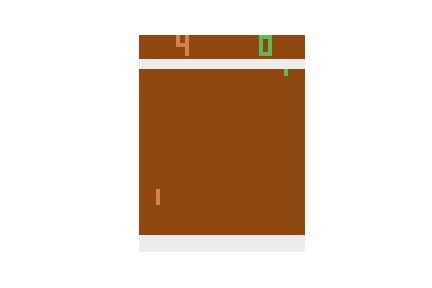
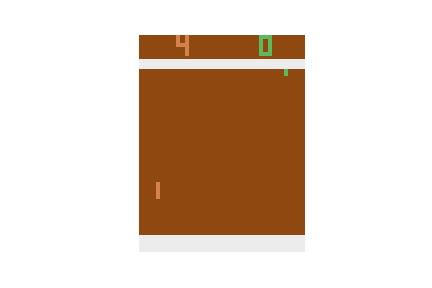
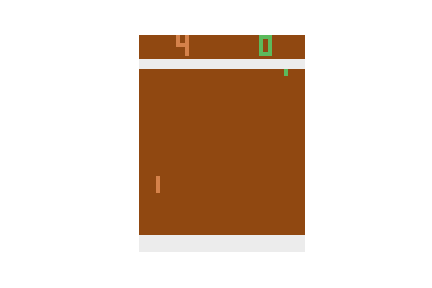
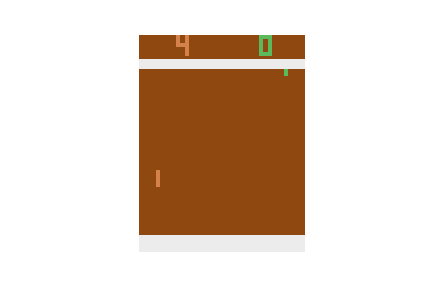
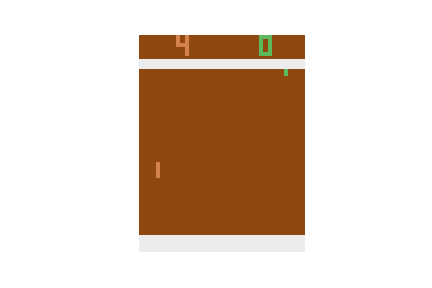
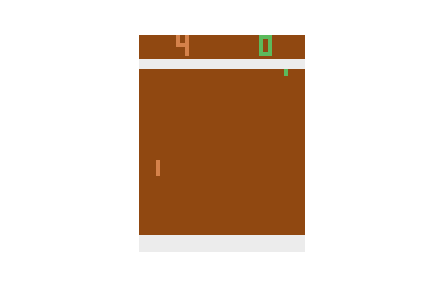
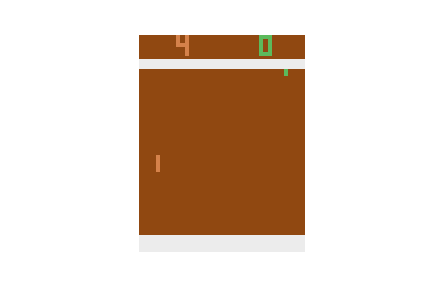
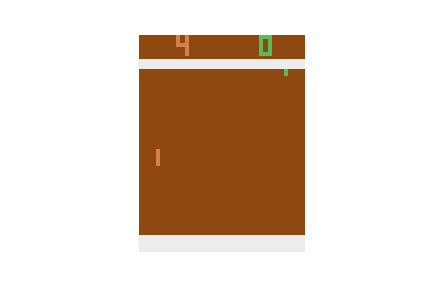
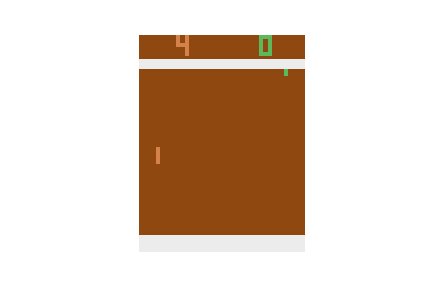
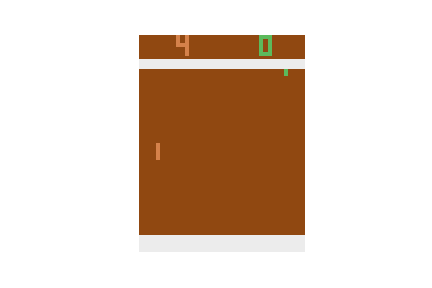
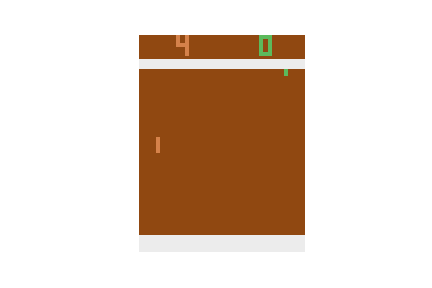
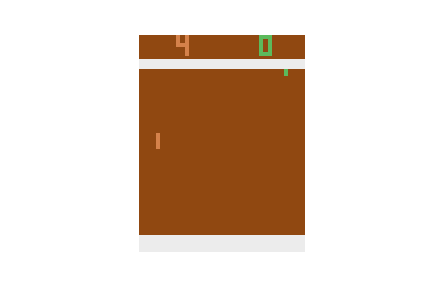
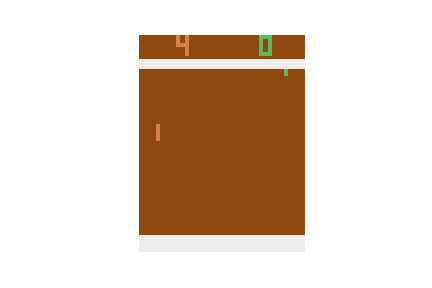
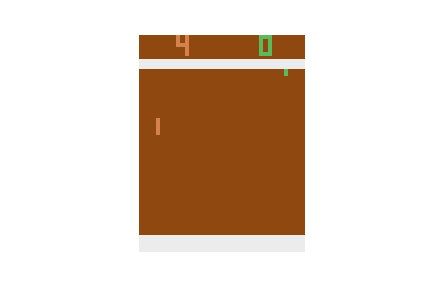
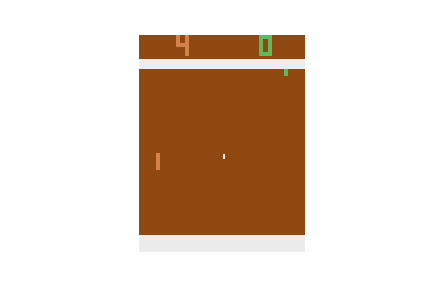
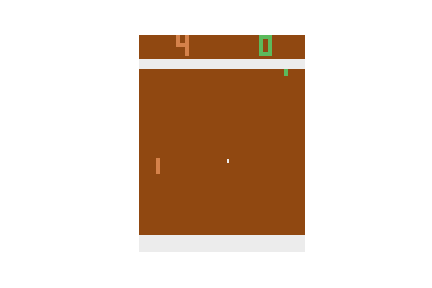
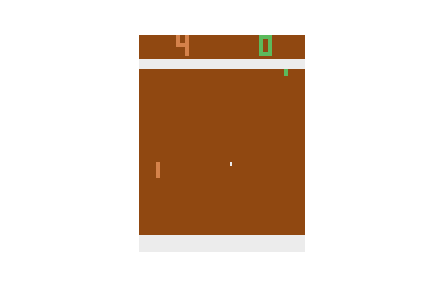
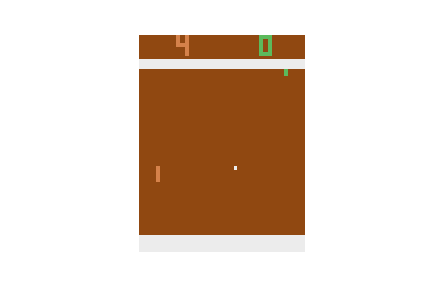
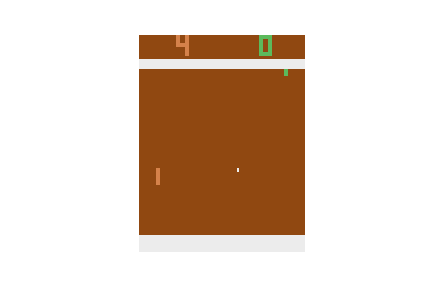
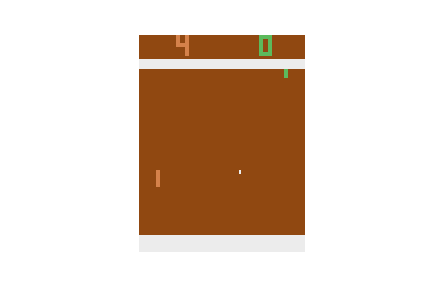
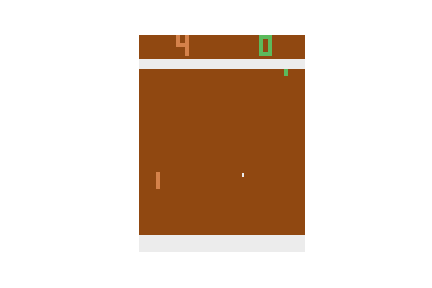
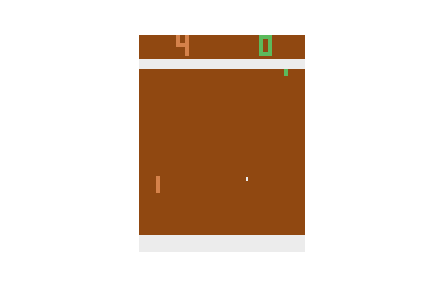
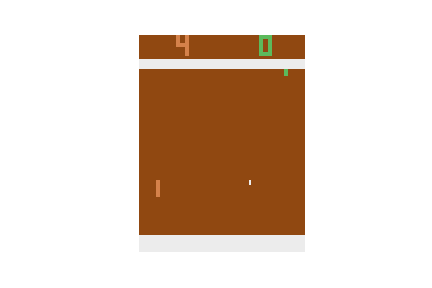
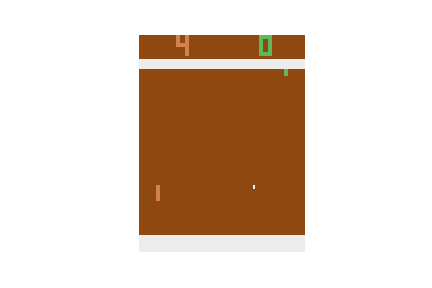
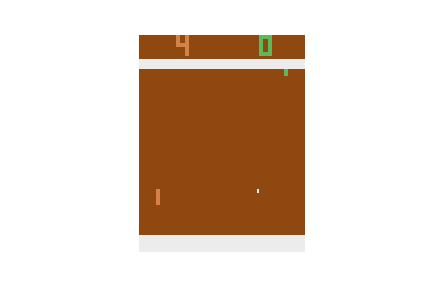
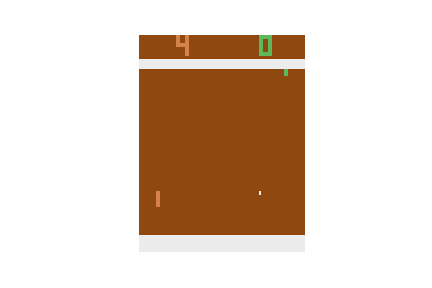
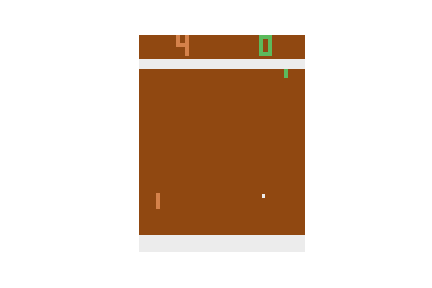
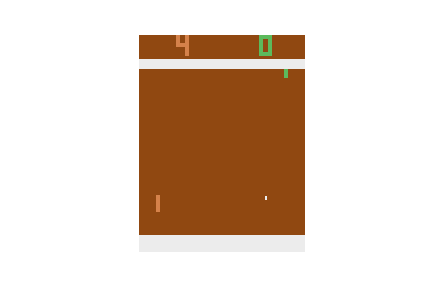
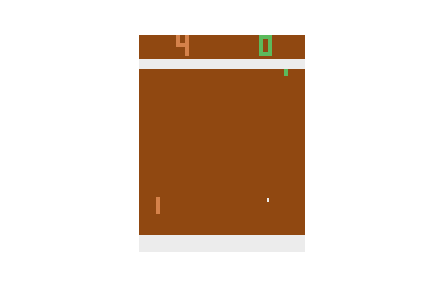
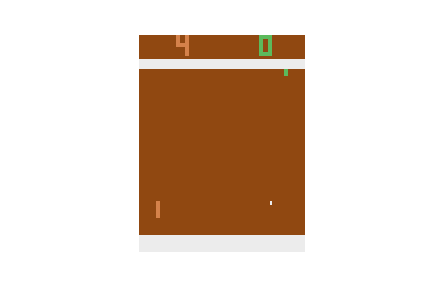
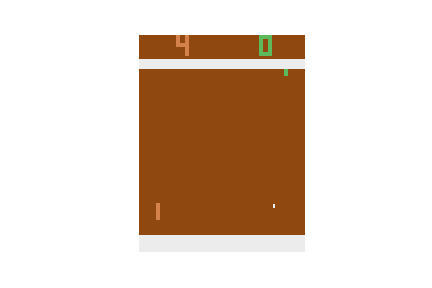
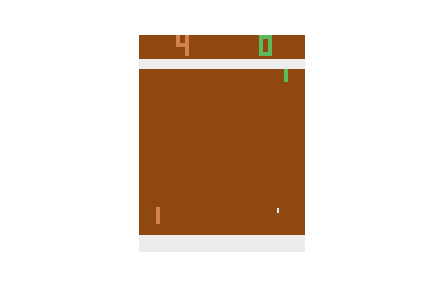
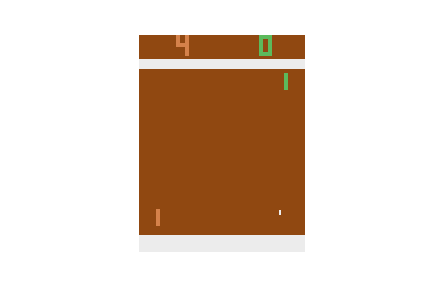
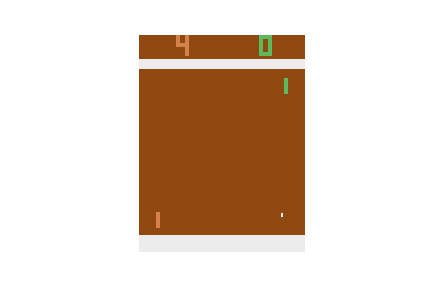
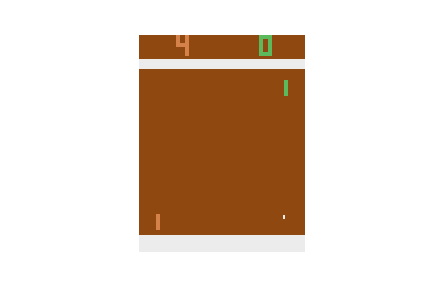
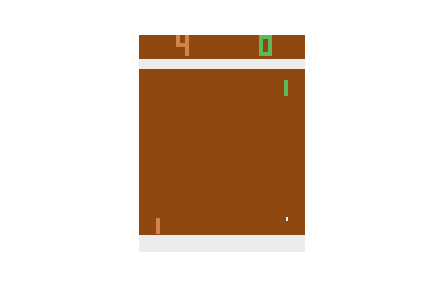
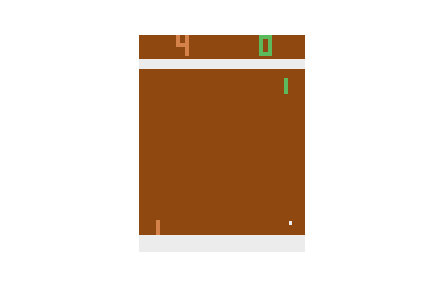
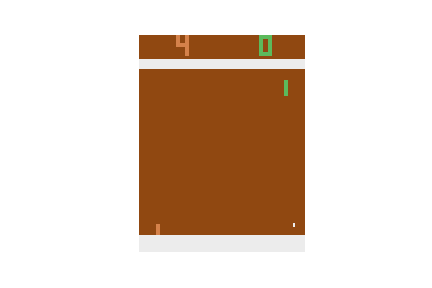
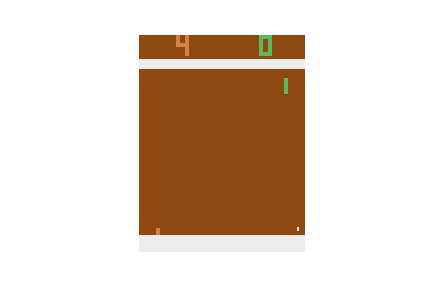
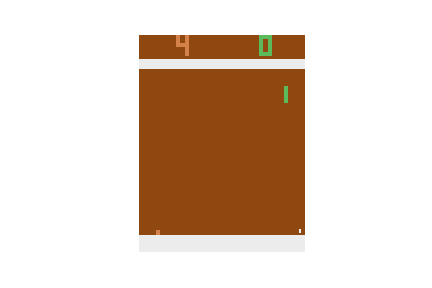
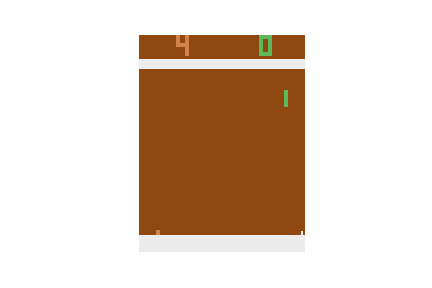
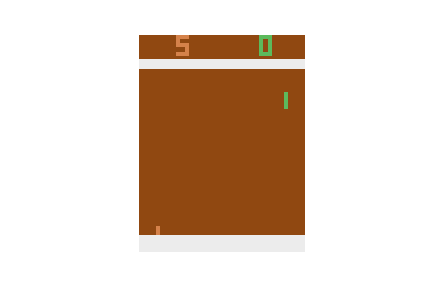
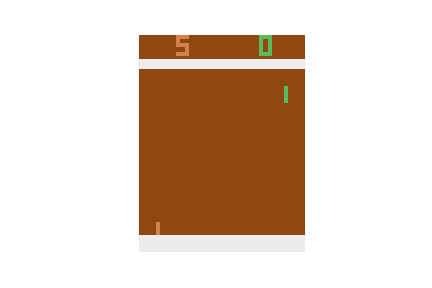
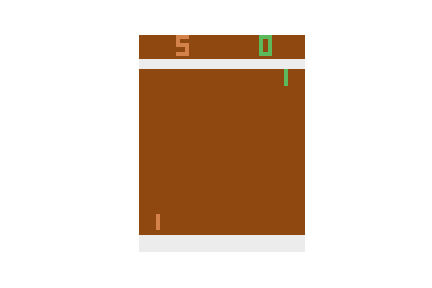
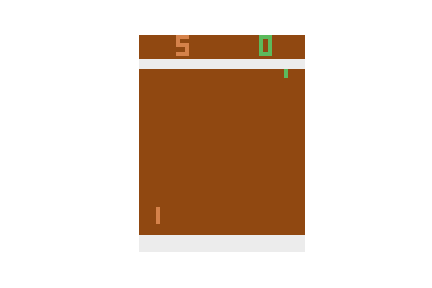
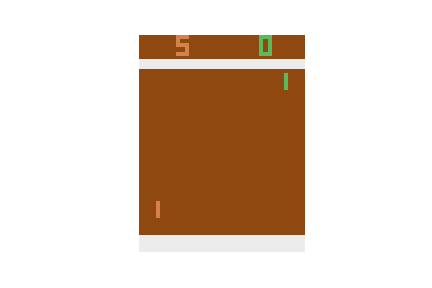
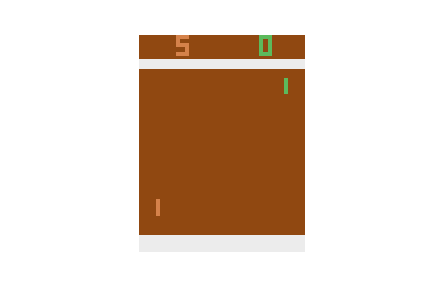
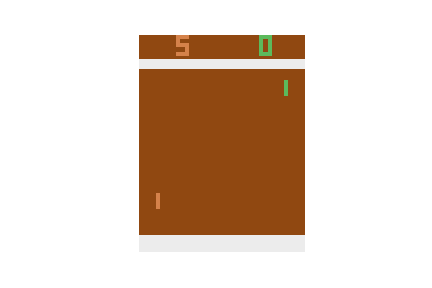
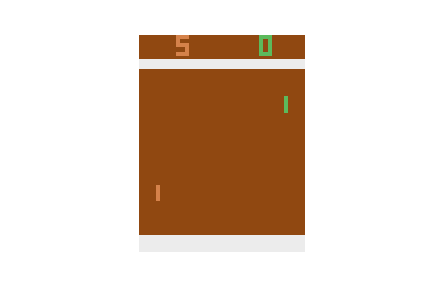
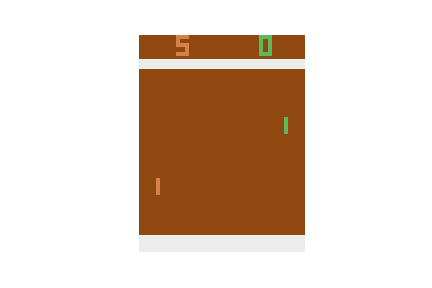
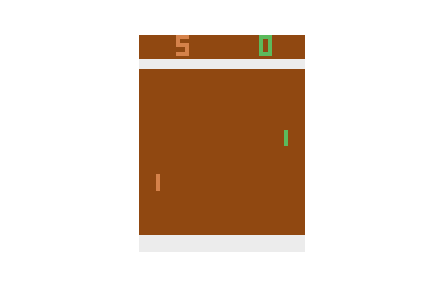
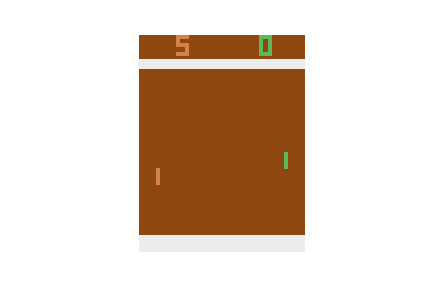
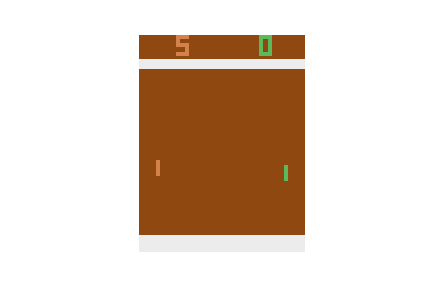
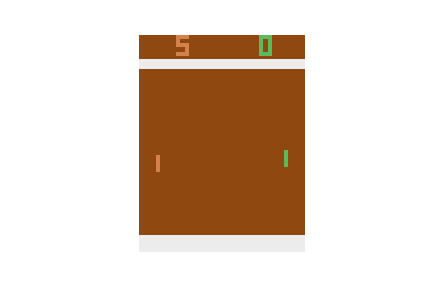
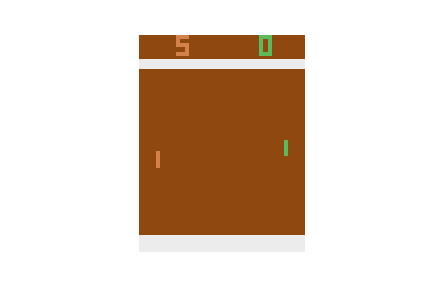
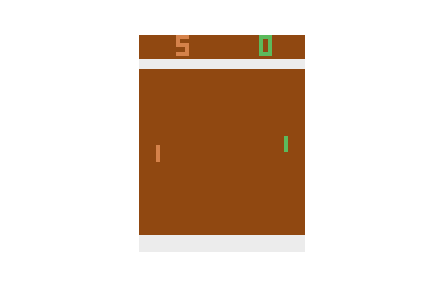
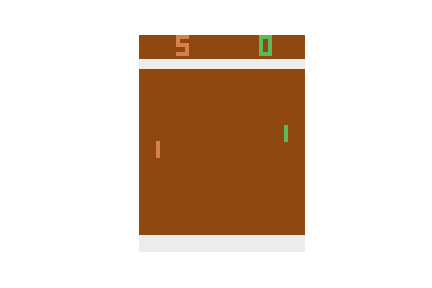
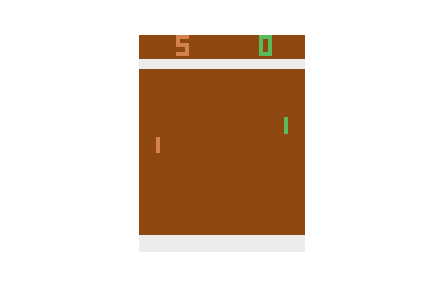
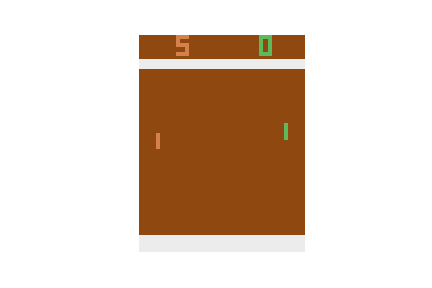
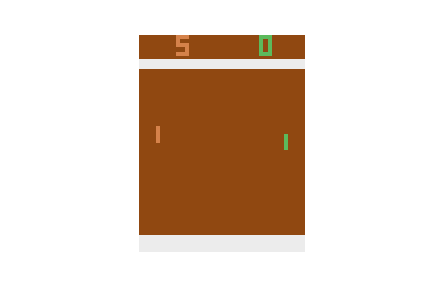
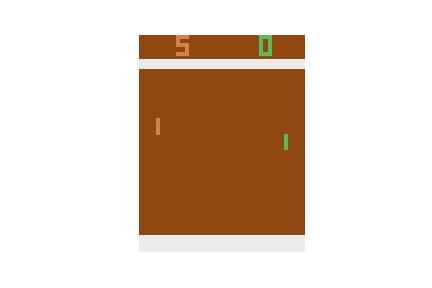
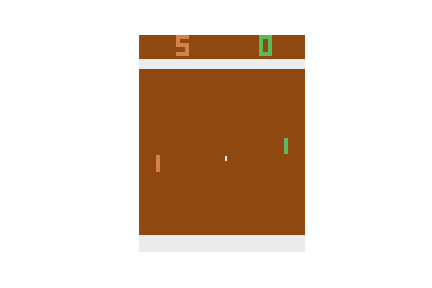
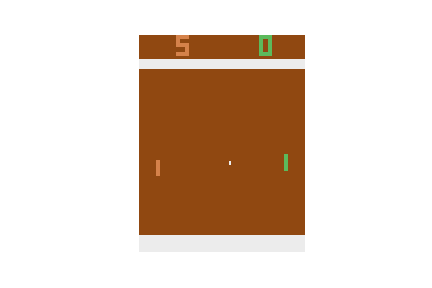
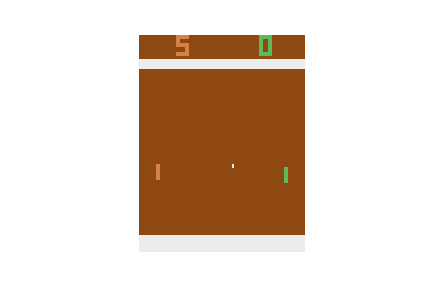
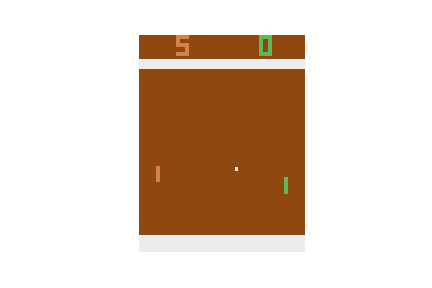
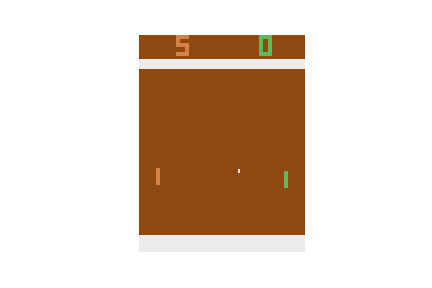
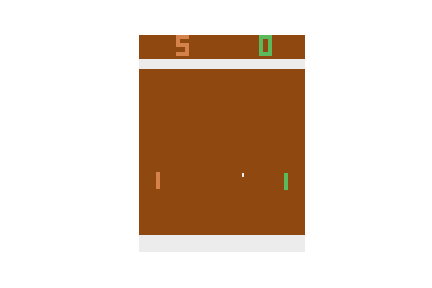
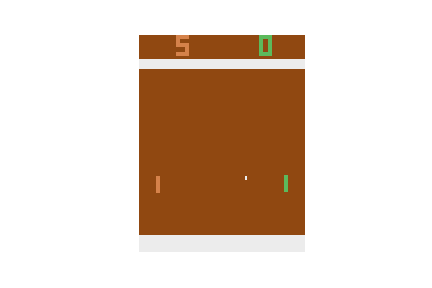
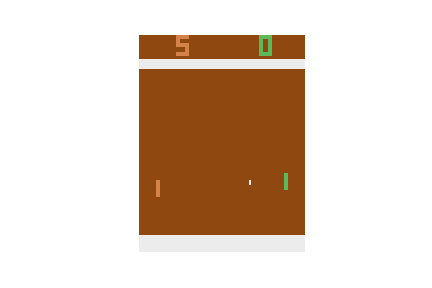
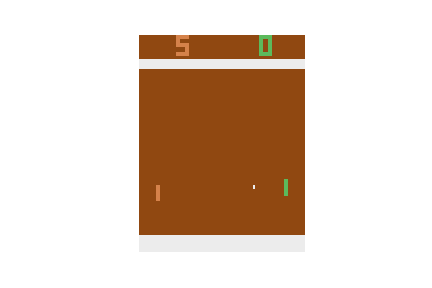
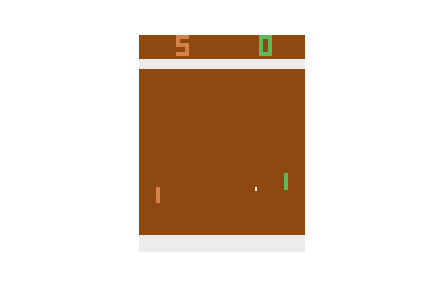
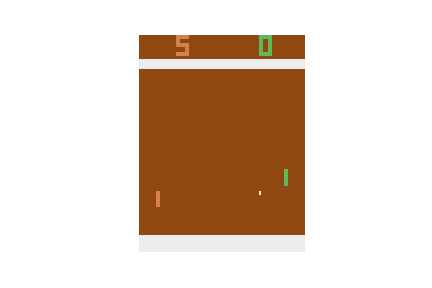
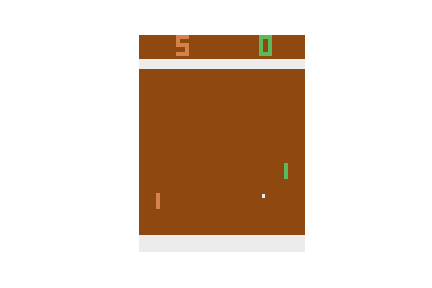
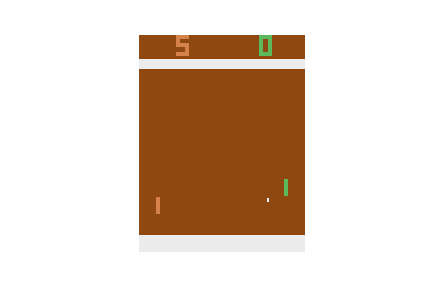
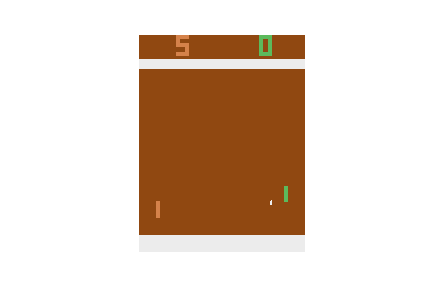
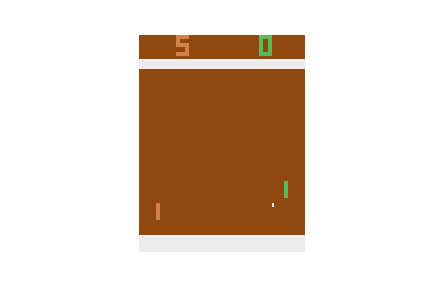
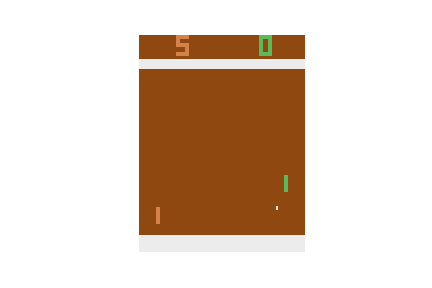
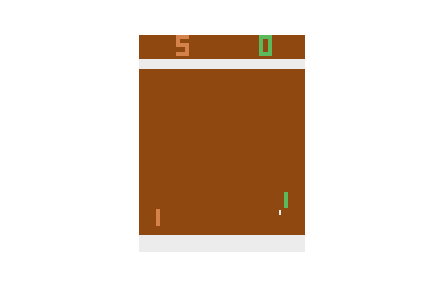
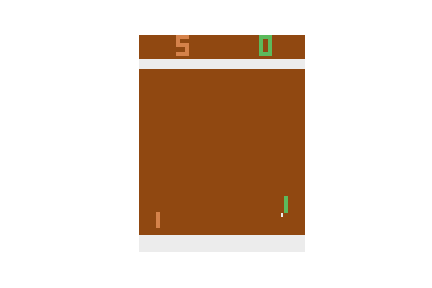
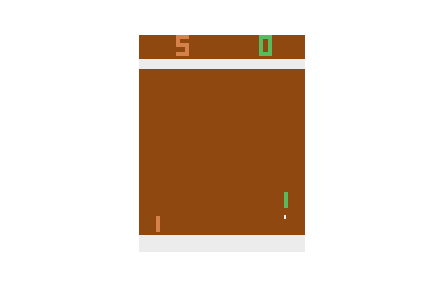
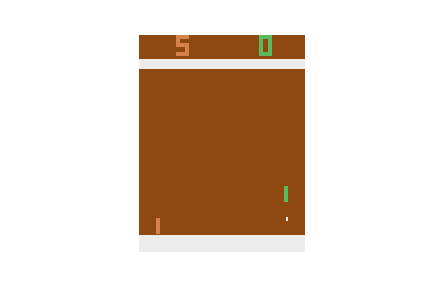
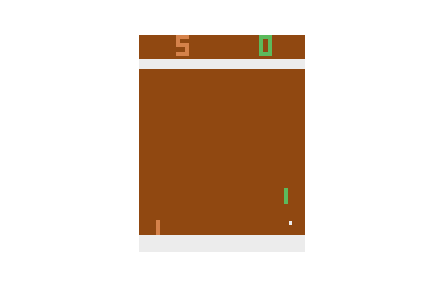
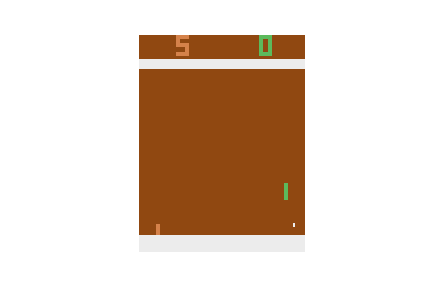
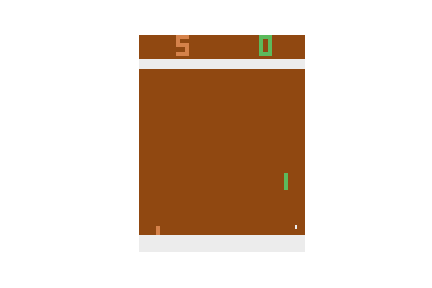
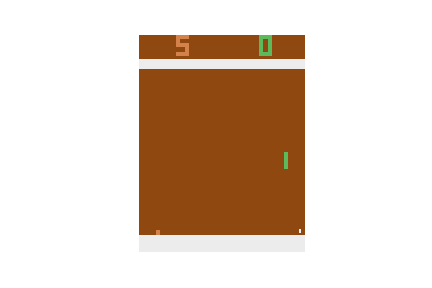
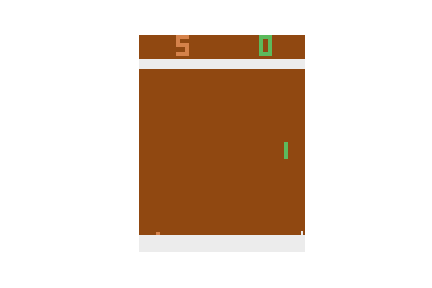
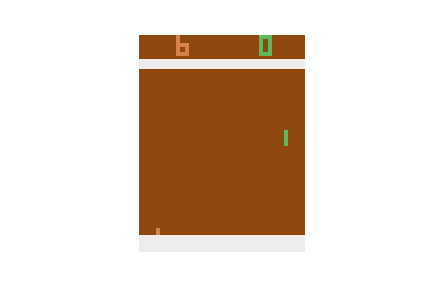
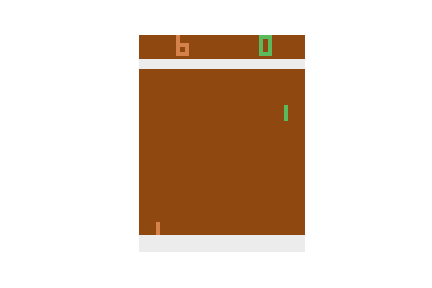
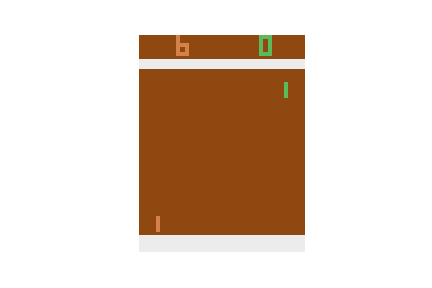
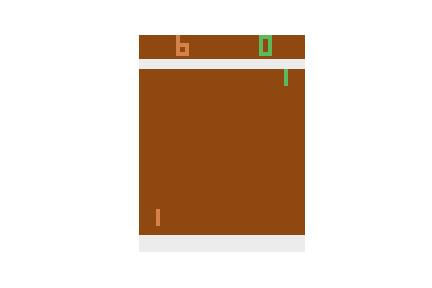
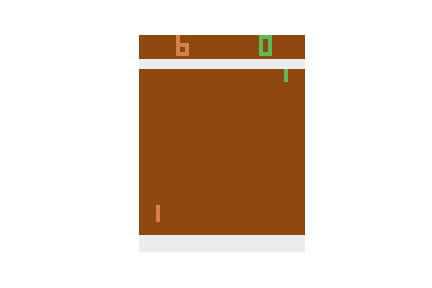
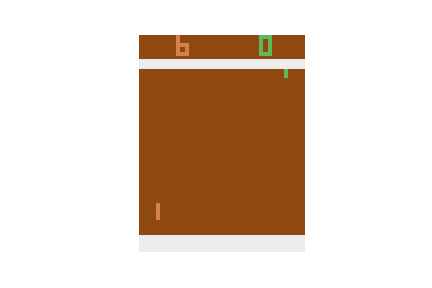
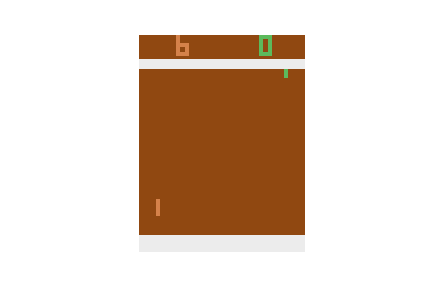
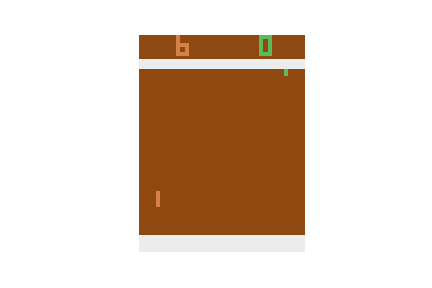
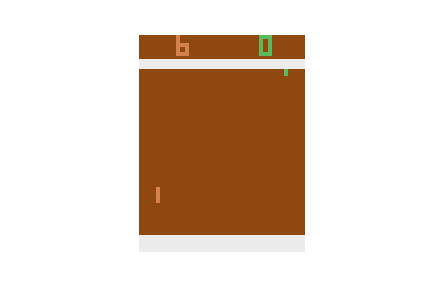
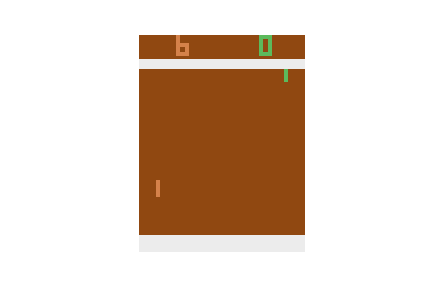
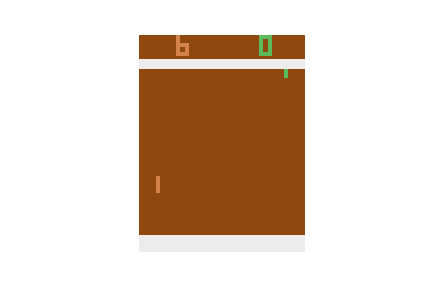
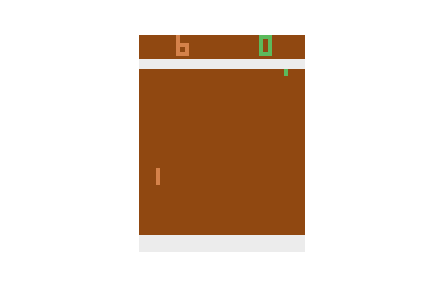
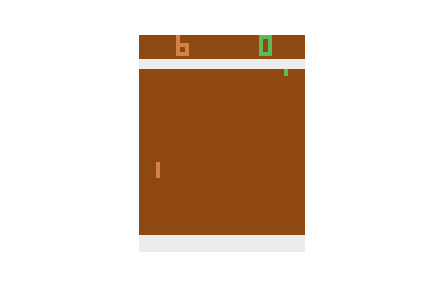
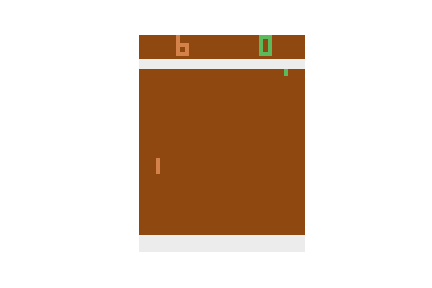
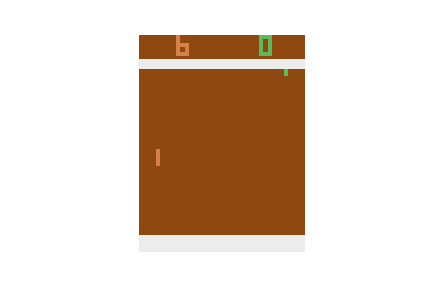
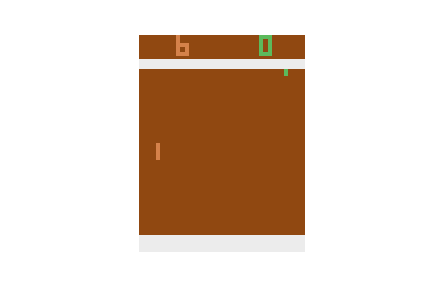
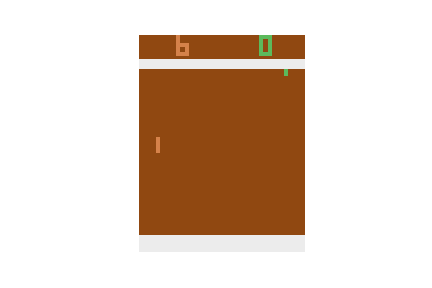
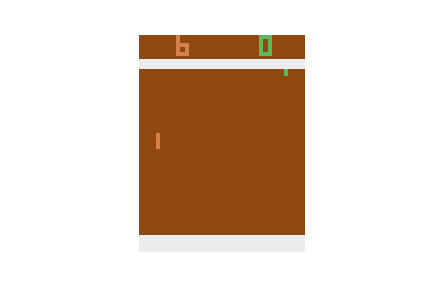
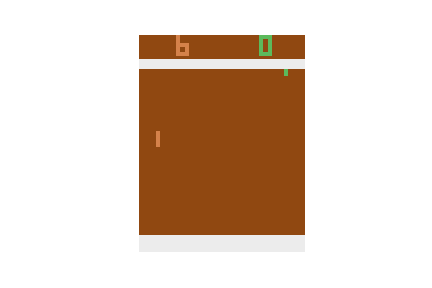
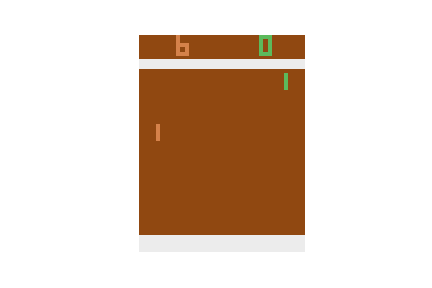
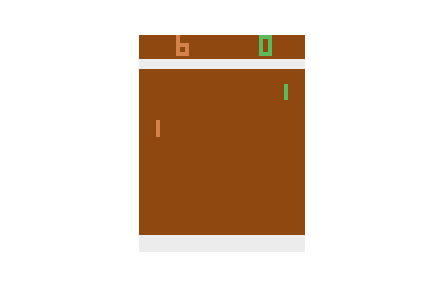
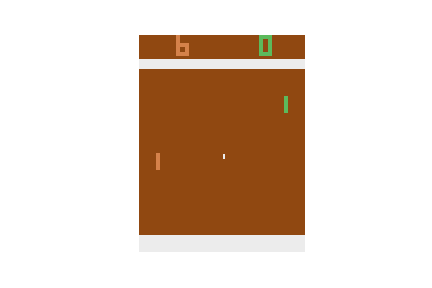
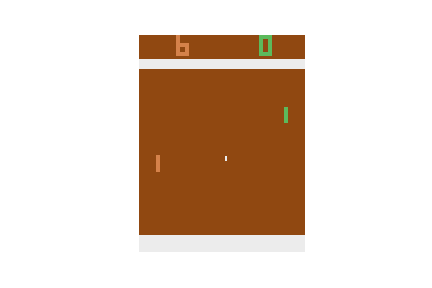
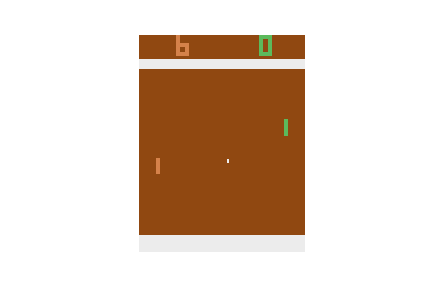
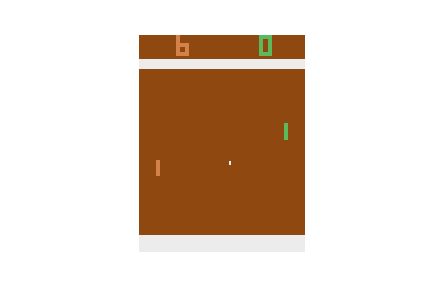
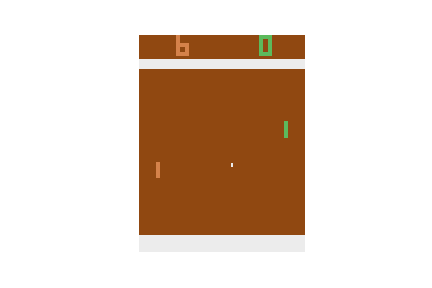
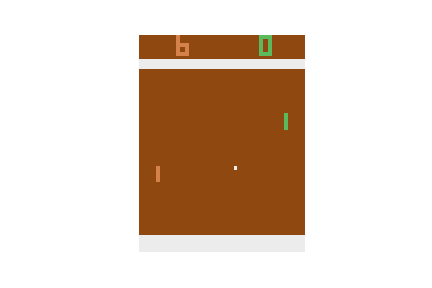
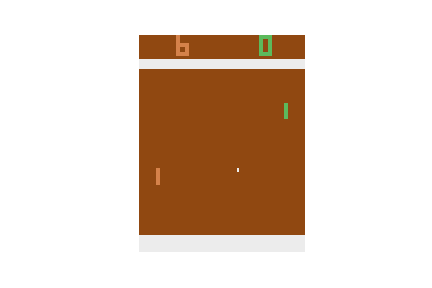
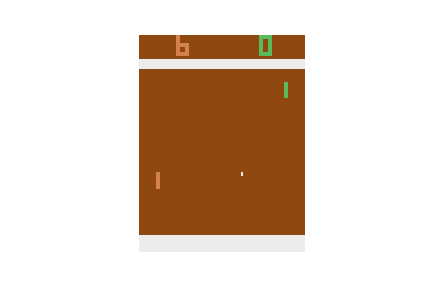
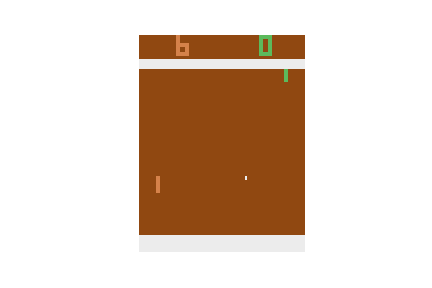
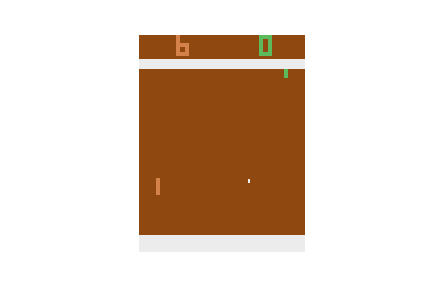
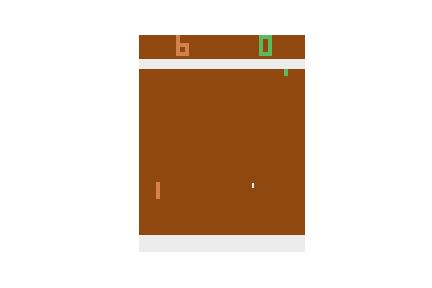
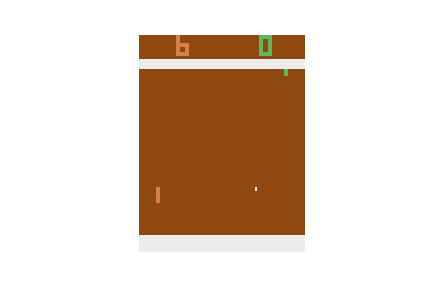
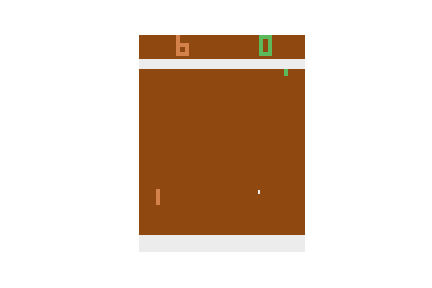
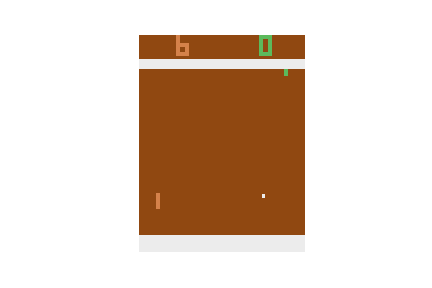
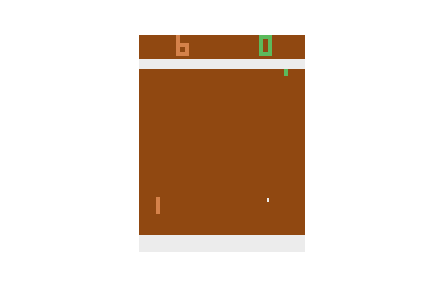
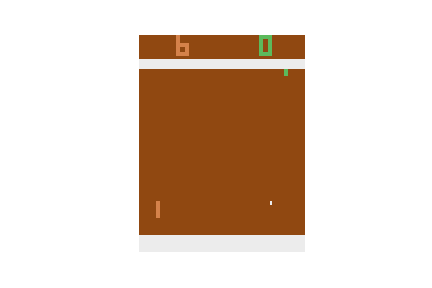
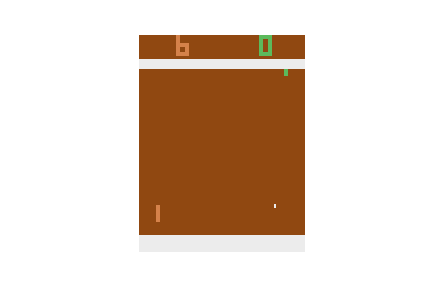
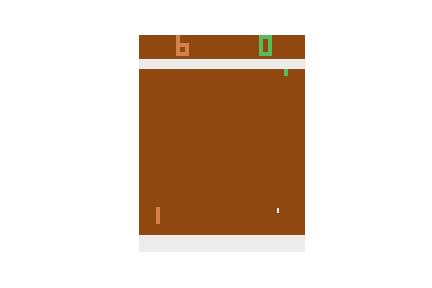
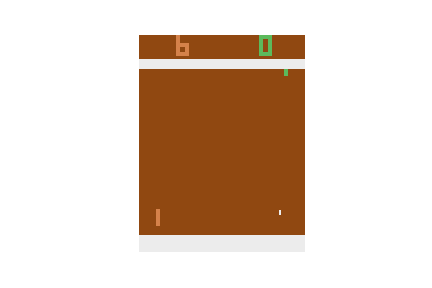
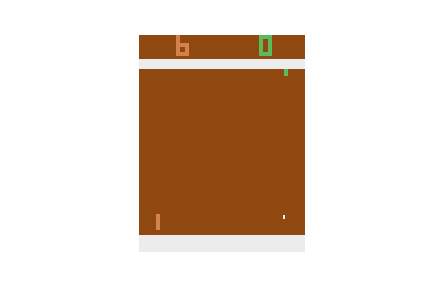
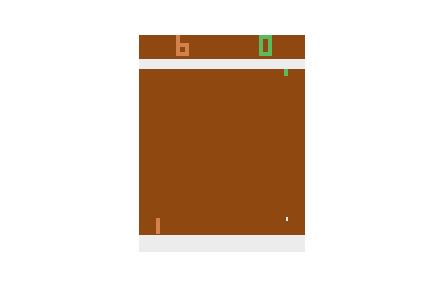
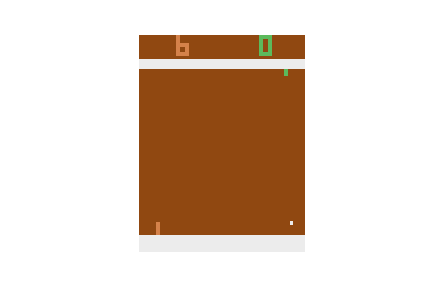
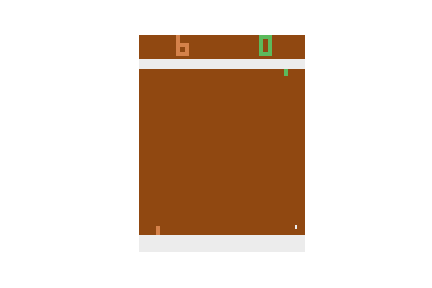
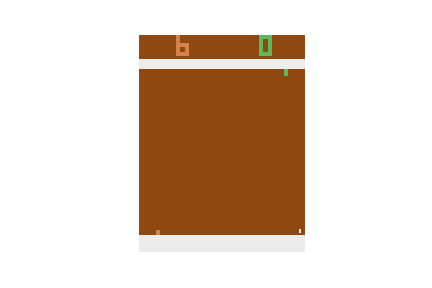
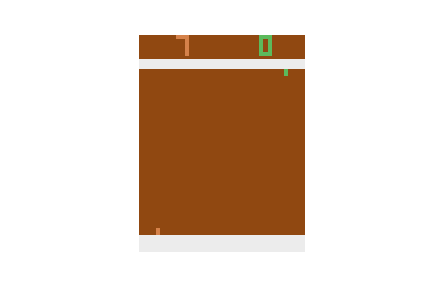
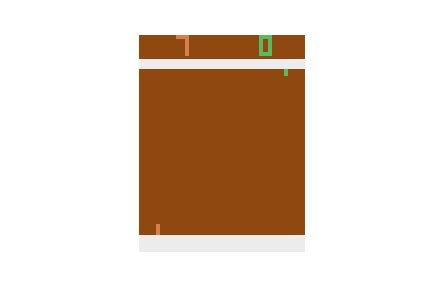
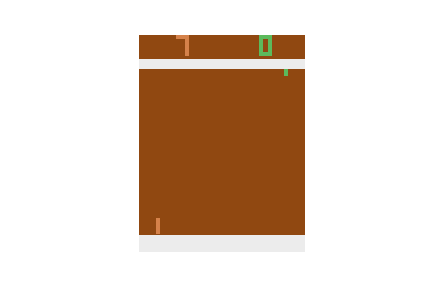
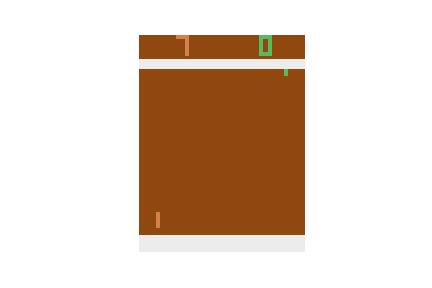
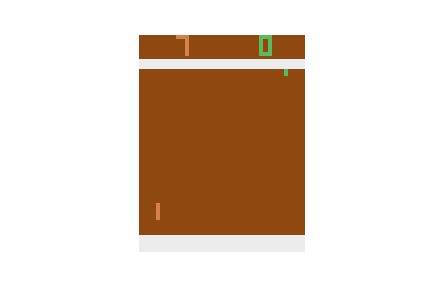
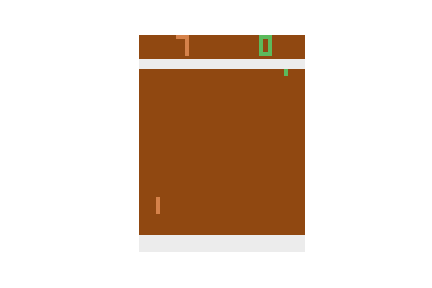
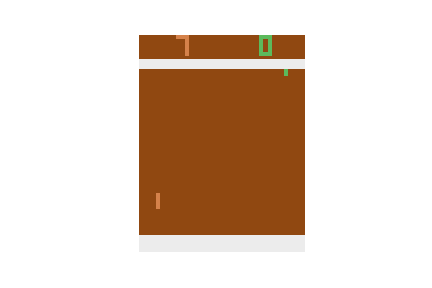
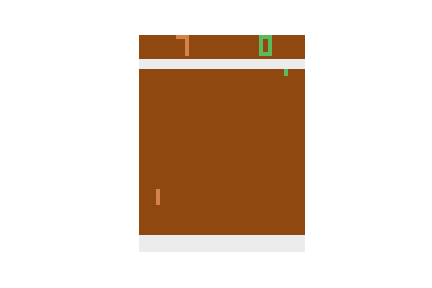
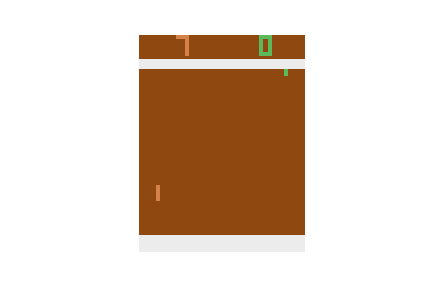
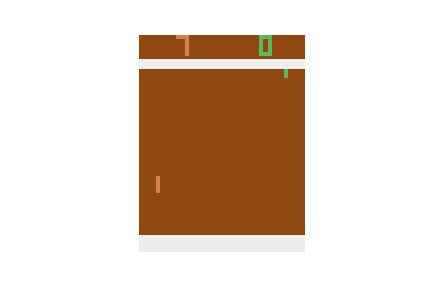
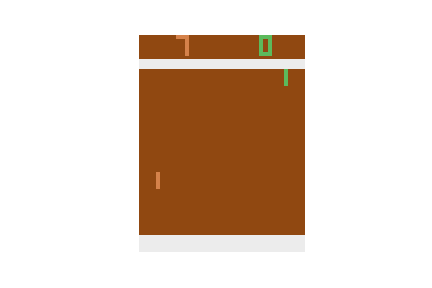
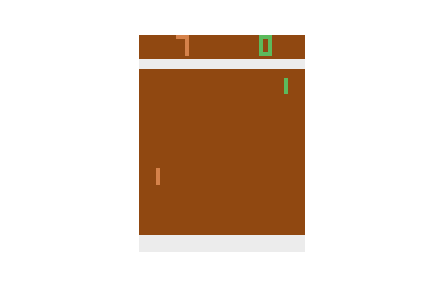
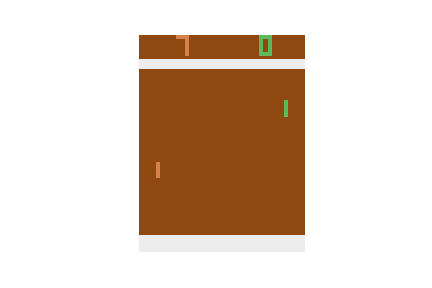
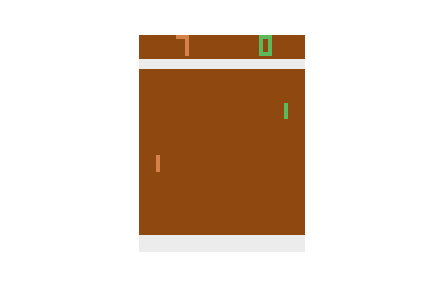
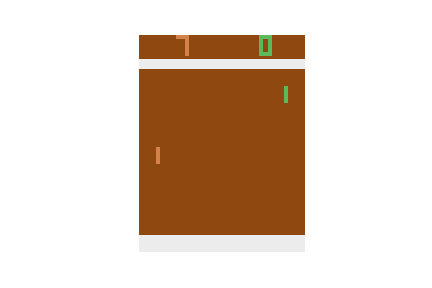
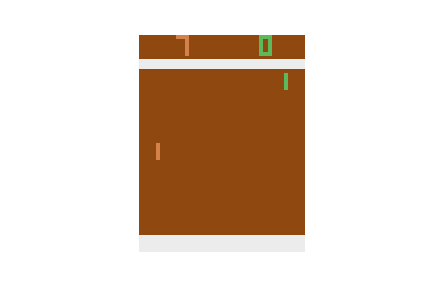
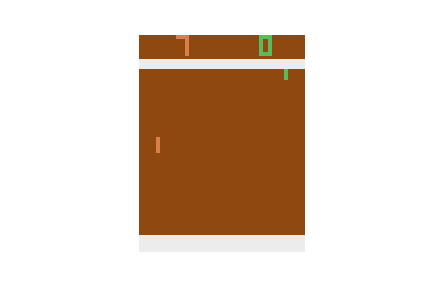
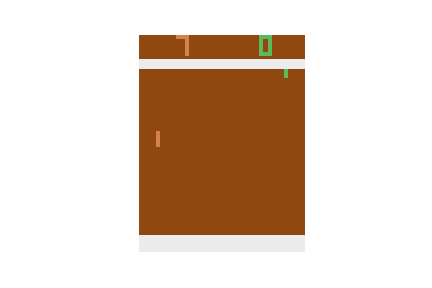
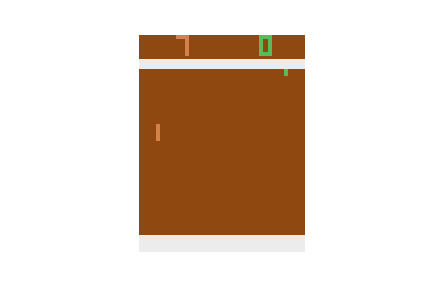
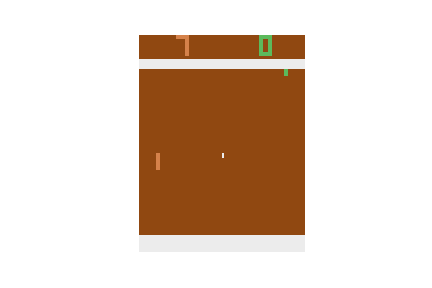
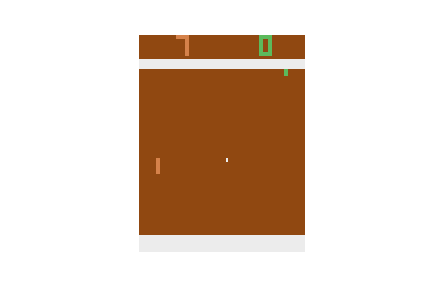
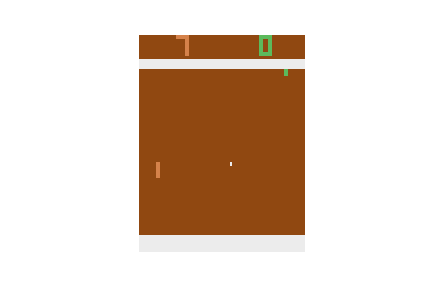
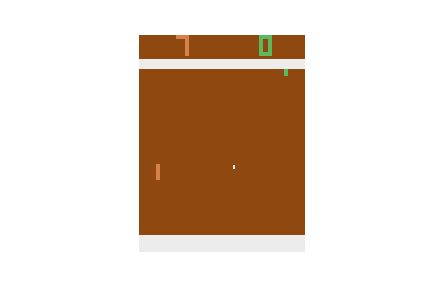
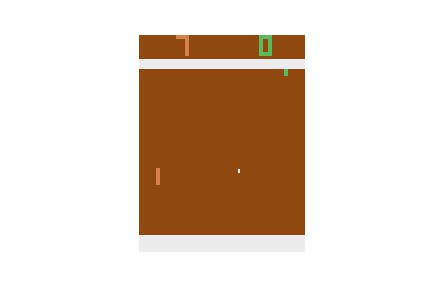
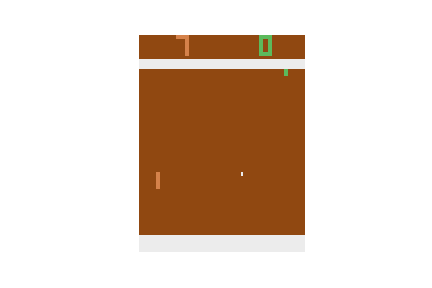
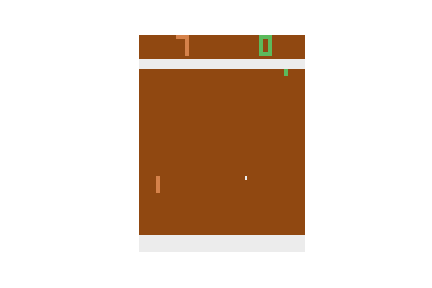
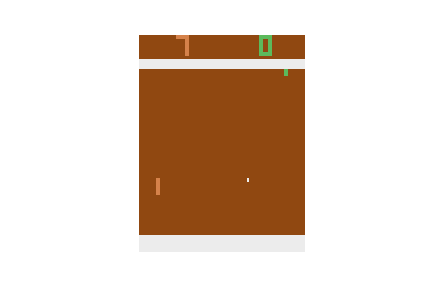
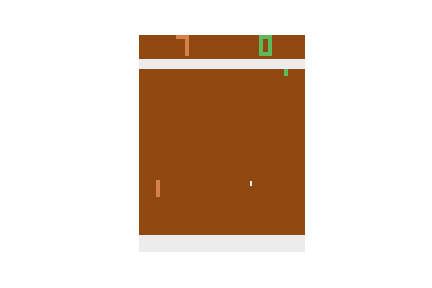
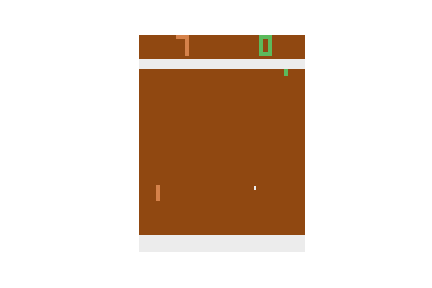
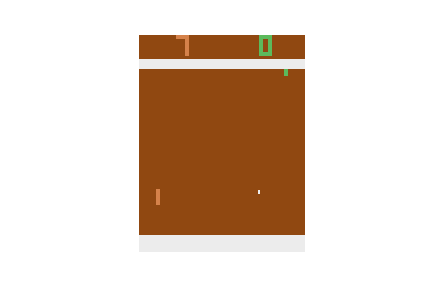
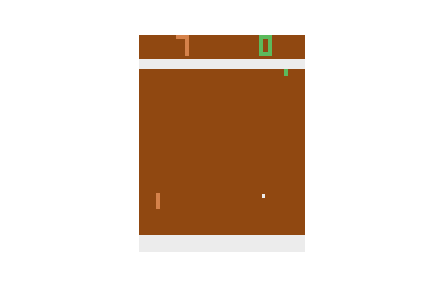
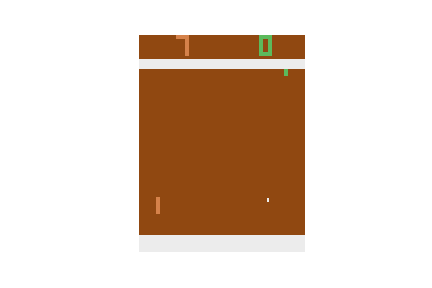
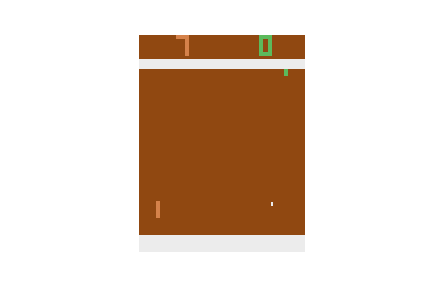
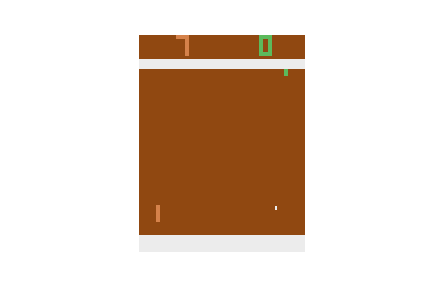
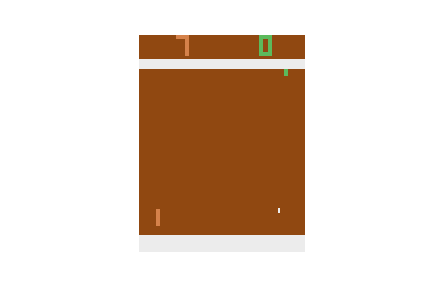
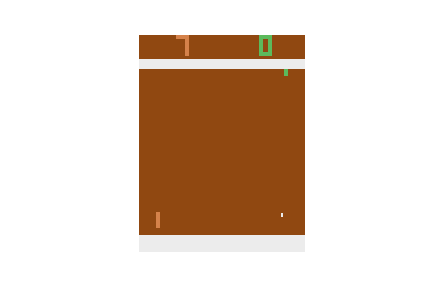
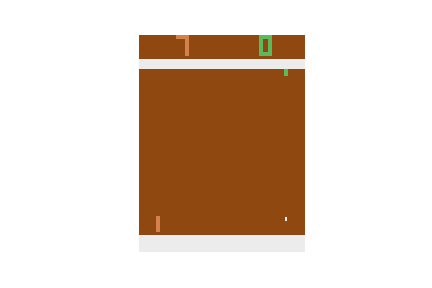

In [8]:
from src import draw as dr 
from src import simulate as sim 

dr.display_frames(sim.simulate_with_trained_policy(weights_filename, number_time_points))

## TO DO: 
* run experiment over night

* add time correlation to reduce the jitteriness of paddle motion
* plot training error as a function of batch number
* revisit NG Notes to see if there are other metrics I should plot
* run these experiments on Amazon GPUs